# CodeBert Grid Experiment Evaluation

**A full run of this Notebook takes about 60 minutes on my machine.**

Make sure to have all required dependencies installed - they are listed in the [environment.yml](./environment.yml). 
You create a conda environment from the yml using 

```
conda env create -f environment.yml
conda activate Lampion-Codebert-Evaluation
```

Make sure to run your Jupyter Notebook from that environment! 
Otherwise you are (still) missing the dependencies. 

**OPTIONALLY** you can use the environment in which your jupter notebook is already running, with starting a new terminal (from jupyter) and run 

```
conda env update --prefix ./env --file environment.yml  --prune
```

Manual Steps

---------------------------------------

The following Steps need to be adjusted for the run to finish: 
    
    1. Run metric Runner external in case you are on windows
    2. Change data directories to required
    3. Change Config Archetypes to match what you have, will be used for printing

Please be aware that by the end of this notebook we create **a big .csv file.**

Some of the statistical tests where easier to do in R, which is provided in a seperate file starting from the bleus.csv created by the end of the notebook.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

import nltk
nltk.download("punkt")
# Homebrew Imports (python-file next to this)
import bleu_evaluator as foreign_bleu

# Set Jupyter vars
# %matplotlib notebook
plt.rcParams.update({'font.size': 35})

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/lapplis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data-Loading / Preparation

Make sure that your dataset looks like described in the [Readme](./README.md), that is 

```
./data
    /PaperResults
        /configs
            /reference
                test_0.gold
                test_0.output
                bleu.txt (optional, can be created below)
            /config_0
                config.properties
                test_0.gold
                test_0.output
                bleu.txt (optional, can be created below)
            /config_1
                config.properties
                test_0.gold
                test_0.output
                bleu.txt (optional, can be created below)
    ...
```

where the configs **must** be numbered to be correctly detected. 

In [2]:
# This runs the bleu-score upon the config files, creating the bleu.txt's 
# If your data package was provided including the txt you dont need to do this. 
# Existing bleu.txt's will be overwritten. 

# Note: This did not behave as intended on Windows - run the command per extraneous bash

#!./metric_runner.sh ./data/java_results/
#!./metric_runner.sh ./data/python_results/

The following cells first run over the given data directory and read all paths, 
then the properties and finally all of the data is loaded.

The bleu.txt files are required at this stage.

In [3]:
# The directory where to look for the data, default are the paper results
# Expected format: 
# [("Prefix","Path"),("Prefix2","Path2")]
data_directories = [("java","./data/java_results"),("python","./data/python_results")]

# These archetypes are later used to group the configurations
# While to grouping is up to you, right here it simply is one archetype for each transformation type, 
# Grouping together different configs with the same transformations applied (but different #Transformations)

# These were the archetypes for the first run (presented in ASE2022 NIER Track)
#config_archetypes = {
#    "config_0":"if","config_1":"if","config_2":"if",
#    "config_3":"neutral-element","config_4":"neutral-element","config_5":"neutral-element",
#    "config_6":"mixed names(pseudo)","config_7":"mixed names(pseudo)","config_8":"mixed names(pseudo)",
#    "config_9":"mixed-names(random)","config_10":"mixed-names(random)","config_11":"mixed-names(random)",
#    "config_12": "add-var(pseudo)","config_13": "add-var(pseudo)","config_14": "add-var(pseudo)",
#    "config_15": "add-var(random)","config_16": "add-var(random)","config_17": "add-var(random)",
#    "config_18": "if & neutral-element","config_19": "if & neutral-element","config_20": "if & neutral-element"
#}
# These are the Archetypes for the second run (To be submitted 2022)
config_archetypes = {
    "config_0":"if","config_1":"if","config_2":"if",
    "config_3":"lambda","config_4":"lambda","config_5":"lambda",
    "config_6":"neutral-element","config_7":"neutral-element","config_8":"neutral-element",
    "config_9":"mixed names(pseudo)","config_10":"mixed names(pseudo)","config_11":"mixed names(pseudo)",
    "config_12":"mixed-names(random)","config_13":"mixed-names(random)","config_14":"mixed-names(random)",
}

print(f"looking for results in {data_directories}" )

results={}

for (prefix,data_directory) in data_directories:
    print(f"Looking for {prefix} at {data_directory}")
    results[prefix]={}
    for root,dirs,files in os.walk(data_directory):
        for name in files:
            if ".gold" in name:
                directory = os.path.basename(root)
                results[prefix][directory]={}
                results[prefix][directory]["prefix"]=prefix
                results[prefix][directory]["result_file"]=os.path.join(root,"test_0.output")
                results[prefix][directory]["gold_file"]=os.path.join(root,"test_0.gold")
                results[prefix][directory]["bleu_file"]=os.path.join(root,"bleu.txt")
                if os.path.exists(os.path.join(root,"config.properties")):
                    results[prefix][directory]["property_file"]=os.path.join(root,"config.properties")
                
print(f"Found {len(results.keys())} configuration folders in {data_directory}")

looking for results in [('java', './data/java_results'), ('python', './data/python_results')]
Looking for java at ./data/java_results
Looking for python at ./data/python_results
Found 2 configuration folders in ./data/python_results


In [4]:
def load_properties(filepath, sep='=', comment_char='#'):
    """
    Read the file passed as parameter as a properties file.
    """
    props = {}
    with open(filepath, "rt") as f:
        for line in f:
            l = line.strip()
            if l and not l.startswith(comment_char):
                key_value = l.split(sep)
                key = key_value[0].strip()
                value = sep.join(key_value[1:]).strip().strip('"') 
                props[key] = value 
    return props

print("reading in property-files")

for prefix in results.keys():
    for key in results[prefix].keys():
        if "property_file" in results[prefix][key].keys():
            results[f"{prefix}"][f"{key}"]["properties"]=load_properties(results[prefix][key]["property_file"])

print("done reading the properties")

reading in property-files
done reading the properties


In [5]:
print("reading in result-files")

for prefix in results.keys():
    for key in results[prefix].keys():
        result_file = results[prefix][key]["result_file"]
        f = open(result_file)
        lines=f.readlines()
        results[prefix][key]["results"]={}
        for l in lines:
            num = int(l.split("\t")[0])
            content = l.split("\t")[1]
            content = content.strip()
            results[prefix][key]["results"][num] = content
        f.close()

        gold_file = results[prefix][key]['gold_file']
        gf = open(gold_file)
        glines=gf.readlines()
        results[prefix][key]["gold_results"]={}
        for gl in glines:
            num = int(gl.split("\t")[0])
            content = gl.split("\t")[1]
            content = content.strip()
            results[prefix][key]["gold_results"][num] = content
        gf.close()

print("done reading the result files")
# Comment this in for inspection of results
#results

reading in result-files
done reading the result files


In [6]:
print("reading in the bleu-scores")

for prefix in results.keys():
    for key in results[prefix].keys():
        bleu_file = results[prefix][key]["bleu_file"]
        f = open(bleu_file)
        score=f.readlines()[0]
        results[prefix][key]["bleu"]=float(score)
        f.close()
    
print("done reading the bleu-scores")

#results["java"]["config_0"]["bleu"]

reading in the bleu-scores
done reading the bleu-scores


The following are little helpers and wrappers to make the notebook a bit smoother.

In [7]:
"""
There is a small issue with the configs being named config_0, config_1, config_10:
As they are treated as strings, config_10 is "smaller then" config_2, making the sort unintuitive
This method should help to sort configs in the intended way: config_1,config_2,...,config_9,config_10,config_11,...

config_num can be used to sort the configs where necessary. It can be used e.g. as 
    sorted(non_reference_configs,key=config_num)
"""
def config_num(c):
    if type(c) == tuple:
        (prefix,config_part) = c
        # Fallback: If we are not trying to sort configs, just do a normal compare
        if not "config_" in config_part:
            return -1
        else:
            c_part = int(config_part.split("_")[1])
            return c_part        
        print("Got a tuple for config num")
    else:
        # Fallback: If we are not trying to sort configs, just do a normal compare
        if not "config_" in c:
            return -1
        else:
            c_part = int(c.split("_")[1])
            return c_part

# The non reference configs are all result-keys that are not "reference"
# Additionally, they are sorted to match the above behaviour (config10>config2)
non_reference_configs = [] 

for prefix in results.keys():
    non_reference_configs += sorted([(prefix,k) for k in results[prefix].keys() if "reference" != k],key=config_num)

print(non_reference_configs)
# Set the Archetypes also into the results using the Archetype Dictionary defined at the beginning of the notebook
for (prefix, key) in non_reference_configs:
        if "property_file" in results[prefix][key].keys():
            results[prefix][key]["archetype"]=config_archetypes[key]

# This helps looking up archetype+transformations per configuration
def archetype_info(config,prefix="java"):
    archetype = config_archetypes[config]
    transforms = int(results[prefix][config]["properties"]["transformations"])
    return (archetype,transforms)

# Pretty Print archetype info for a given config
print_archetype_info = lambda config: f"{(archetype_info(config))[0]}@{(archetype_info(config))[1]}"

# Another Set of archetypes used e.g. for grouping and printing
all_archetypes = set(config_archetypes.values())

# archetype-MT-Mapping for Paper (Where we use MT)
archetype_mt_mapping = {
    "if":"MT-IF",
    "neutral-element":"MT-NE",
    "mixed names(pseudo)": "MT-REP + MT-UVP",
    "mixed-names(random)": "MT-RER + MT-UVR",
    "add-var(pseudo)":"MT-UVP",
    "add-var(random)":"MT-UVR",
    "if & neutral-element":"MT-IF + MT-NE",
    "lambda":"MT-L"
}
mt_archetype_mapping = {}
for (k,v) in archetype_mt_mapping.items():
    mt_archetype_mapping[v]=k

[('java', 'config_0'), ('java', 'config_1'), ('java', 'config_2'), ('java', 'config_3'), ('java', 'config_4'), ('java', 'config_5'), ('java', 'config_6'), ('java', 'config_7'), ('java', 'config_8'), ('java', 'config_9'), ('java', 'config_10'), ('java', 'config_11'), ('java', 'config_12'), ('java', 'config_13'), ('java', 'config_14'), ('python', 'config_0'), ('python', 'config_1'), ('python', 'config_2'), ('python', 'config_3'), ('python', 'config_4'), ('python', 'config_5'), ('python', 'config_6'), ('python', 'config_7'), ('python', 'config_8'), ('python', 'config_9'), ('python', 'config_10'), ('python', 'config_11'), ('python', 'config_12'), ('python', 'config_13'), ('python', 'config_14')]


In [8]:
# These Two Wrappers are adapters to the ntlk library, 
# In addition they cover often-occuring errors with a default behaviour
# (Instead of throwing errors)

def jaccard_wrapper(sentenceA,sentenceB,ngram=1,lowercasing=True):
    a = sentenceA.lower() if lowercasing else sentenceA
    b = sentenceB.lower() if lowercasing else sentenceB
    tokensA = nltk.word_tokenize(a)
    tokensB = nltk.word_tokenize(b)

    ngA_tokens = set(nltk.ngrams(tokensA, n=ngram))
    ngB_tokens = set(nltk.ngrams(tokensB, n=ngram))
    
    if (len(ngB_tokens)==0) and (len(ngA_tokens)==0):
        return 0
    if (len(ngB_tokens)==0) or (len(ngA_tokens)==0):
        return 1
    
    return nltk.jaccard_distance(ngA_tokens, ngB_tokens)

def bleu_wrapper(sentence_to_check,reference):
    check_tokens = nltk.word_tokenize(sentence_to_check)
    ref_tokens = nltk.word_tokenize(reference)
    
    # From comparing the foreign_bleu and nltk the method4 seems to match
    # The Paper names the BLEU-4-Score with a citation to chen & cherry
    # I wish I could be named chen & cherry, its a very cool name. 
    chencherry = nltk.translate.bleu_score.SmoothingFunction()
    smooth_fn = chencherry.method4
    
    try:
        return nltk.translate.bleu_score.sentence_bleu([ref_tokens],check_tokens,smoothing_function=smooth_fn)
    except:
        return 0

## Bleu-Scores

In the following, the BLEU-scores will be calculated using the foreign libary. 
While there have been minor changes to standard-BLEU, it is the same as used in the original experiment.

The aggregated BLEU-Scores will be stored to the results.

In [9]:
bleu_data = []
for prefix in results.keys():
    #bleu_data[prefix]={}
    archetypes = set([results[prefix][k]["archetype"] for k in results[prefix].keys() if "archetype" in results[prefix][k].keys()])
    for archetype in archetypes:
        reference_score = round(results[prefix]["reference"]["bleu"])
        reference_datapoint = (prefix,"reference",archetype,0,reference_score)
        bleu_data.append(reference_datapoint)
        relevant_configs = [k for k 
                            in results[prefix].keys() 
                            if "archetype" in results[prefix][k].keys() 
                            and results[prefix][k]["archetype"]==archetype]
        for c in relevant_configs:
            score = round(results[prefix][c]["bleu"],3)
            datapoint = (prefix,c,archetype,int(results[prefix][c]["properties"]["transformations"]),score)
            bleu_data.append(datapoint)
            del datapoint
        del reference_datapoint

bleu_data_df = pd.DataFrame(bleu_data)
bleu_data_df = bleu_data_df.sort_index()
#bleu_data_df.columns = [archetype_mt_mapping[n] for n in bleu_data_df.columns if n is in archetype_mt_mapping.keys()]
bleu_data_df.columns = ["prefix","config","archetype","transformations","bleu"]

with open(f"./exports/{prefix}_bleu_table.tex","w") as f: 
    f.write(
        bleu_data_df.to_latex(
            caption="BLEU4-Scores for increasing number of metamorphic transformations \n (applied n-times per datapoint)"
            ,label="tab:bleus"
            ,position="tbh"
            #,column_format={rrrrrrr}
        )         
    )
del bleu_data

bleu_data_df

prefix     config            archetype  transformations    bleu
0     java  reference                   if                0  18.000
1     java   config_0                   if                1  17.651
2     java   config_1                   if                5  17.409
3     java   config_2                   if               10  17.493
4     java  reference  mixed-names(random)                0  18.000
5     java  config_12  mixed-names(random)                1  17.295
6     java  config_13  mixed-names(random)                5  16.828
7     java  config_14  mixed-names(random)               10  16.727
8     java  reference      neutral-element                0  18.000
9     java   config_7      neutral-element                5  17.695
10    java   config_6      neutral-element                1  17.715
11    java   config_8      neutral-element               10  17.532
12    java  reference               lambda                0  18.000
13    java   config_3               lambda                1  17.542
14    java   config_4               lambda                5  17.293
15    java   config_5               lambda               10  17.286
16    java  reference  mixed names(pseudo)                0  18.000
17    java   config_9  mixed names(pseudo)                1  17.250
18    java  config_11  mixed names(pseudo)               10  16.808
19    java  config_10  mixed names(pseudo)                5  16.885
20  python  reference                   if                0  17.000
21  python   config_0                   if                1  17.182
22  python   config_1                   if                5  16.730
23  python   config_2                   if               10  16.360
24  python  reference  mixed-names(random)                0  17.000
25  python  config_12  mixed-names(random)                1  16.491
26  python  config_13  mixed-names(random)                5  15.156
27  python  config_14  mixed-names(random)               10  14.122
28  python  reference      neutral-element                0  17.000
29  python   config_7      neutral-element                5  14.693
30  python   config_6      neutral-element                1  16.586
31  python   config_8      neutral-element               10  13.677
32  python  reference               lambda                0  17.000
33  python   config_3               lambda                1  16.505
34  python   config_4               lambda                5  14.910
35  python   config_5               lambda               10  13.842
36  python  reference  mixed names(pseudo)                0  17.000
37  python   config_9  mixed names(pseudo)                1  16.524
38  python  config_11  mixed names(pseudo)               10  13.976
39  python  config_10  mixed names(pseudo)                5  15.034

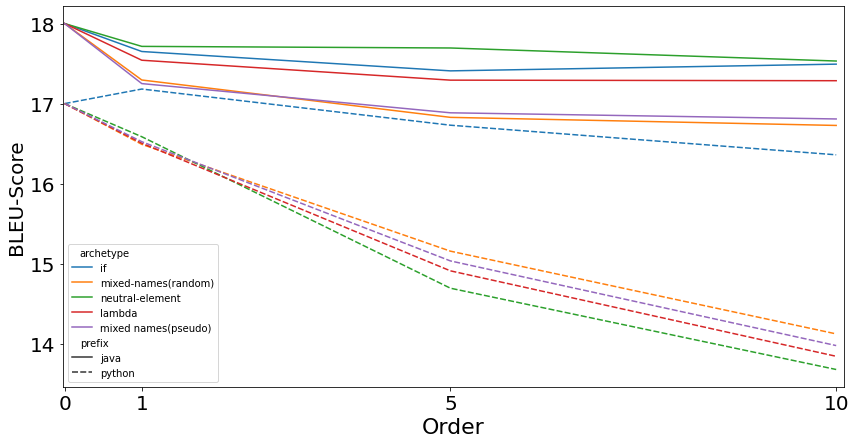

In [10]:
#bleu_data_df.columns = [archetype_mt_mapping[a] for a in bleu_data_df.columns]

plt.figure(figsize=(14,7))
plt.ylabel("BLEU-Score",fontsize=20)
#plt.xlabel("# Transformations")
plt.xlabel("Order",fontsize=22)
#for latex, its nicer to have the title set from latex itself
#plt.title("BLEU4-Scores for increasing number of metamorphic transformations \n (applied n-times per datapoint)")

plot = sns.lineplot(x="transformations",y="bleu",data=bleu_data_df,hue="archetype",style="prefix",markers=False,dashes=True)
plt.xticks([0,1,5,10],fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.025,10.1)
#plt.legend(bleu_data_df.columns,fontsize=16)
plt.savefig('images/bleu_scores.png')
plt.show()

In [11]:
bleu_data_df_transposed = bleu_data_df.transpose()
bleu_data_df_transposed = bleu_data_df_transposed.drop(axis=1,columns=0)
with open("./exports/transposed_bleu_table.tex","w") as f: 
    f.write(
        bleu_data_df_transposed.to_latex(
            caption="BLEU4-Scores for increasing order of metamorphic transformations \n (applied n-times per datapoint)"
            ,label="tab:bleus"
            ,position="th"
            #,column_format={rrrrrrr}
        )          
)

#bleu_data_df_transposed

## Per Entry Bleu

Now we use the nltk-provided bleu score to calculate the bleu-scores for all entries.
We store them on a per-result basis always bleu(gold,config).

The nltk bleu does not go from 0 to 100 but from 0 to 1, but they are the same by a factor of 100.

In [12]:
# This wrapper applies the "bleu_wrapper" to every element of a configurations results.
# The result is a list of [bleu-score(config[i],gold[i])]
# Entries are in order ascending
def calculate_bleus(results,prefix,config_id):
    bleus = []
    entries = results[prefix][config_id]["results"].keys()
    print(f"Calculating bleus for {prefix}-{config_id} ({len(entries)} entries)")
    for i in entries:
        gold_result = results[prefix][config_id]["gold_results"][i]
        config_result = results[prefix][config_id]["results"][i]
        bleu = bleu_wrapper(gold_result,config_result)
        bleus.append(bleu)
    return bleus
        
# Comment in for test and inspection
# calculate_bleus(results,"java","config_0")

In [13]:
"""
These plots, while not necessary the best, try to compare the bleus of the reference to the bleus of a config.
They don't take very long, the actual bleu-calculation is what takes time in the cell below.
"""

def plot_bleu_histogram(config_data,reference_data,title):
    plt.figure(figsize=(14,7))
    
    histo_df=pd.DataFrame.from_dict(
        {"reference":reference_data,
            title:config_data }
    )

    sns.displot(
        data=histo_df,
        kind="hist", kde=True,
        height=6, aspect=10/6
               )
    plt.title(f"Histogram of Bleu-Scores for {title}")
    plt.xlabel("Bleu-Score")
    #plt.ylabel("# of Entries")
    plt.xlim(0,1)
    plt.savefig(f'images/{title}_bleu_histogram.png')
    plt.show()
    
def plot_bleu_boxplot(config_data,reference_data,title=None):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)
    box_df=pd.DataFrame.from_dict(
        {"reference":reference_data,
            title:config_data }
    )    
    sns.boxplot(
        data=box_df)
    
    plt.title(f"Boxplot of Bleu-Scores for {title}")
    plt.ylabel("Bleu-Score")
    
    major_ticks = np.arange(0, 1, 0.2)
    minor_ticks = np.arange(0, 1, 0.05)

    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')

    #plt.grid()
    plt.savefig(f'images/{title}_bleu_box.png')
    plt.ylim(0,1)
    
    plt.show()
    
def plot_bleu_violinplot(config_data,reference_data,title):
    plt.figure(figsize=(6,4))
    print(len(reference_data),len(config_data))
    violin_df=pd.DataFrame.from_dict(
        {"reference":reference_data,
            title:config_data }
    )
    
    sns.violinplot(data=violin_df)
    
    plt.grid()
    plt.title(f"ViolinPlot of Bleu-Scores for {title}")
    plt.ylabel("Bleu-Score")
    
    plt.savefig(f'images/{title}_bleu_violin.png')
    plt.show()
    
#plot_bleu_violinplot(sample_bleus_config_data,bleus_reference_data,"config_20")
#plot_bleu_boxplot(sample_bleus_config_data,bleus_reference_data,"config_20")
#plot_bleu_histogram(sample_bleus_config_data,bleus_reference_data,"config_20")

Calculating bleus for java-reference (10427 entries)
java config_0

Calculating bleus for java-config_0 (10427 entries)
10427 10427


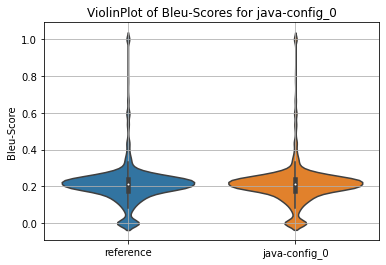

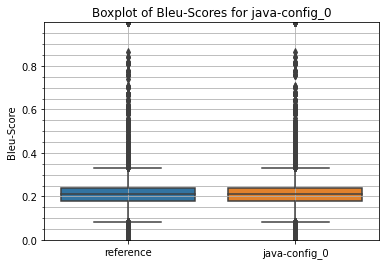

<Figure size 1008x504 with 0 Axes>

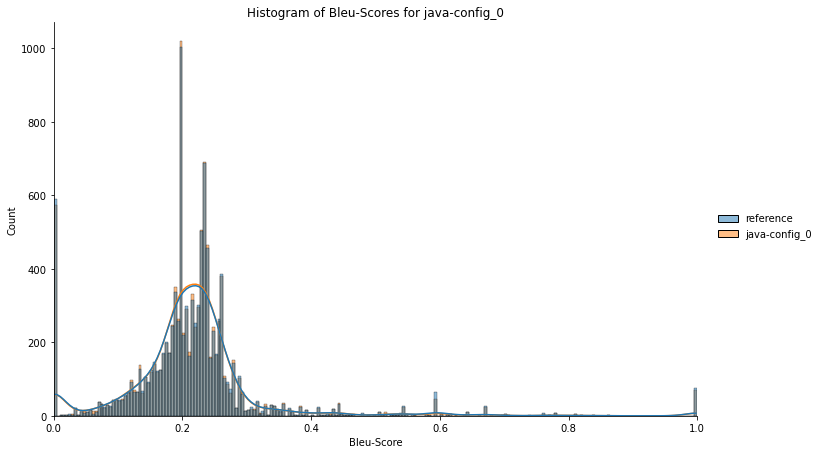

java config_1

Calculating bleus for java-config_1 (10427 entries)
10427 10427


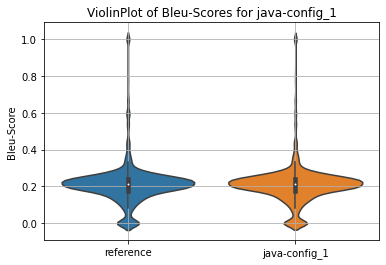

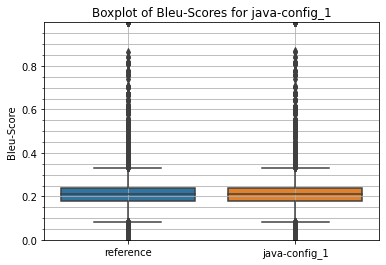

<Figure size 1008x504 with 0 Axes>

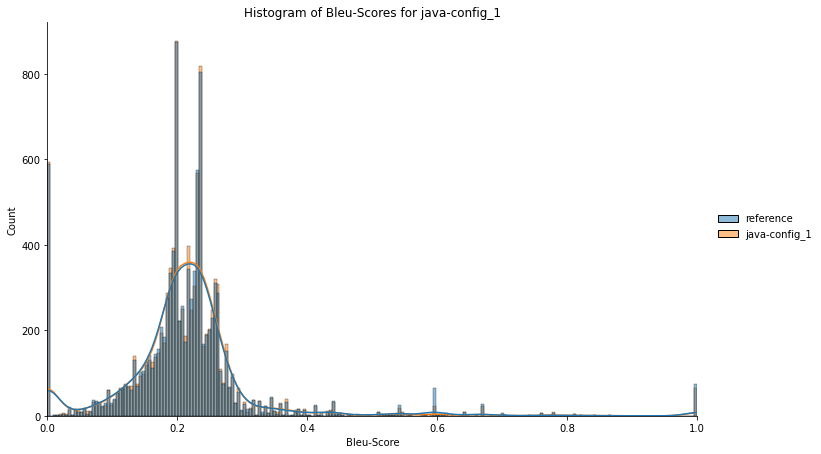

java config_2

Calculating bleus for java-config_2 (10427 entries)
10427 10427


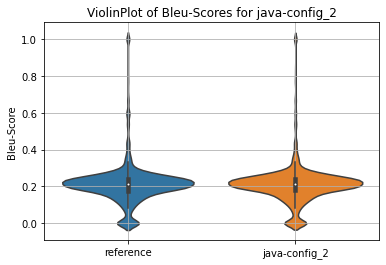

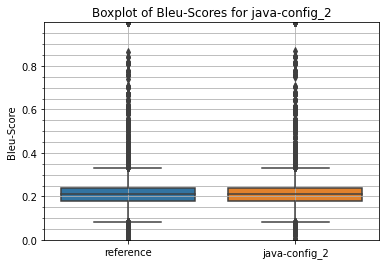

<Figure size 1008x504 with 0 Axes>

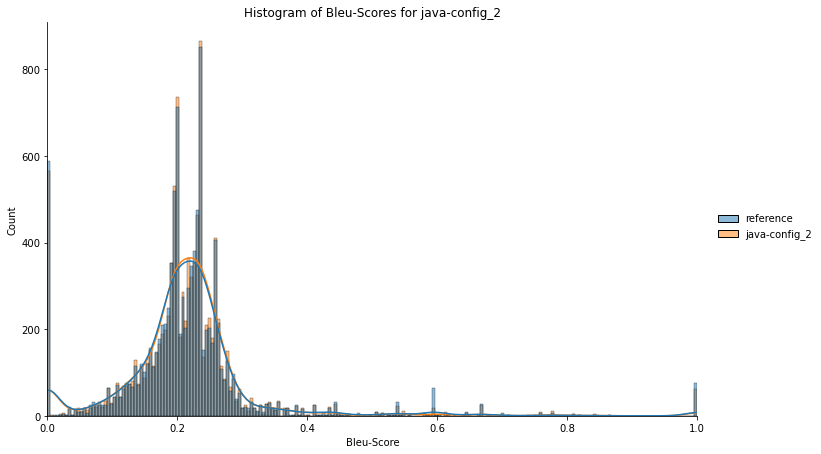

java config_3

Calculating bleus for java-config_3 (10427 entries)
10427 10427


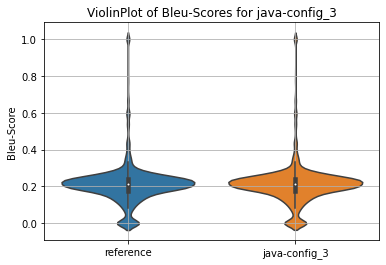

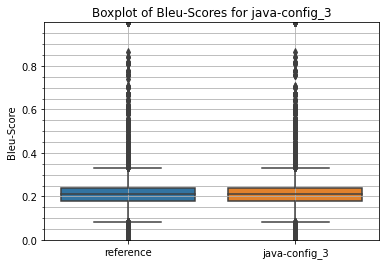

<Figure size 1008x504 with 0 Axes>

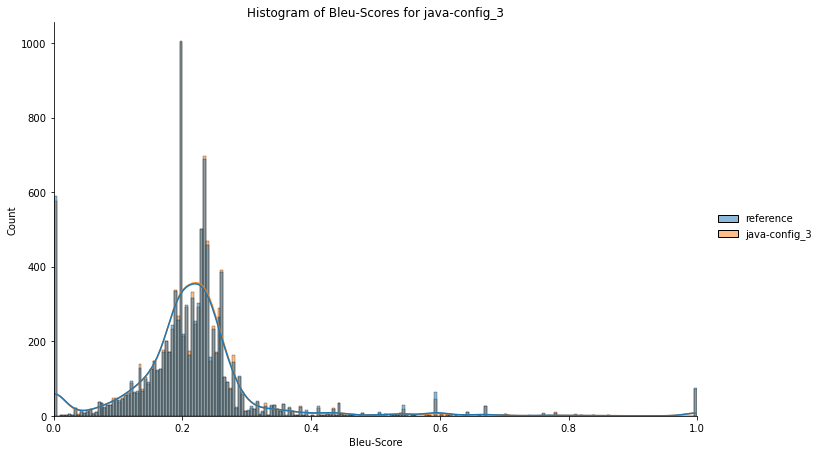

java config_4

Calculating bleus for java-config_4 (10427 entries)
10427 10427


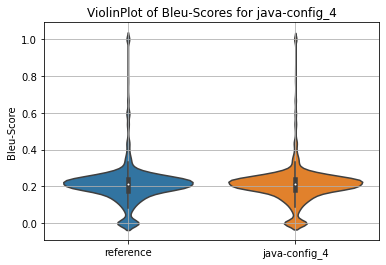

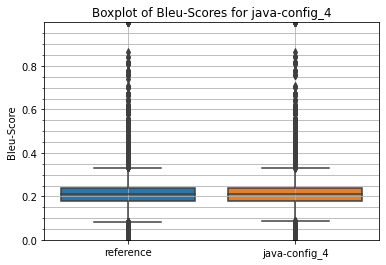

<Figure size 1008x504 with 0 Axes>

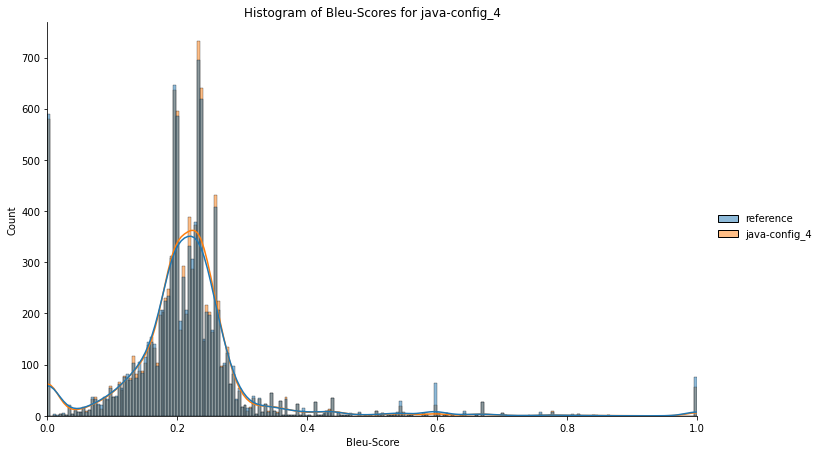

java config_5

Calculating bleus for java-config_5 (10427 entries)
10427 10427


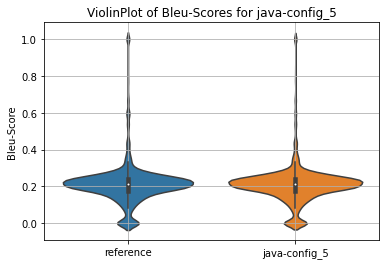

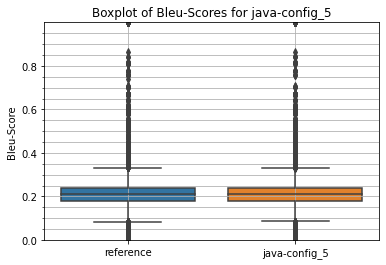

<Figure size 1008x504 with 0 Axes>

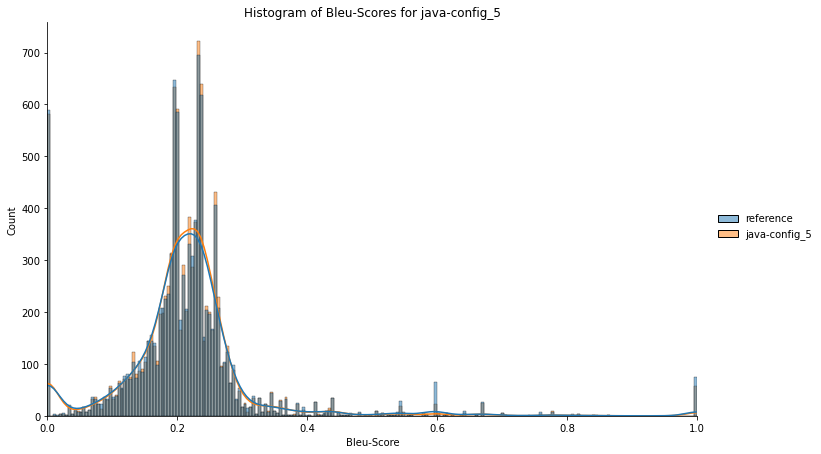

java config_6

Calculating bleus for java-config_6 (10427 entries)
10427 10427


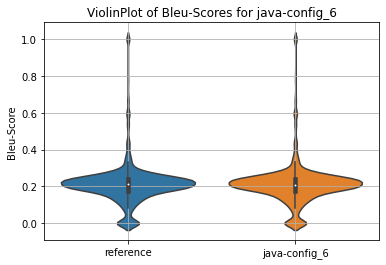

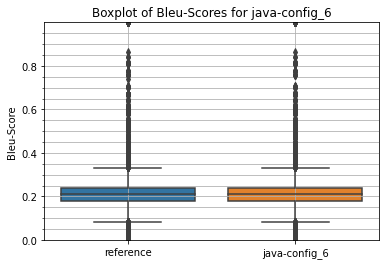

<Figure size 1008x504 with 0 Axes>

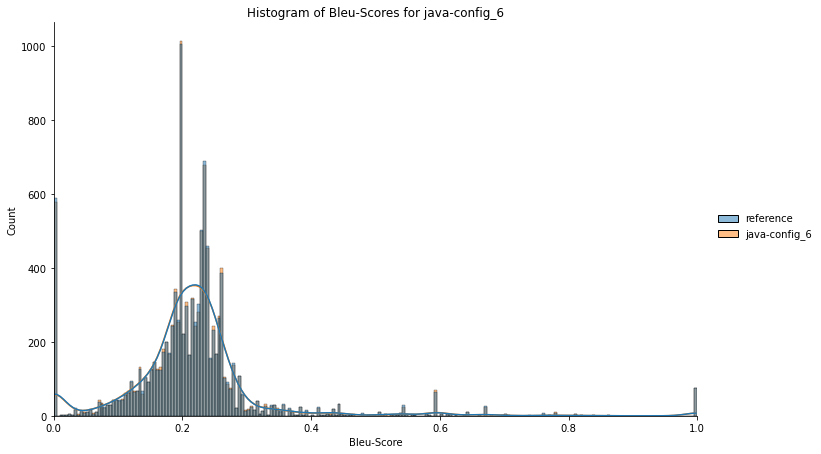

java config_7

Calculating bleus for java-config_7 (10427 entries)
10427 10427


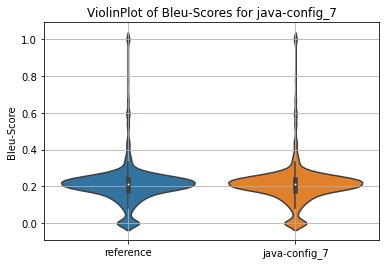

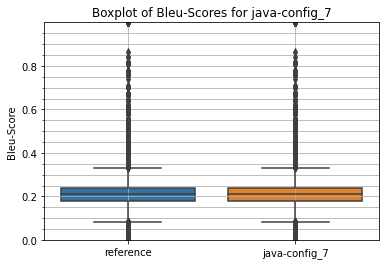

<Figure size 1008x504 with 0 Axes>

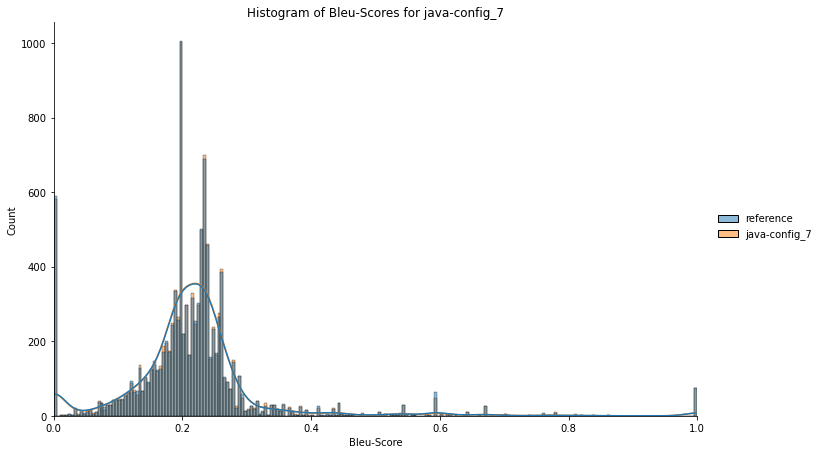

java config_8

Calculating bleus for java-config_8 (10427 entries)
10427 10427


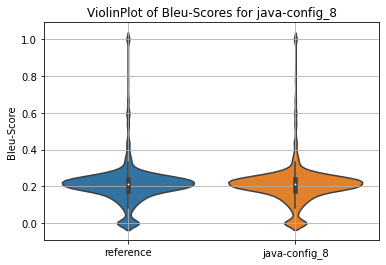

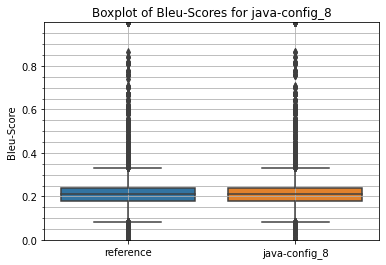

<Figure size 1008x504 with 0 Axes>

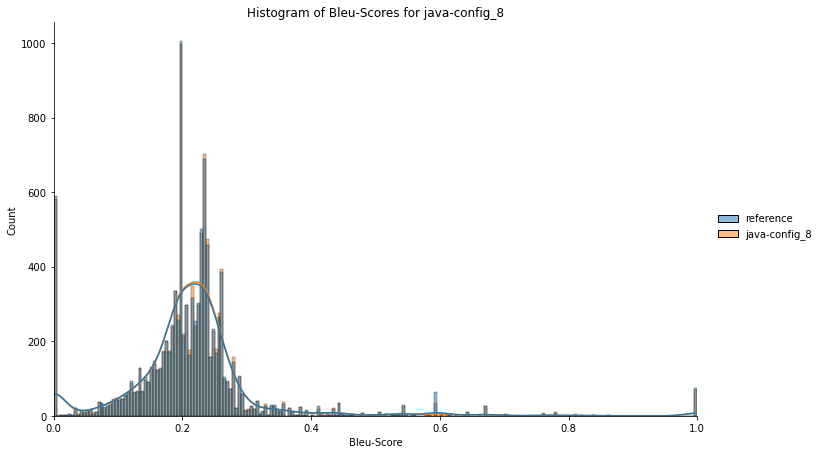

java config_9

Calculating bleus for java-config_9 (10427 entries)
10427 10427


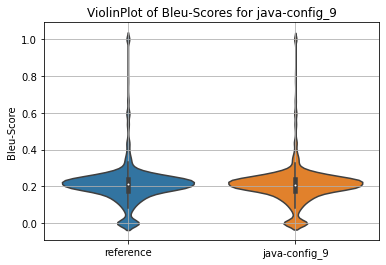

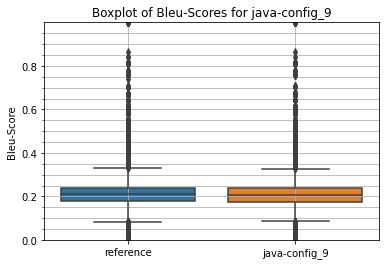

<Figure size 1008x504 with 0 Axes>

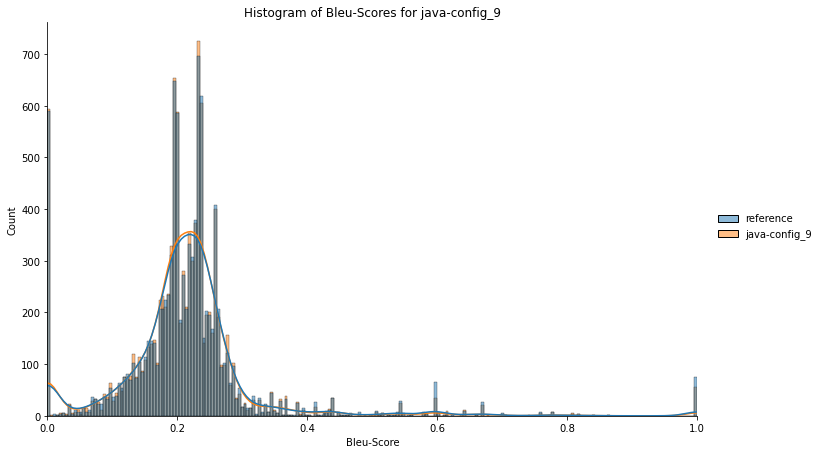

java config_10

Calculating bleus for java-config_10 (10427 entries)
10427 10427


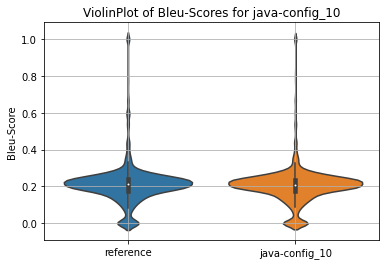

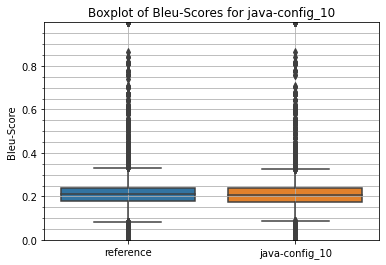

<Figure size 1008x504 with 0 Axes>

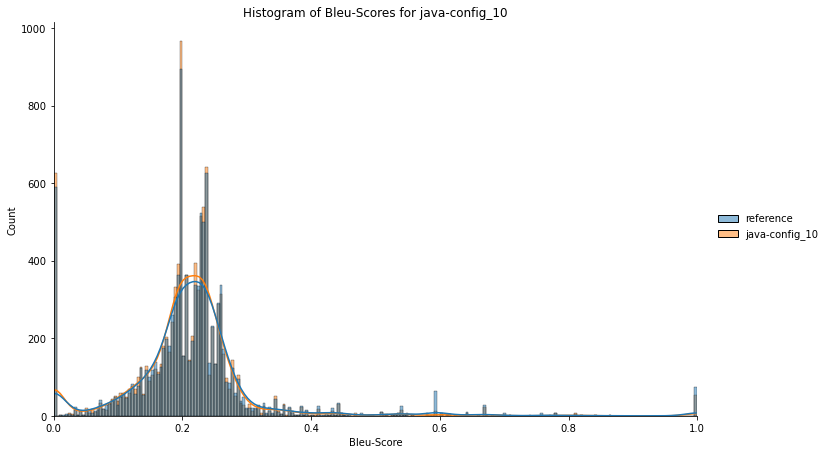

java config_11

Calculating bleus for java-config_11 (10427 entries)
10427 10427


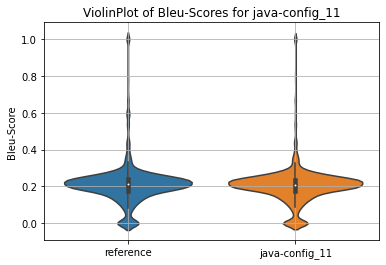

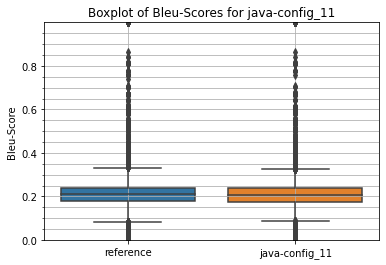

<Figure size 1008x504 with 0 Axes>

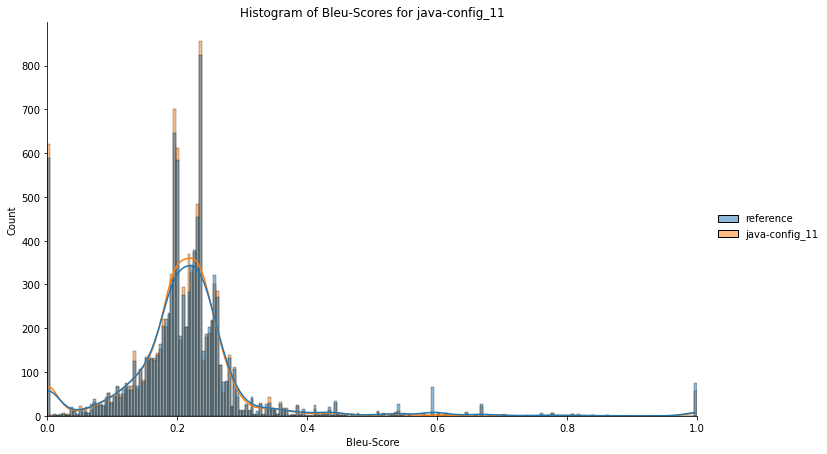

java config_12

Calculating bleus for java-config_12 (10427 entries)
10427 10427


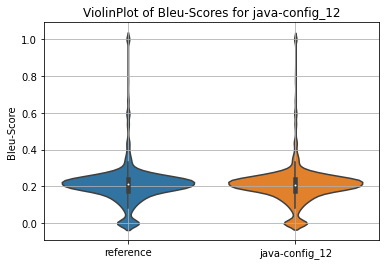

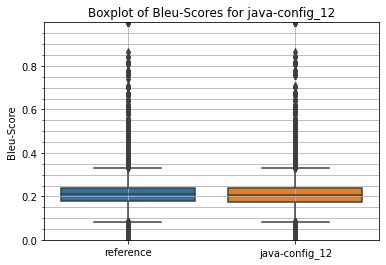

<Figure size 1008x504 with 0 Axes>

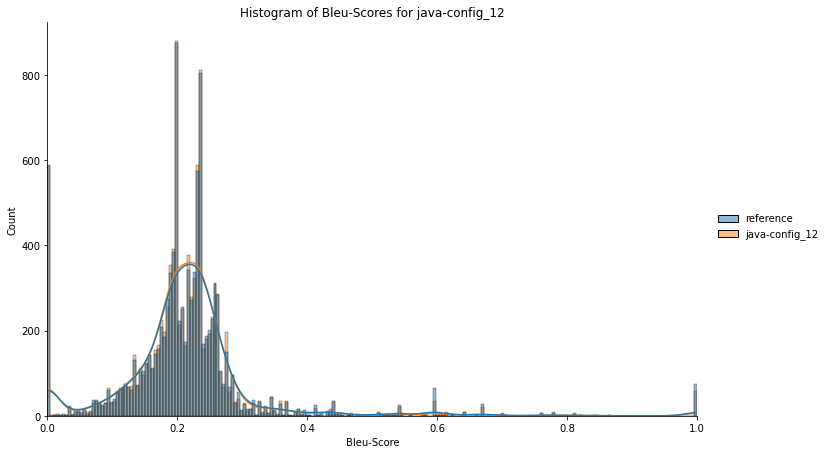

java config_13

Calculating bleus for java-config_13 (10427 entries)
10427 10427


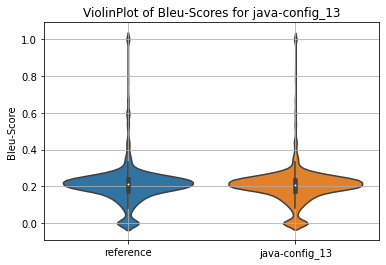

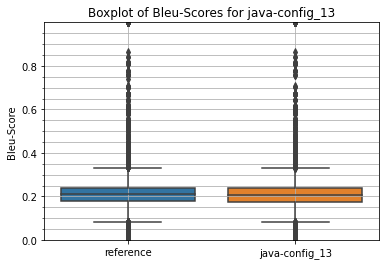

<Figure size 1008x504 with 0 Axes>

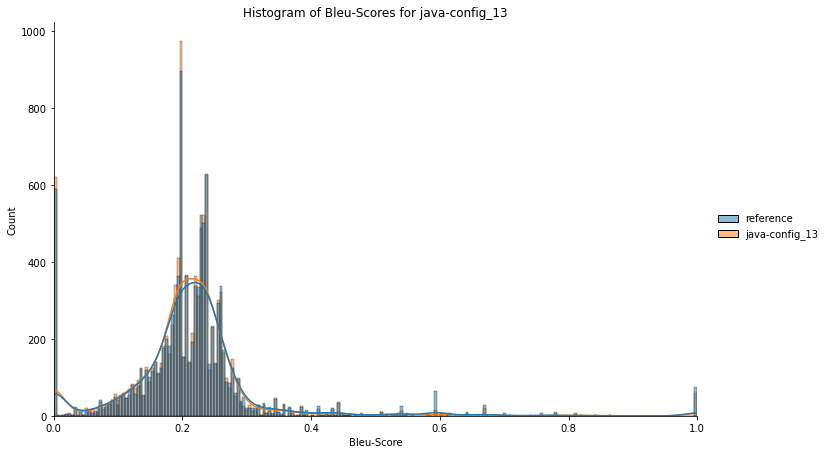

java config_14

Calculating bleus for java-config_14 (10427 entries)
10427 10427


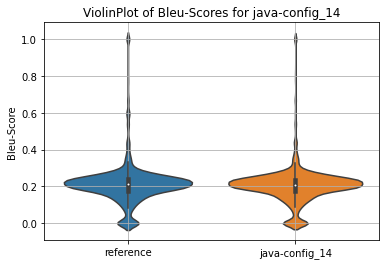

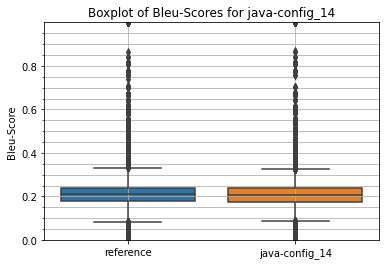

<Figure size 1008x504 with 0 Axes>

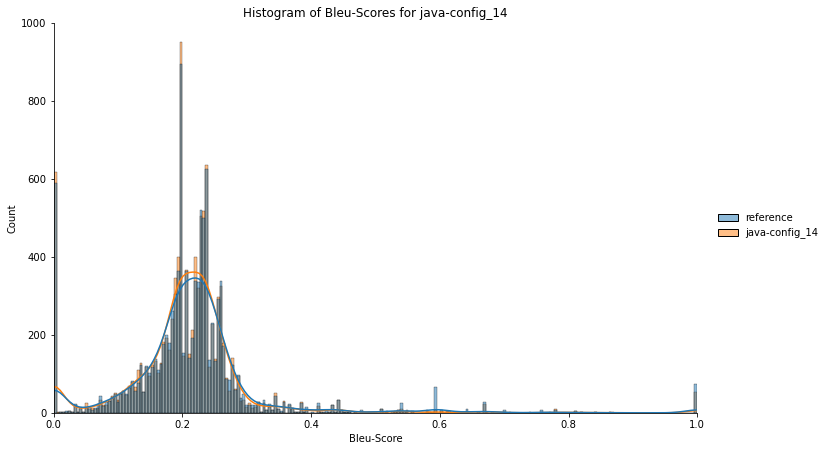

java config_0

Calculating bleus for java-config_0 (10427 entries)
10427 10427


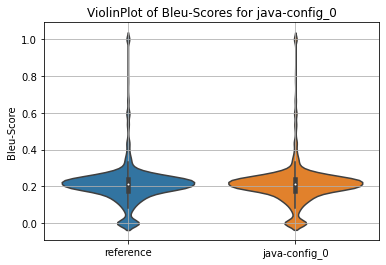

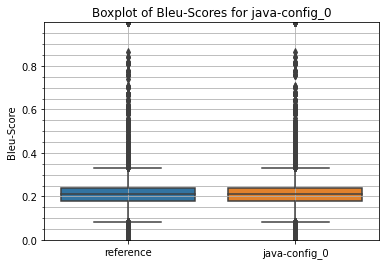

<Figure size 1008x504 with 0 Axes>

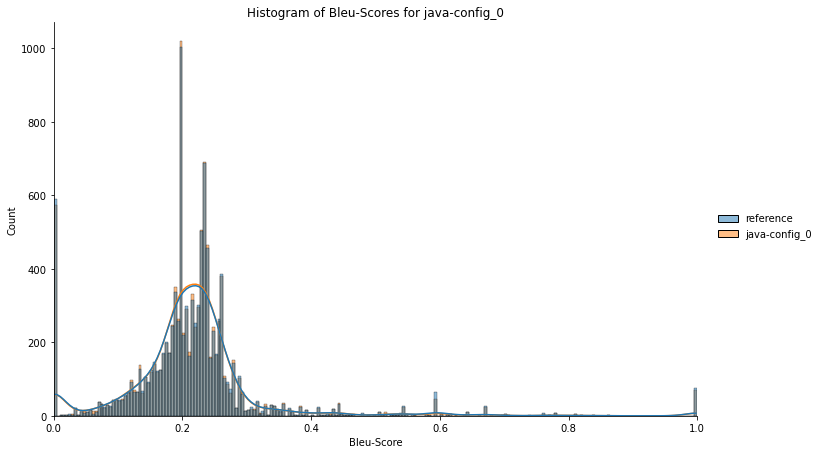

java config_1

Calculating bleus for java-config_1 (10427 entries)
10427 10427


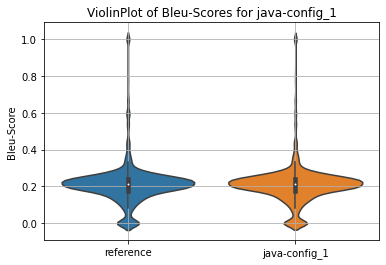

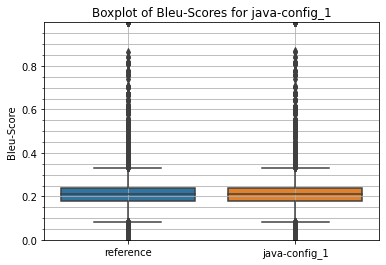

<Figure size 1008x504 with 0 Axes>

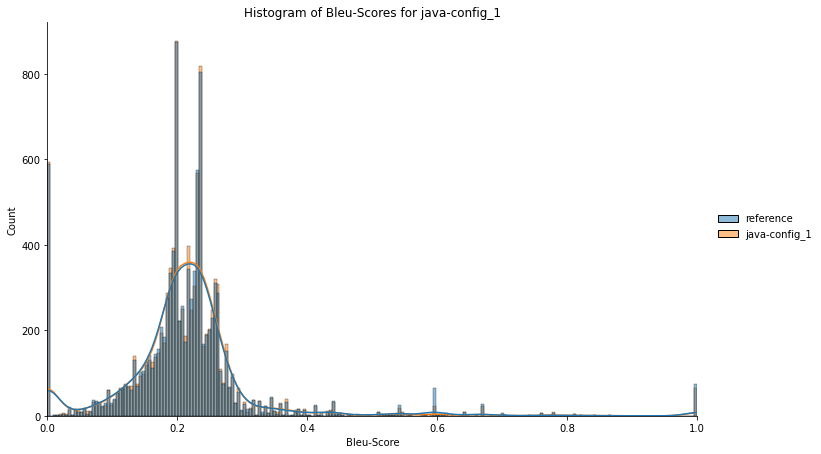

java config_2

Calculating bleus for java-config_2 (10427 entries)
10427 10427


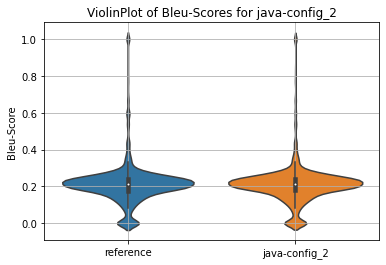

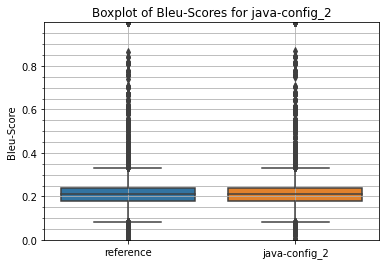

<Figure size 1008x504 with 0 Axes>

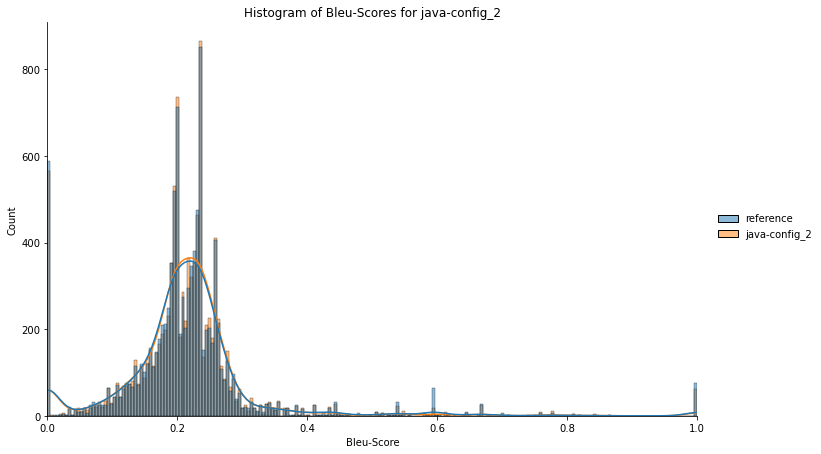

java config_3

Calculating bleus for java-config_3 (10427 entries)
10427 10427


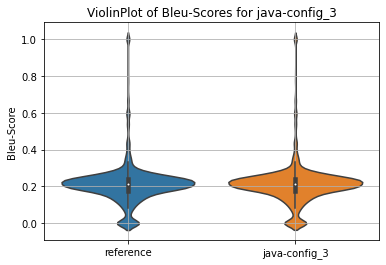

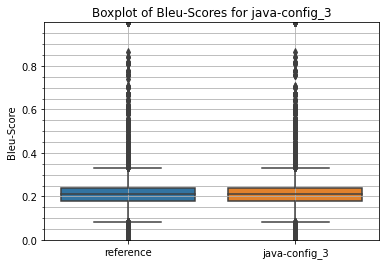

<Figure size 1008x504 with 0 Axes>

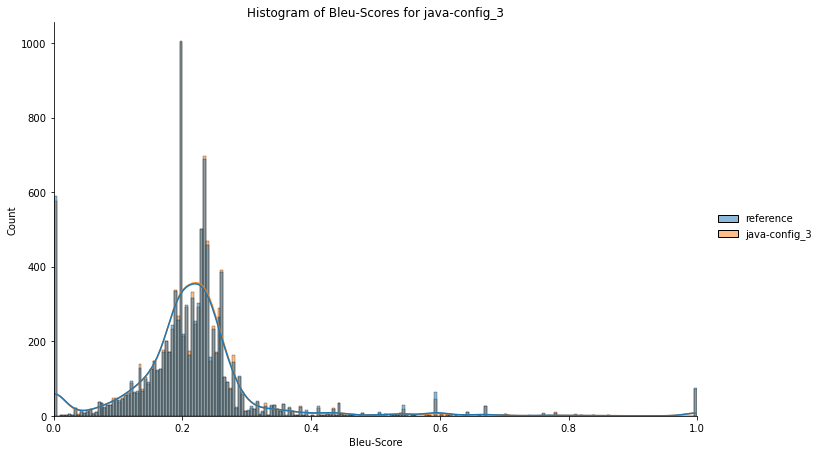

java config_4

Calculating bleus for java-config_4 (10427 entries)
10427 10427


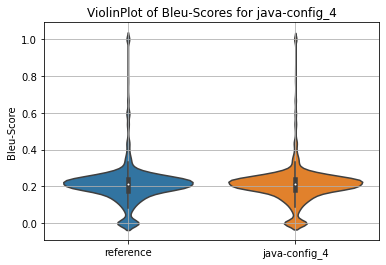

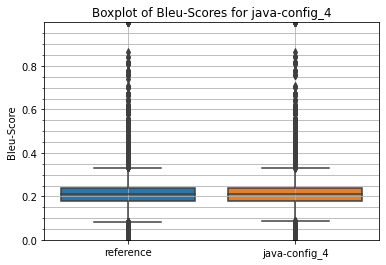

<Figure size 1008x504 with 0 Axes>

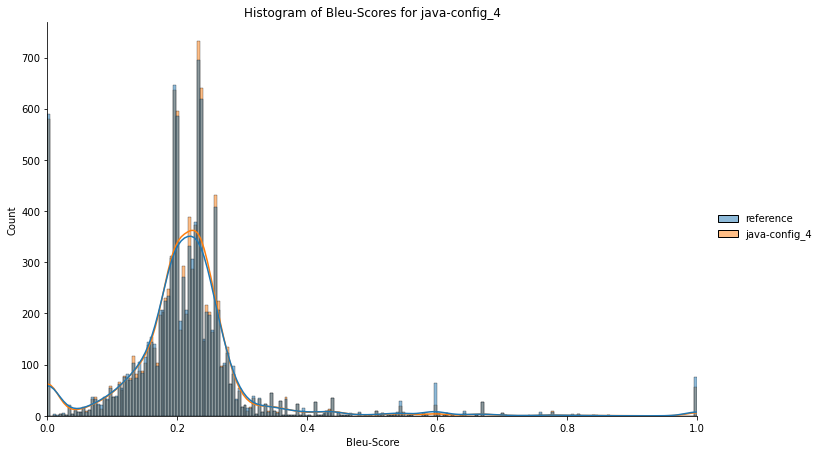

java config_5

Calculating bleus for java-config_5 (10427 entries)
10427 10427


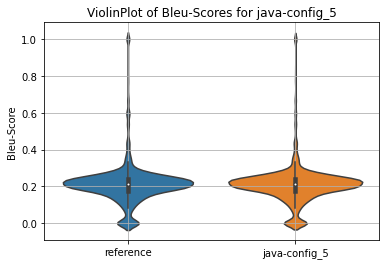

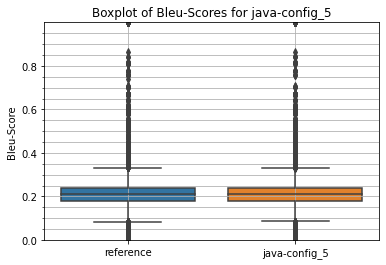

<Figure size 1008x504 with 0 Axes>

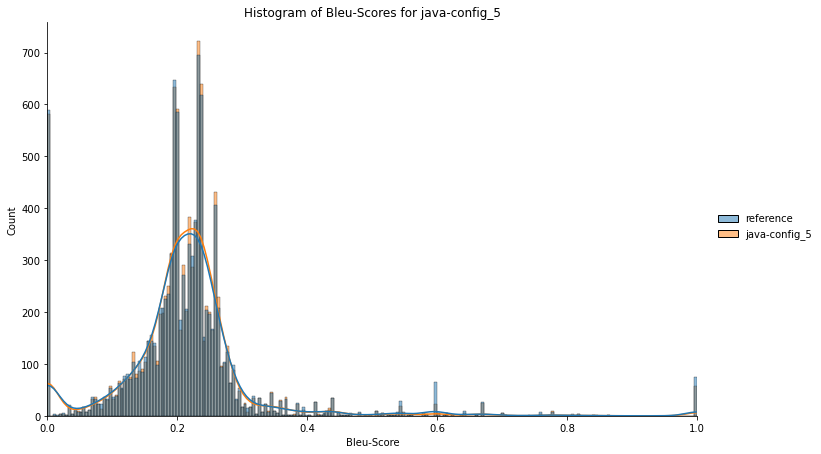

java config_6

Calculating bleus for java-config_6 (10427 entries)
10427 10427


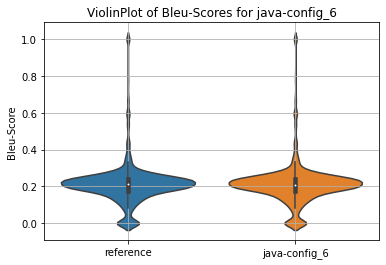

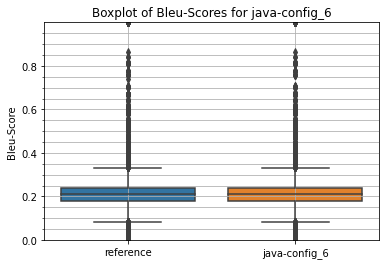

<Figure size 1008x504 with 0 Axes>

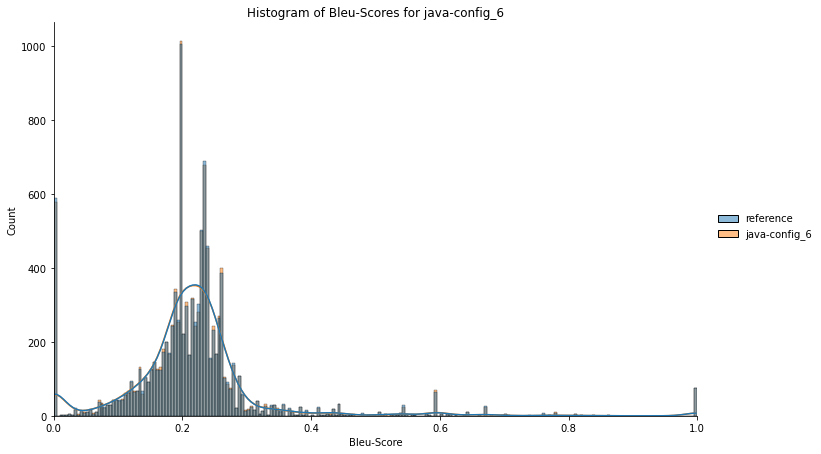

java config_7

Calculating bleus for java-config_7 (10427 entries)
10427 10427


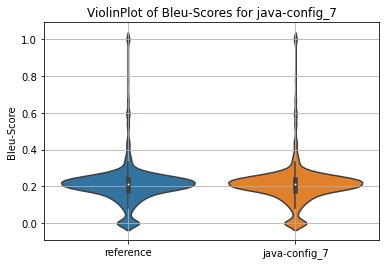

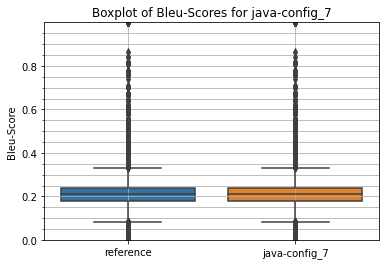

<Figure size 1008x504 with 0 Axes>

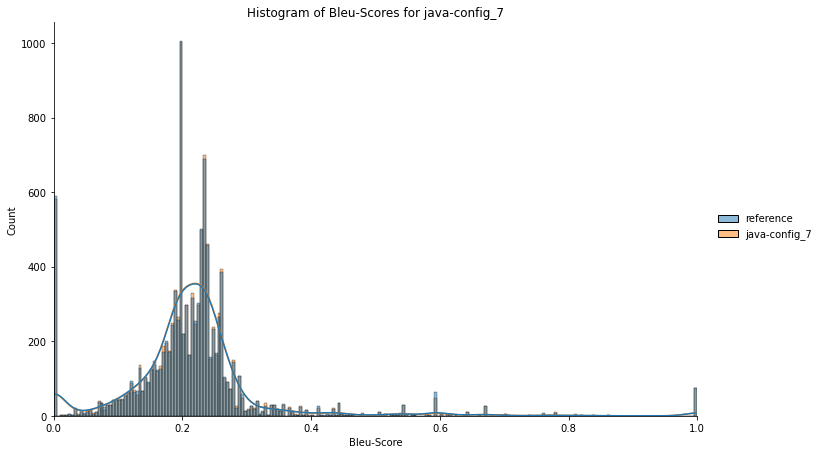

java config_8

Calculating bleus for java-config_8 (10427 entries)
10427 10427


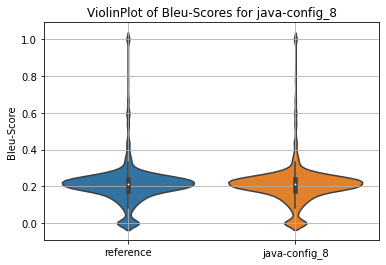

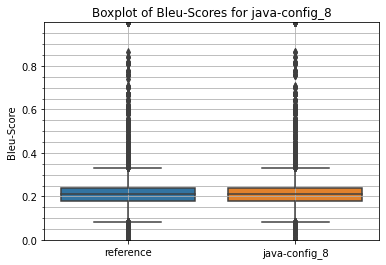

<Figure size 1008x504 with 0 Axes>

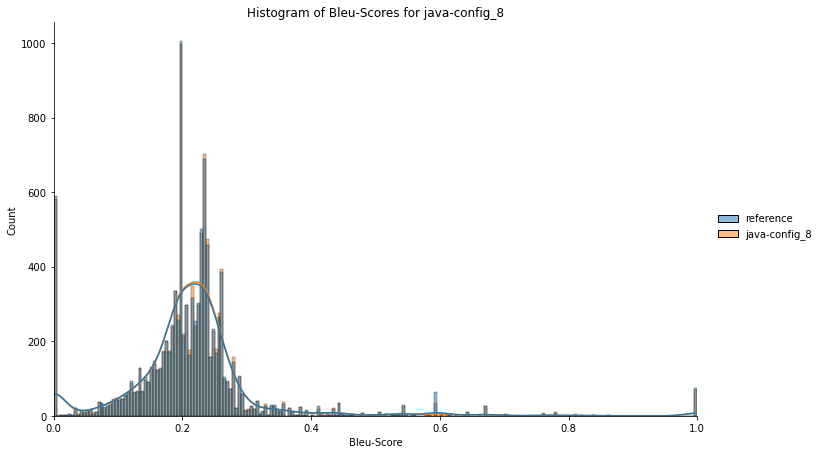

java config_9

Calculating bleus for java-config_9 (10427 entries)
10427 10427


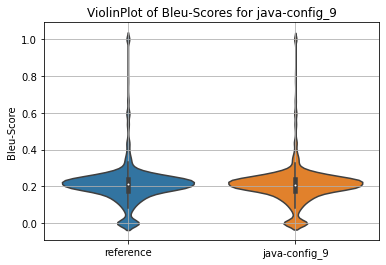

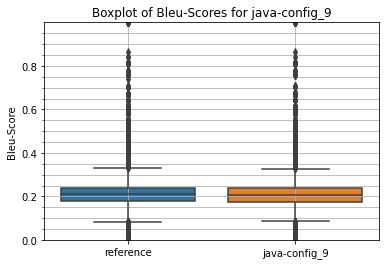

<Figure size 1008x504 with 0 Axes>

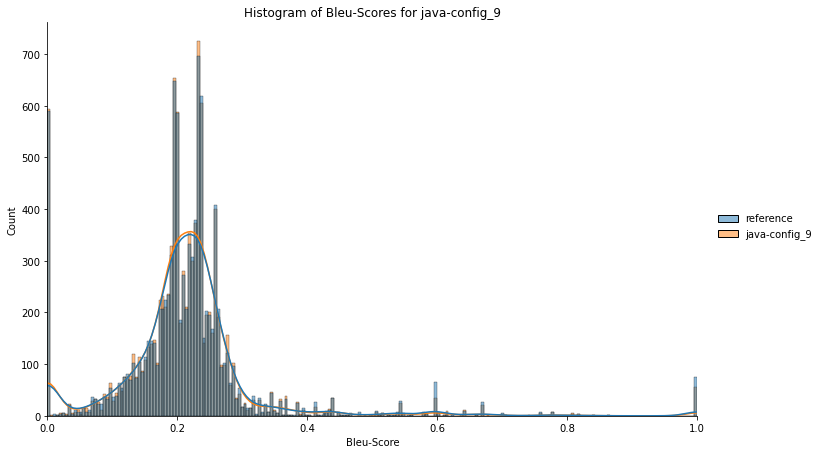

java config_10

Calculating bleus for java-config_10 (10427 entries)
10427 10427


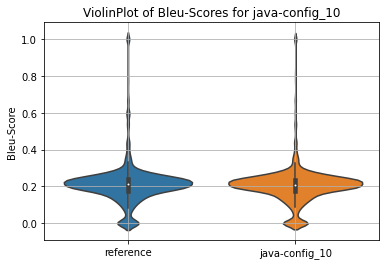

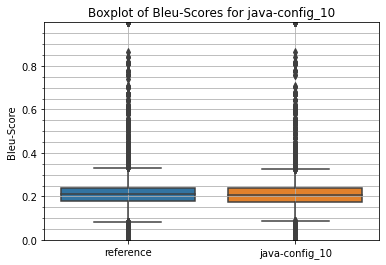

<Figure size 1008x504 with 0 Axes>

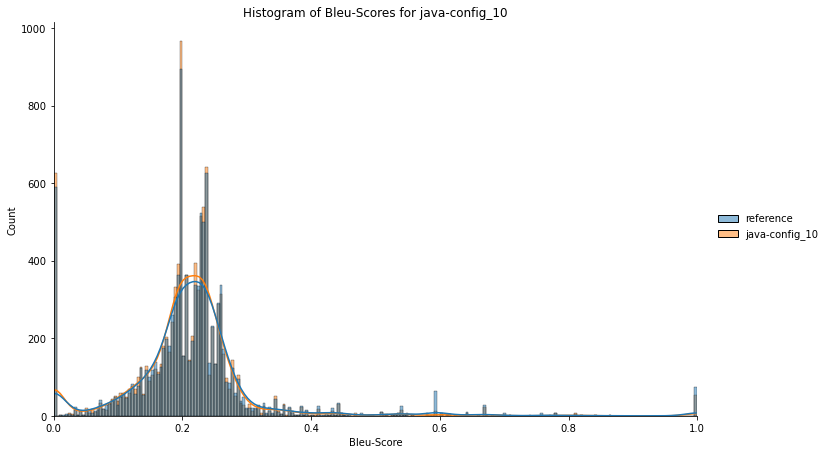

java config_11

Calculating bleus for java-config_11 (10427 entries)
10427 10427


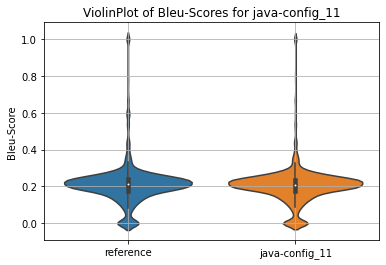

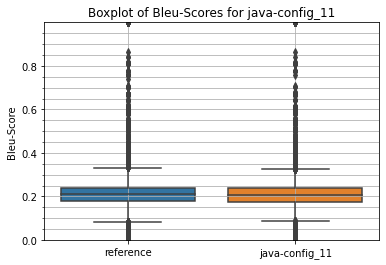

<Figure size 1008x504 with 0 Axes>

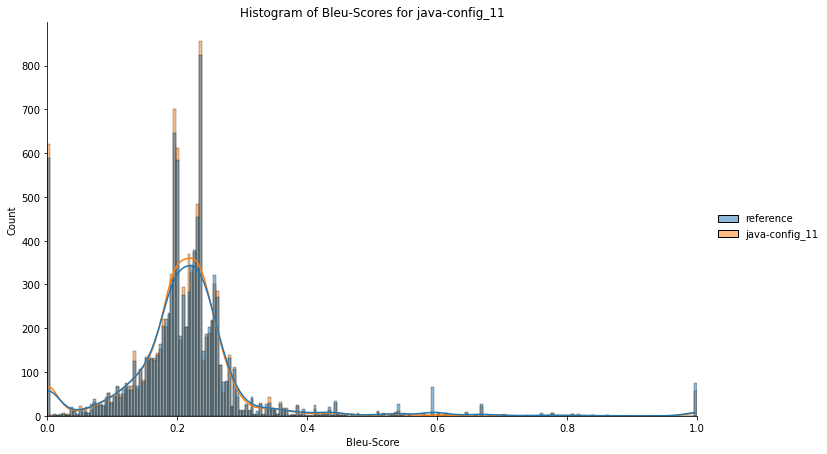

java config_12

Calculating bleus for java-config_12 (10427 entries)
10427 10427


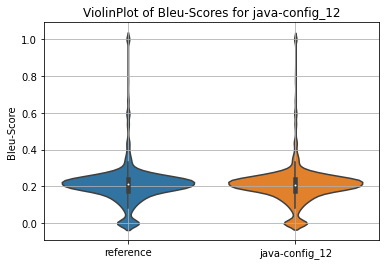

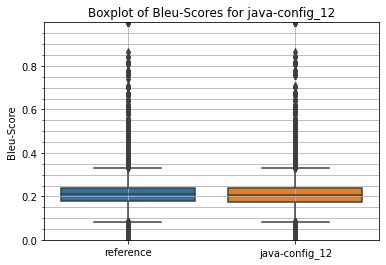

<Figure size 1008x504 with 0 Axes>

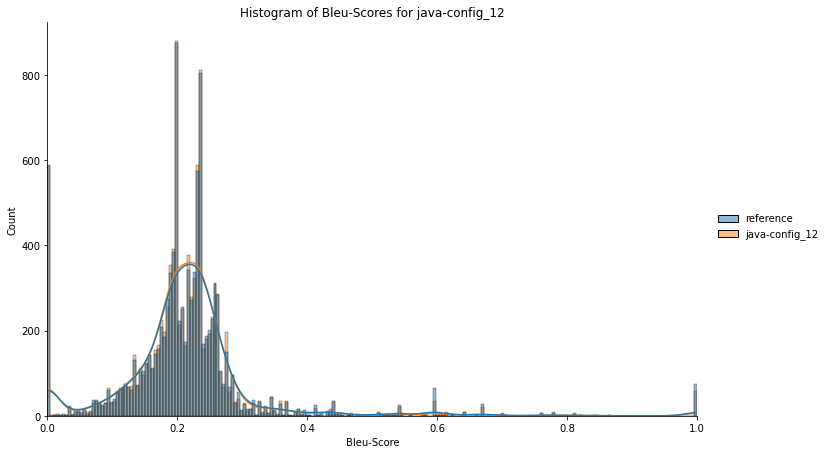

java config_13

Calculating bleus for java-config_13 (10427 entries)
10427 10427


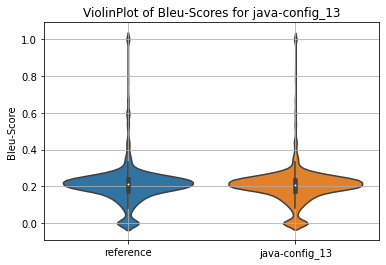

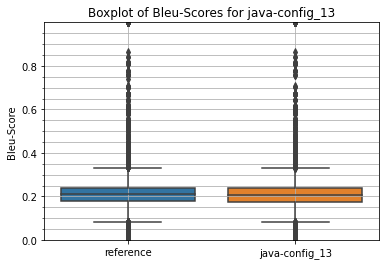

<Figure size 1008x504 with 0 Axes>

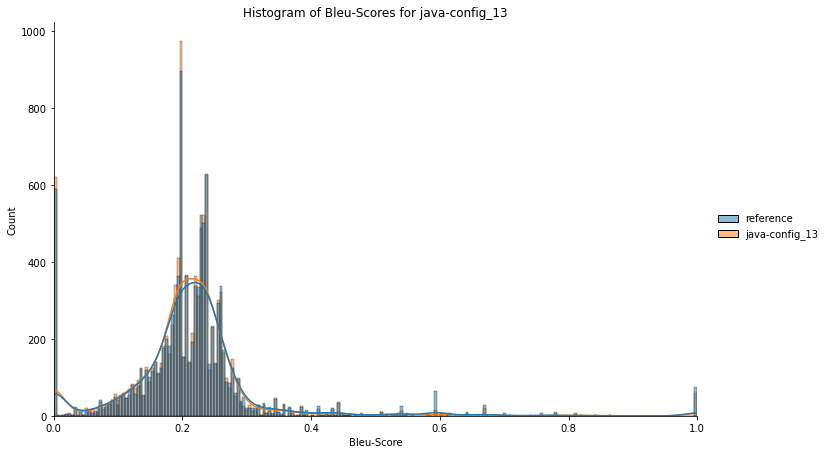

java config_14

Calculating bleus for java-config_14 (10427 entries)
10427 10427


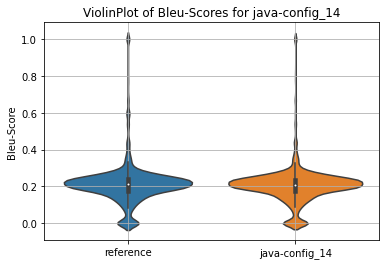

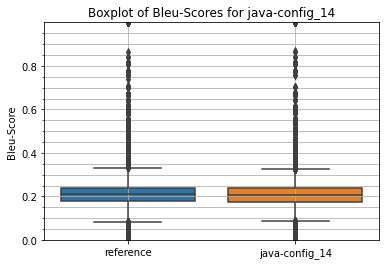

<Figure size 1008x504 with 0 Axes>

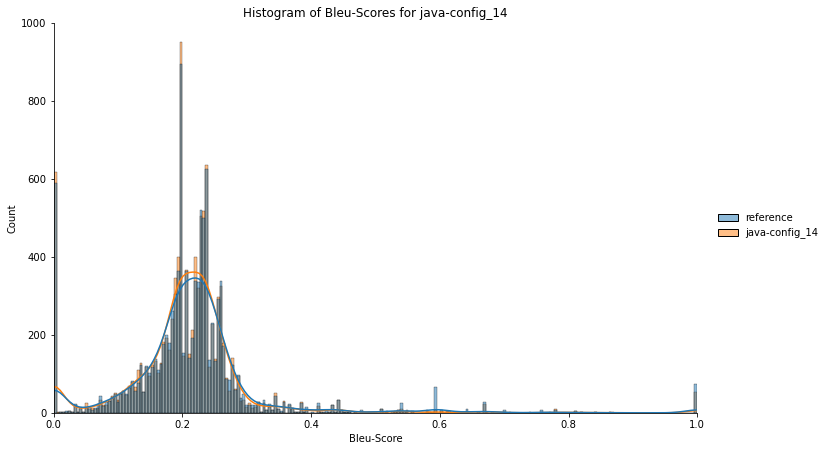

Calculating bleus for python-reference (2167 entries)
python config_0

Calculating bleus for python-config_0 (2167 entries)
2167 2167


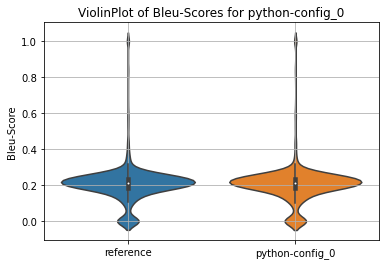

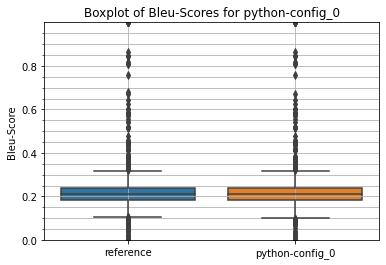

<Figure size 1008x504 with 0 Axes>

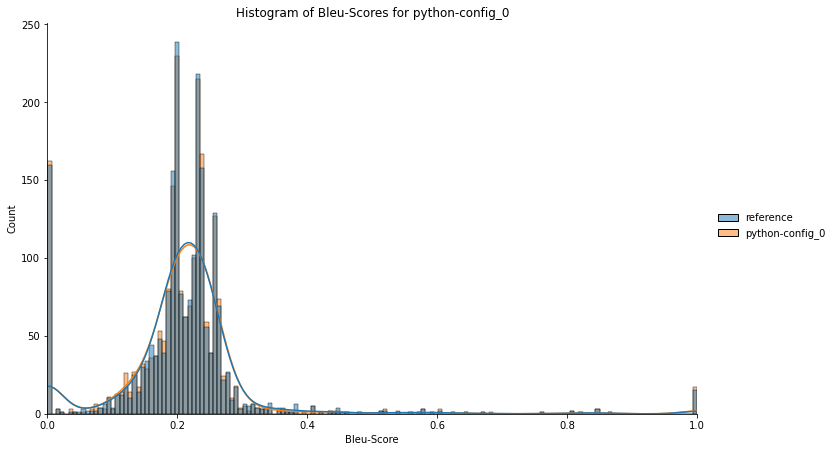

python config_1

Calculating bleus for python-config_1 (2167 entries)
2167 2167


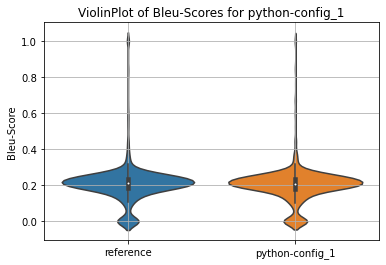

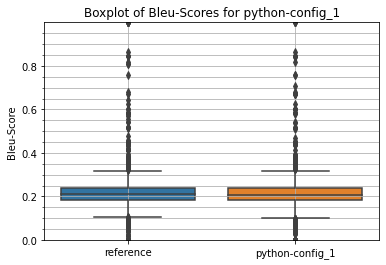

<Figure size 1008x504 with 0 Axes>

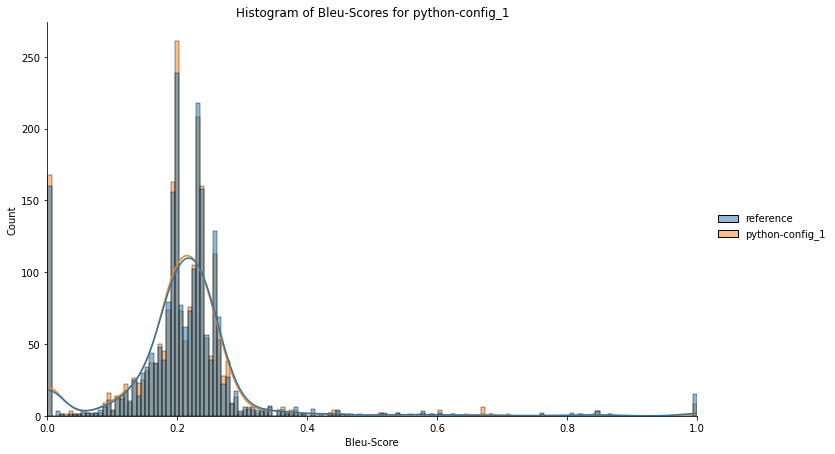

python config_2

Calculating bleus for python-config_2 (2167 entries)
2167 2167


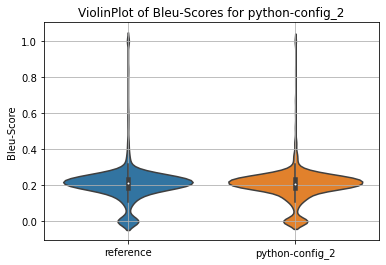

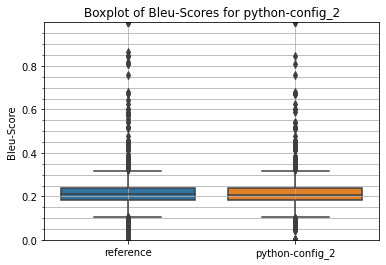

<Figure size 1008x504 with 0 Axes>

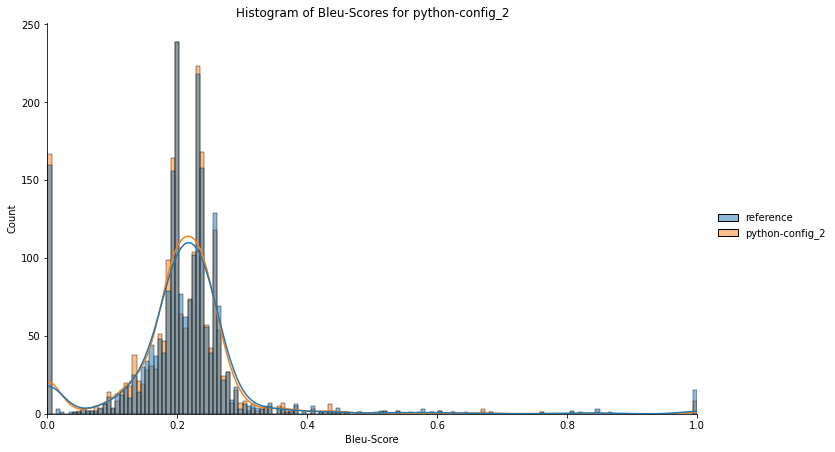

python config_3

Calculating bleus for python-config_3 (2167 entries)
2167 2167


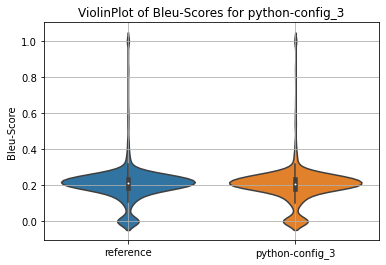

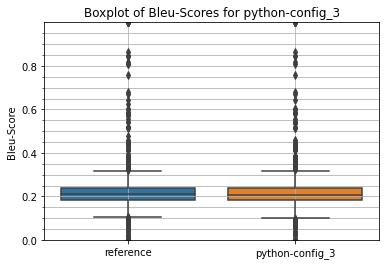

<Figure size 1008x504 with 0 Axes>

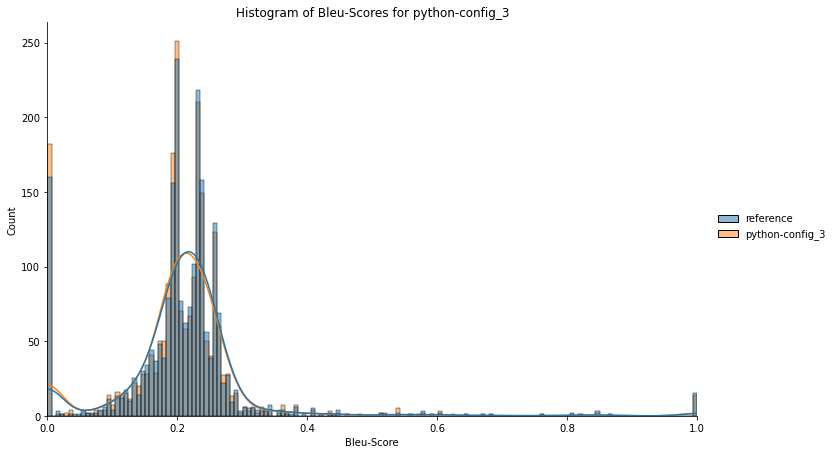

python config_4

Calculating bleus for python-config_4 (2167 entries)
2167 2167


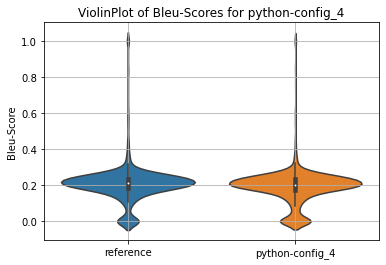

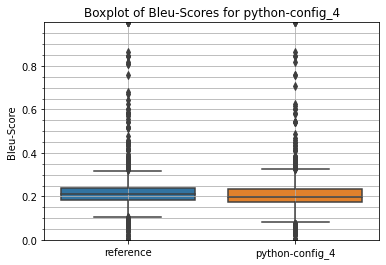

<Figure size 1008x504 with 0 Axes>

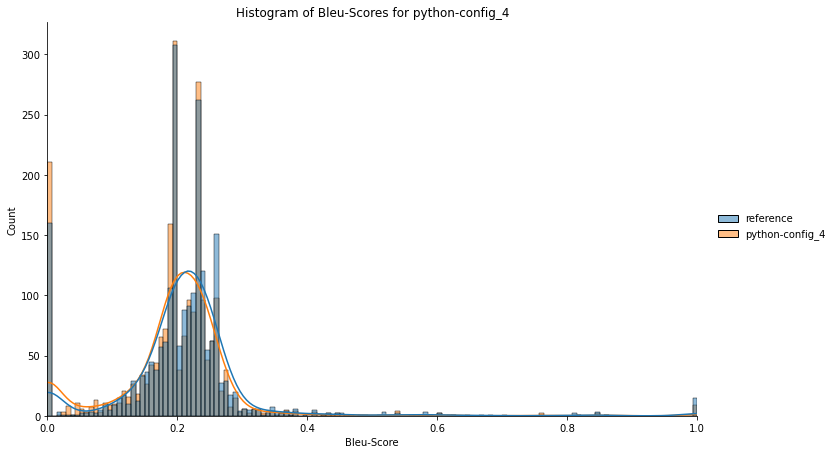

python config_5

Calculating bleus for python-config_5 (2167 entries)
2167 2167


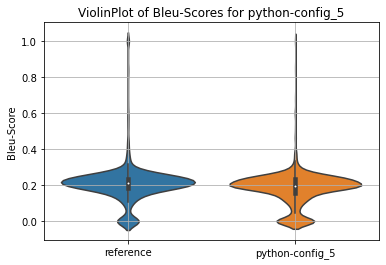

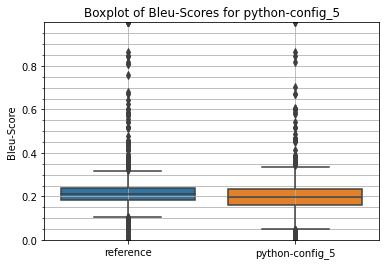

<Figure size 1008x504 with 0 Axes>

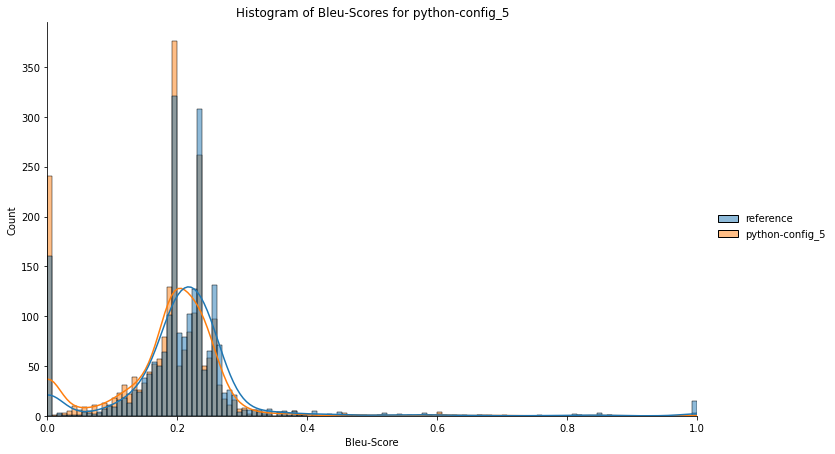

python config_6

Calculating bleus for python-config_6 (2167 entries)
2167 2167


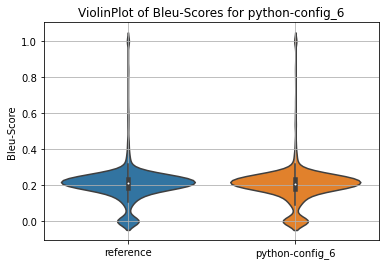

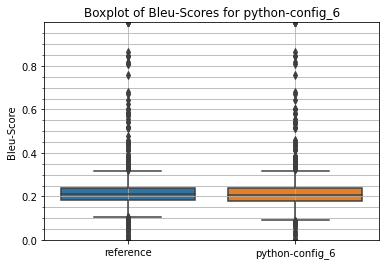

<Figure size 1008x504 with 0 Axes>

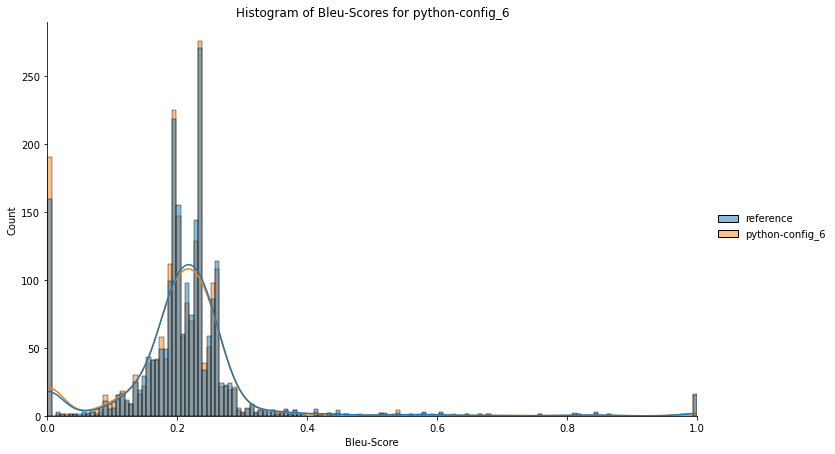

python config_7

Calculating bleus for python-config_7 (2167 entries)
2167 2167


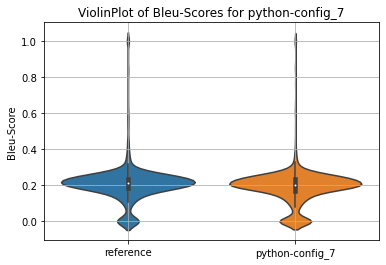

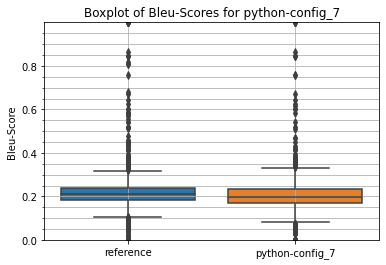

<Figure size 1008x504 with 0 Axes>

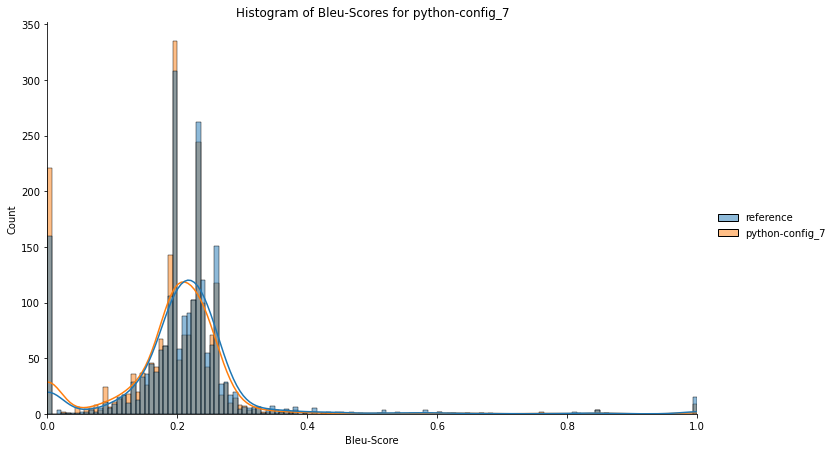

python config_8

Calculating bleus for python-config_8 (2167 entries)
2167 2167


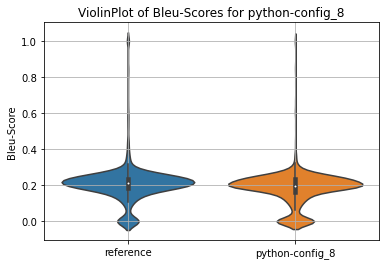

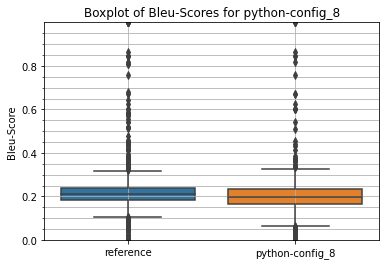

<Figure size 1008x504 with 0 Axes>

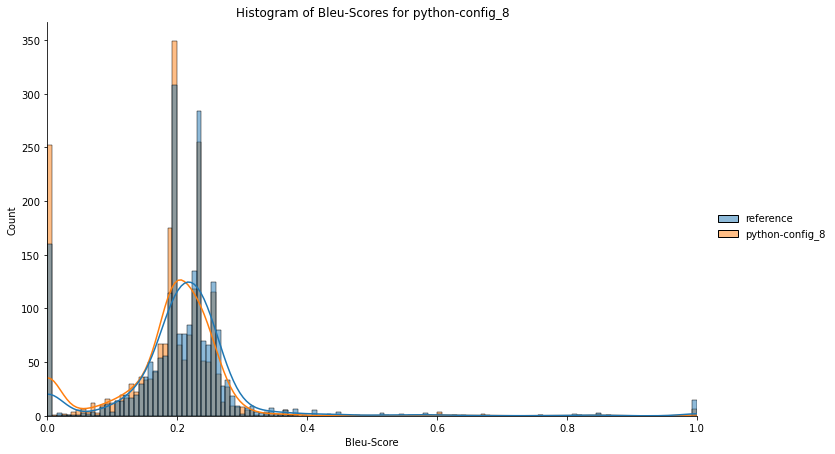

python config_9

Calculating bleus for python-config_9 (2167 entries)
2167 2167


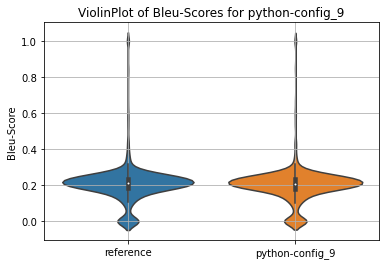

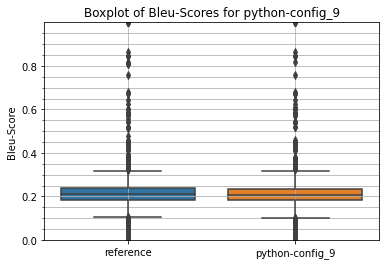

<Figure size 1008x504 with 0 Axes>

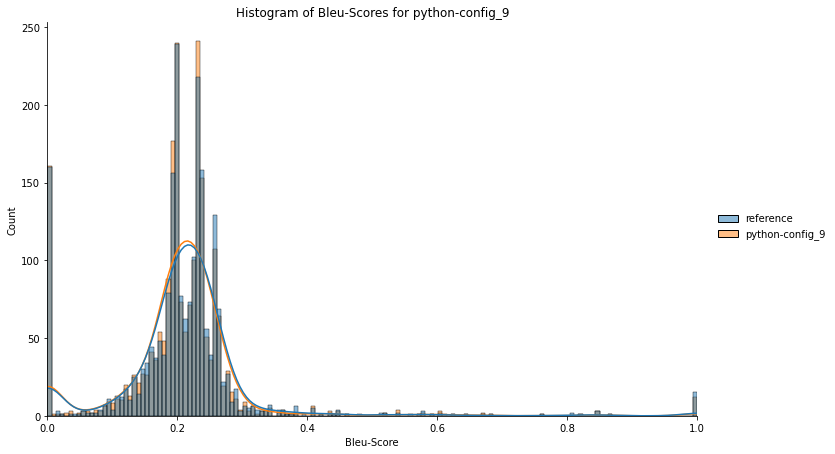

python config_10

Calculating bleus for python-config_10 (2167 entries)
2167 2167


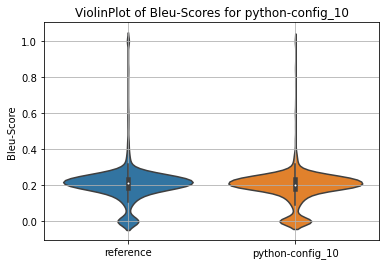

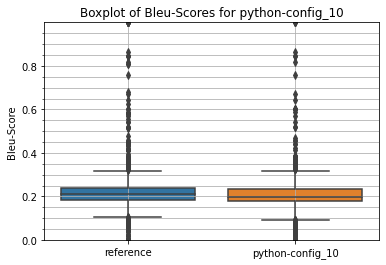

<Figure size 1008x504 with 0 Axes>

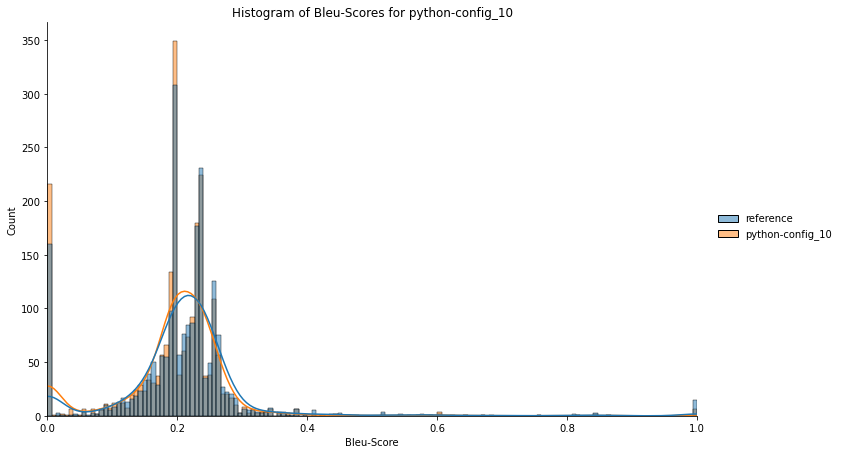

python config_11

Calculating bleus for python-config_11 (2167 entries)
2167 2167


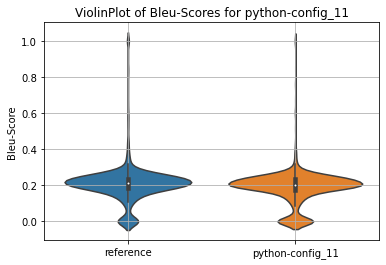

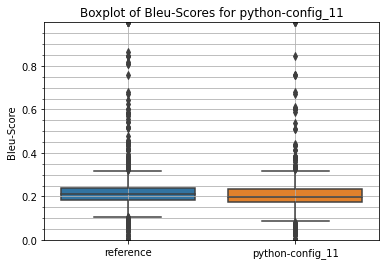

<Figure size 1008x504 with 0 Axes>

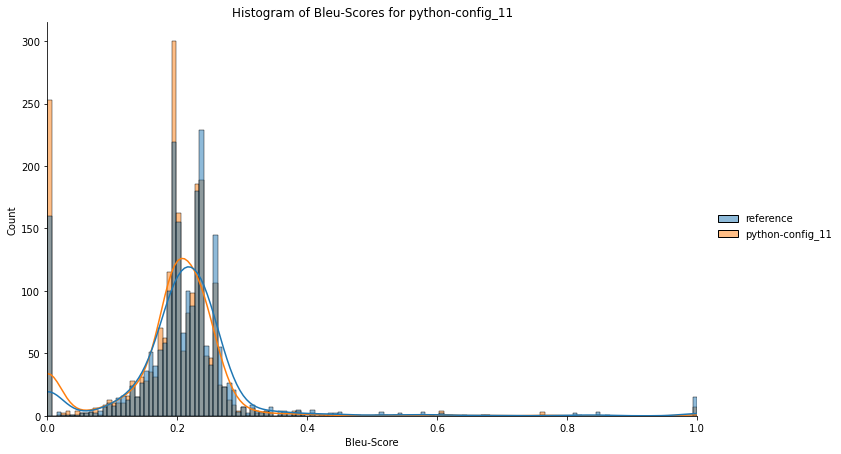

python config_12

Calculating bleus for python-config_12 (2167 entries)
2167 2167


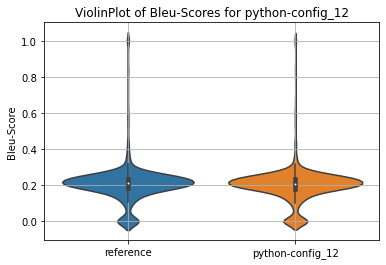

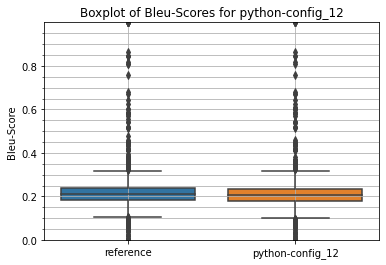

<Figure size 1008x504 with 0 Axes>

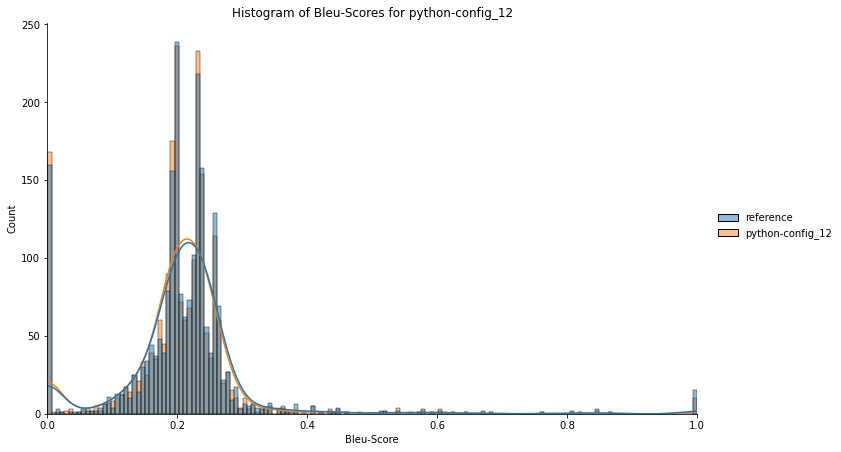

python config_13

Calculating bleus for python-config_13 (2167 entries)
2167 2167


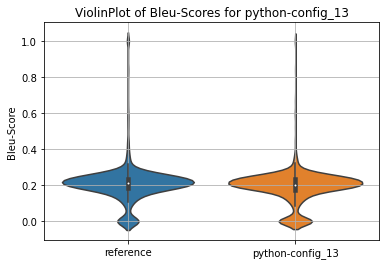

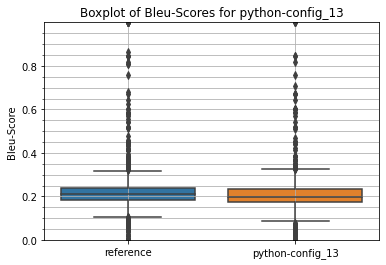

<Figure size 1008x504 with 0 Axes>

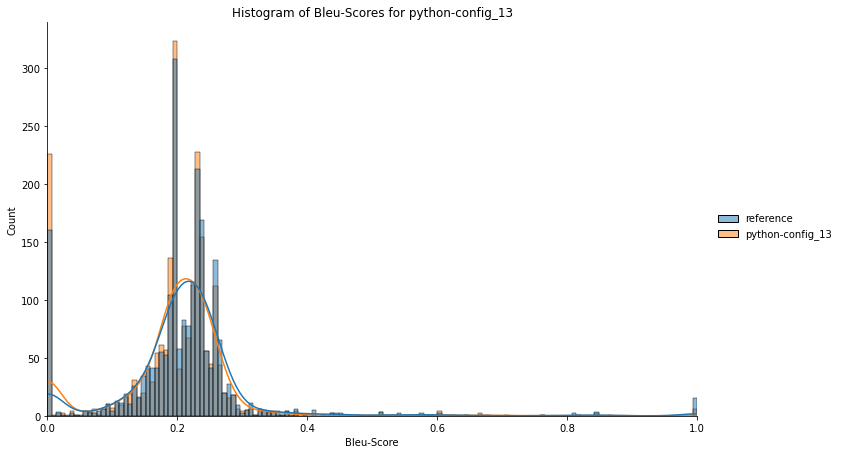

python config_14

Calculating bleus for python-config_14 (2167 entries)
2167 2167


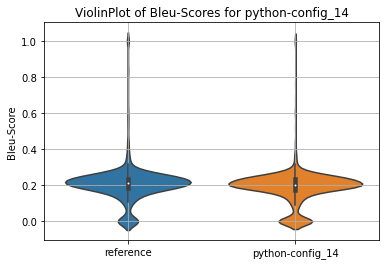

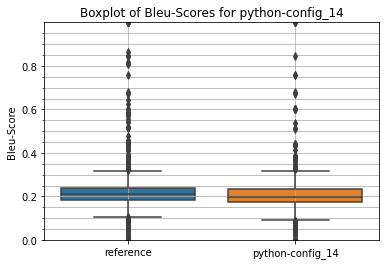

<Figure size 1008x504 with 0 Axes>

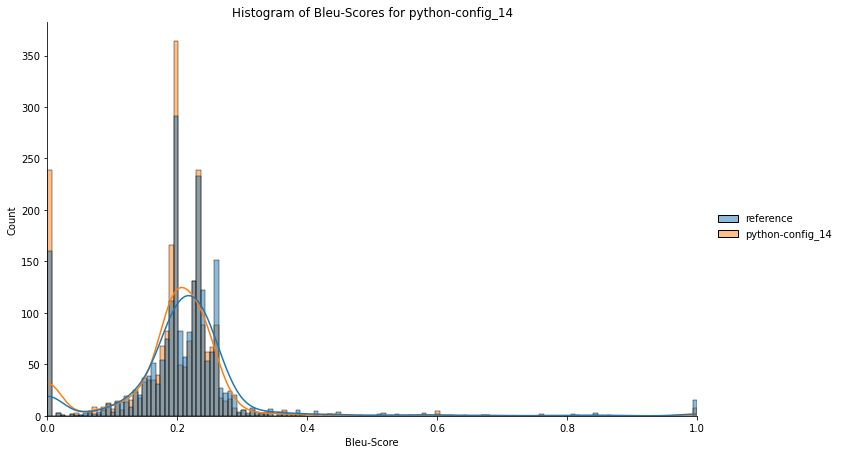

python config_0

Calculating bleus for python-config_0 (2167 entries)
2167 2167


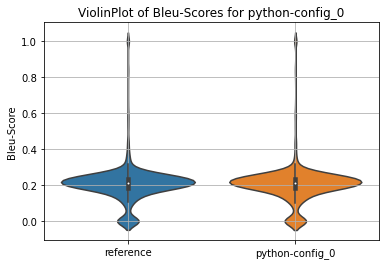

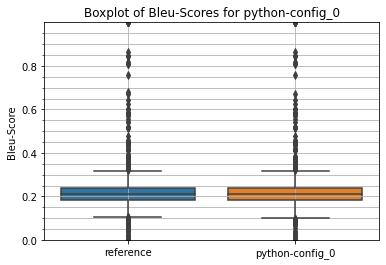

<Figure size 1008x504 with 0 Axes>

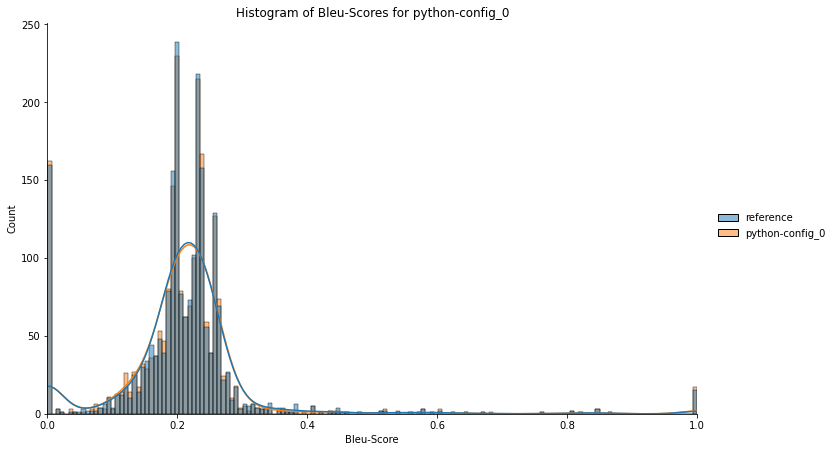

python config_1

Calculating bleus for python-config_1 (2167 entries)
2167 2167


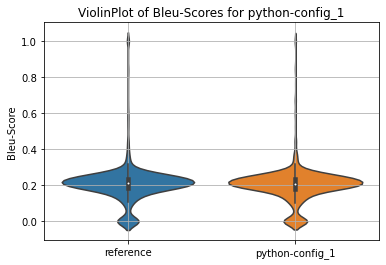

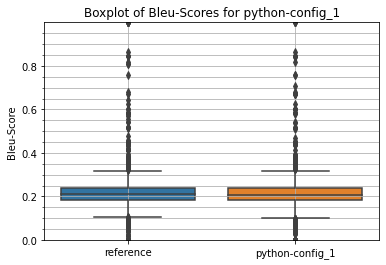

<Figure size 1008x504 with 0 Axes>

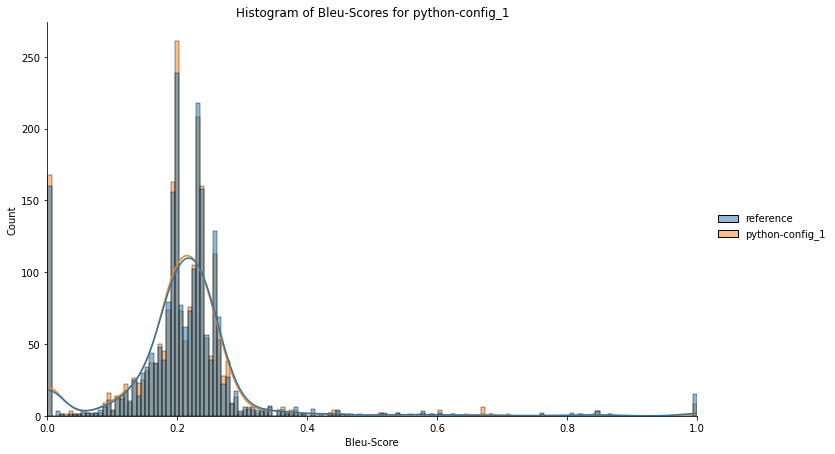

python config_2

Calculating bleus for python-config_2 (2167 entries)
2167 2167


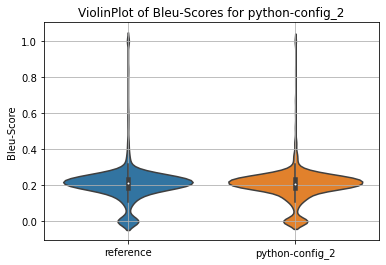

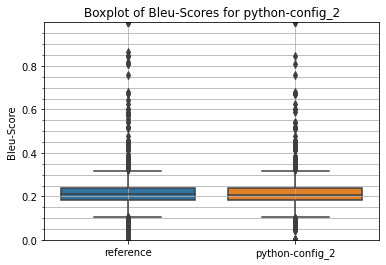

<Figure size 1008x504 with 0 Axes>

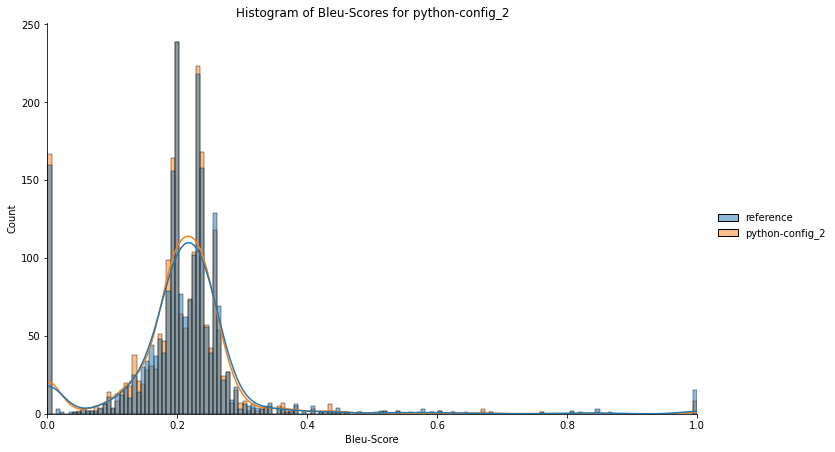

python config_3

Calculating bleus for python-config_3 (2167 entries)
2167 2167


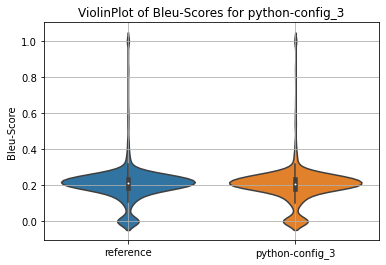

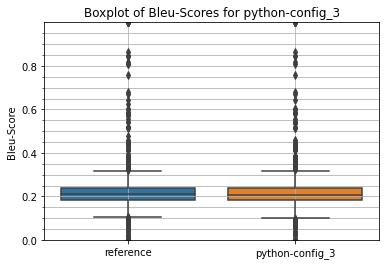

<Figure size 1008x504 with 0 Axes>

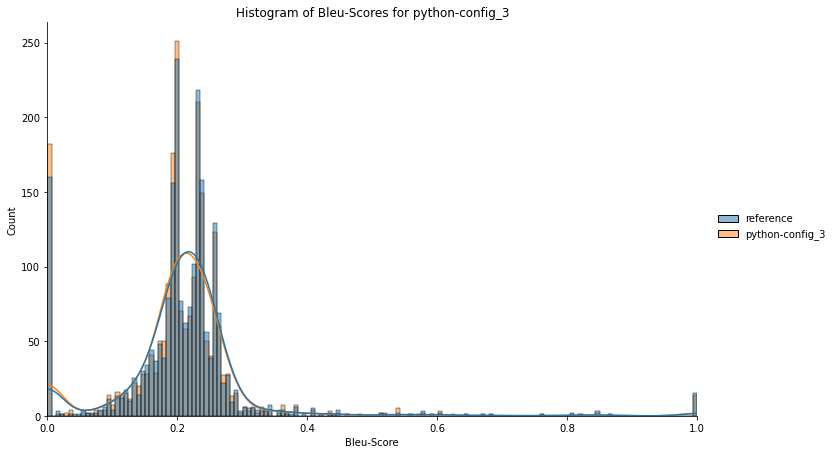

python config_4

Calculating bleus for python-config_4 (2167 entries)
2167 2167


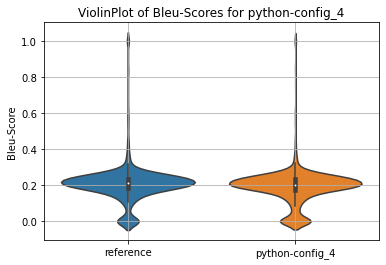

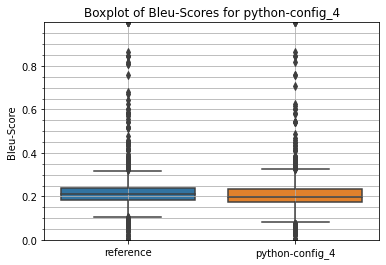

<Figure size 1008x504 with 0 Axes>

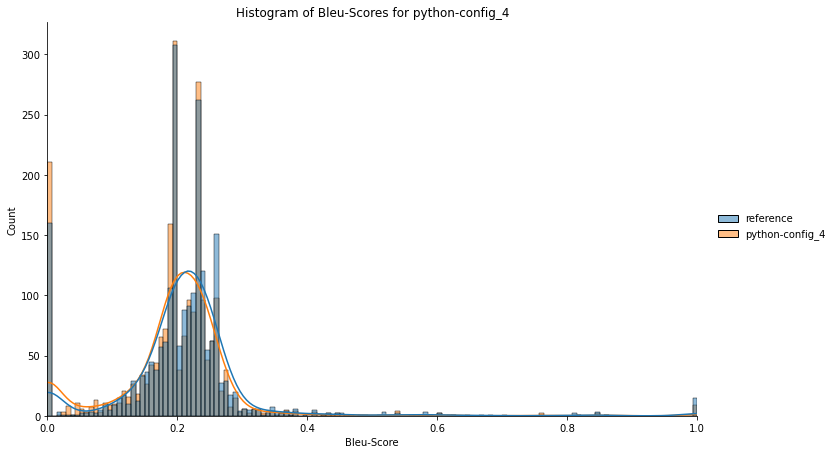

python config_5

Calculating bleus for python-config_5 (2167 entries)
2167 2167


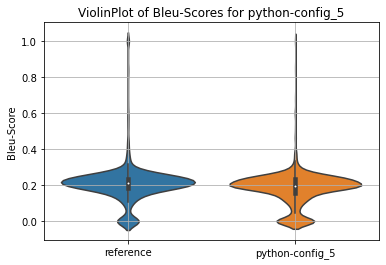

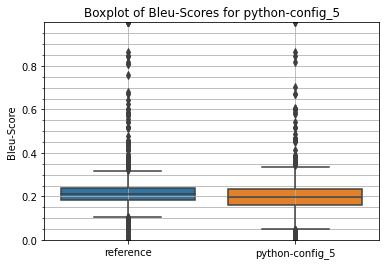

<Figure size 1008x504 with 0 Axes>

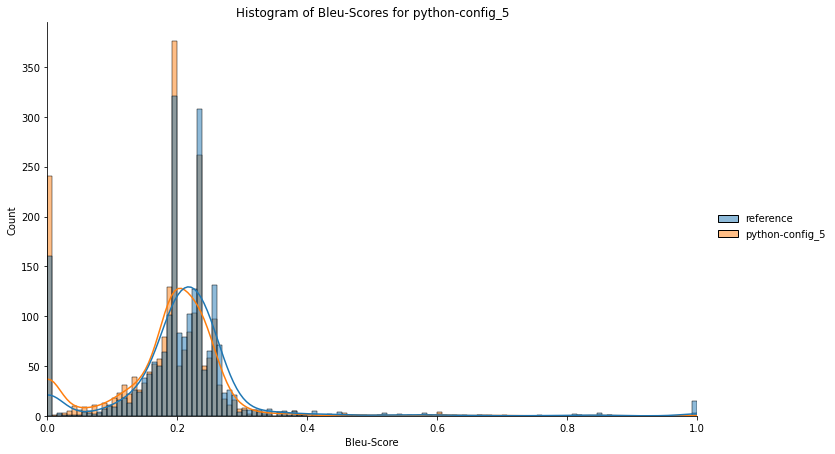

python config_6

Calculating bleus for python-config_6 (2167 entries)
2167 2167


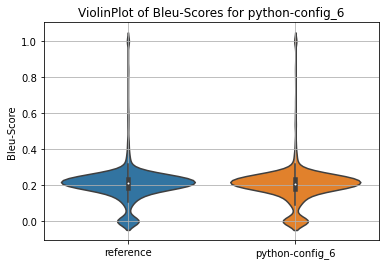

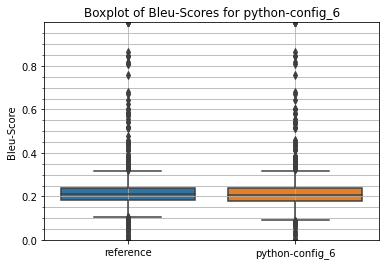

<Figure size 1008x504 with 0 Axes>

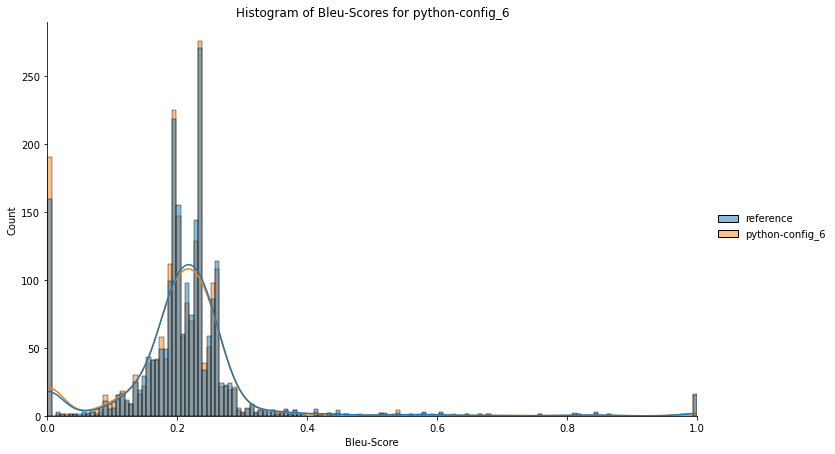

python config_7

Calculating bleus for python-config_7 (2167 entries)
2167 2167


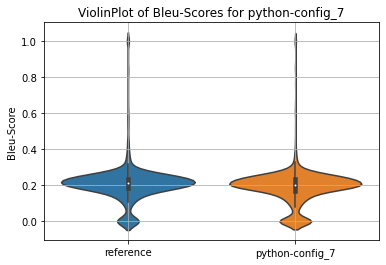

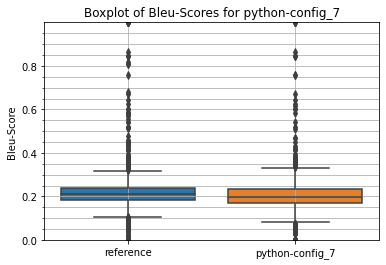

<Figure size 1008x504 with 0 Axes>

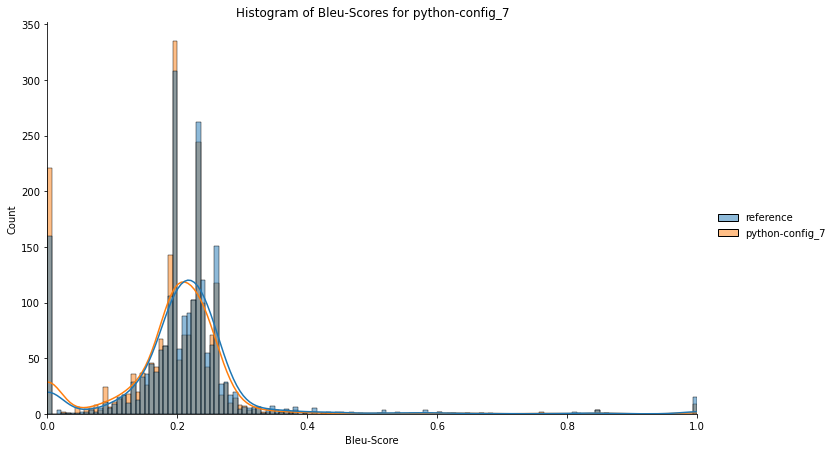

python config_8

Calculating bleus for python-config_8 (2167 entries)
2167 2167


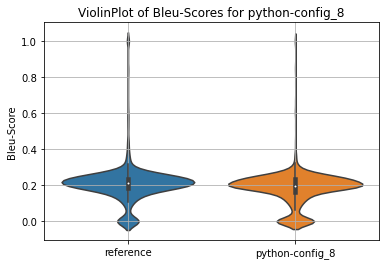

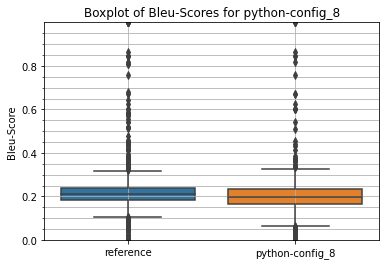

<Figure size 1008x504 with 0 Axes>

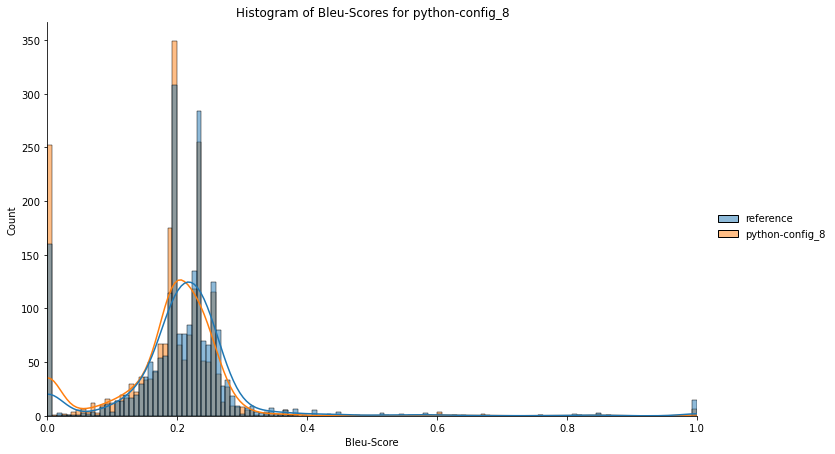

python config_9

Calculating bleus for python-config_9 (2167 entries)
2167 2167


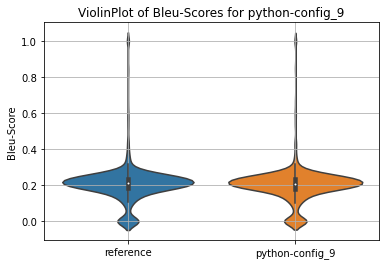

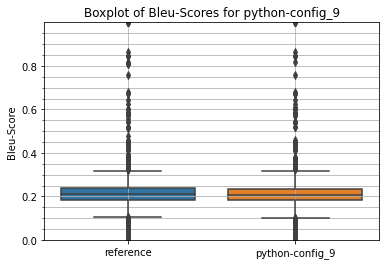

<Figure size 1008x504 with 0 Axes>

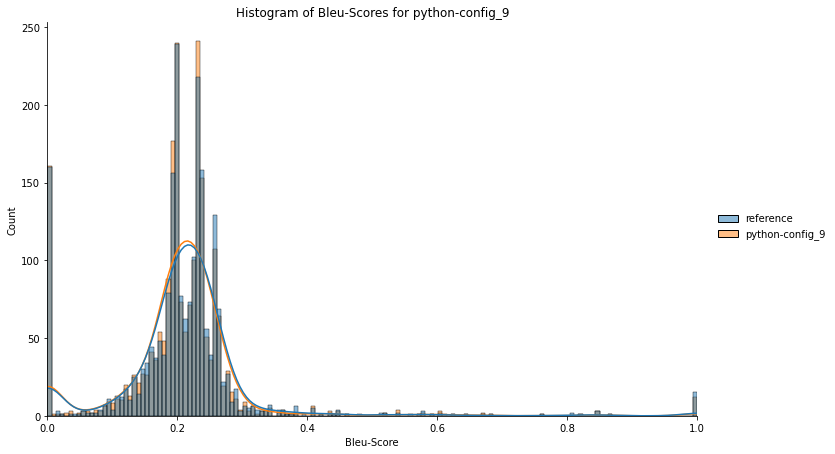

python config_10

Calculating bleus for python-config_10 (2167 entries)
2167 2167


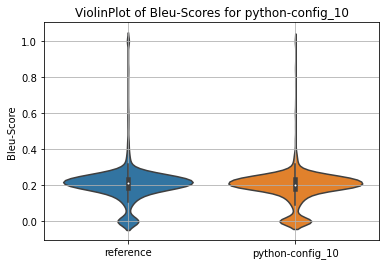

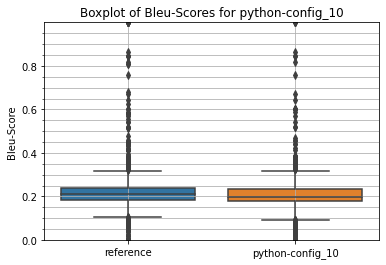

<Figure size 1008x504 with 0 Axes>

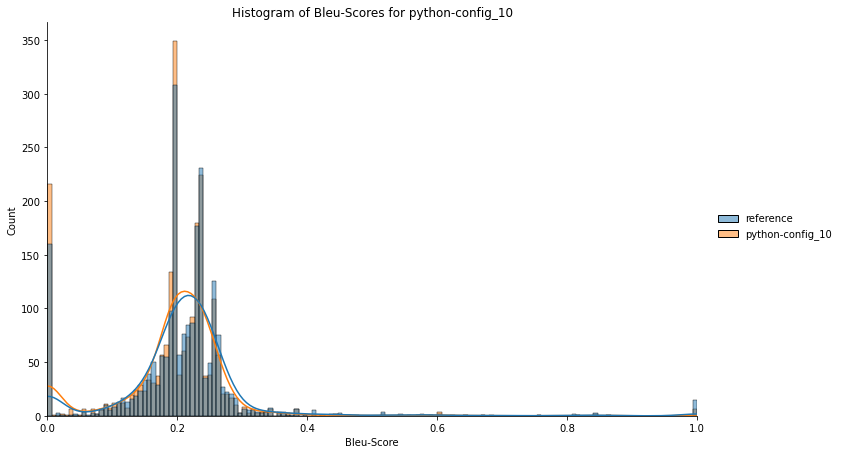

python config_11

Calculating bleus for python-config_11 (2167 entries)
2167 2167


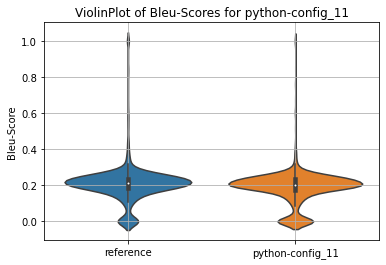

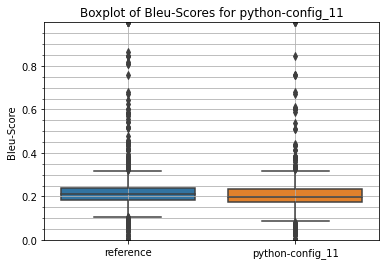

<Figure size 1008x504 with 0 Axes>

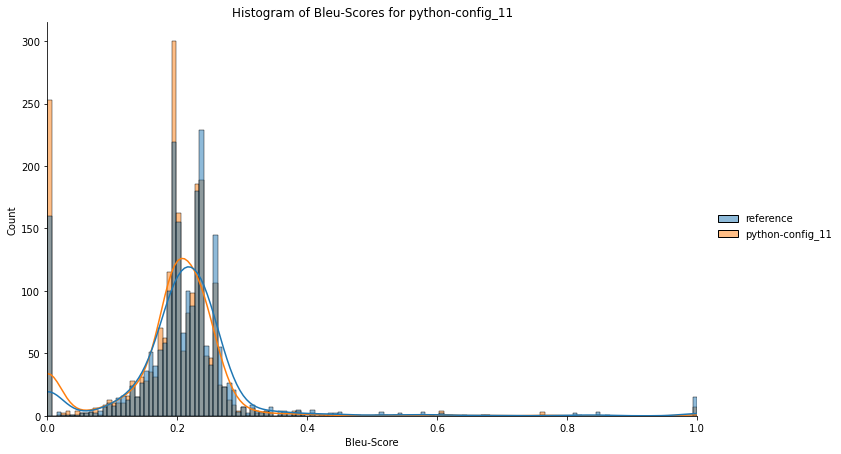

python config_12

Calculating bleus for python-config_12 (2167 entries)
2167 2167


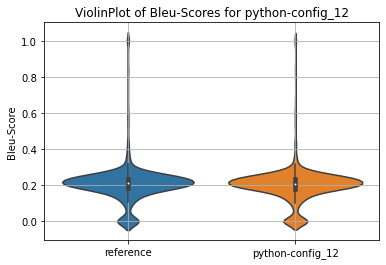

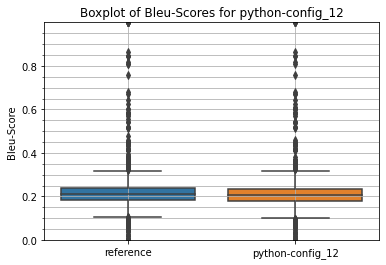

<Figure size 1008x504 with 0 Axes>

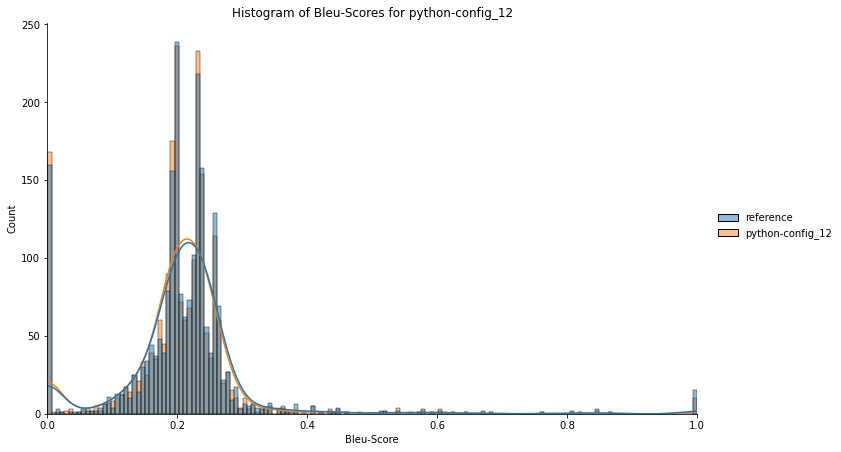

python config_13

Calculating bleus for python-config_13 (2167 entries)
2167 2167


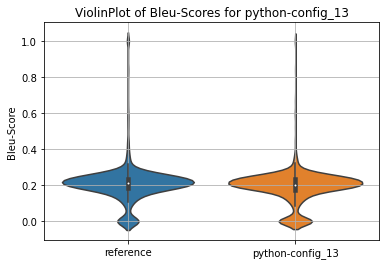

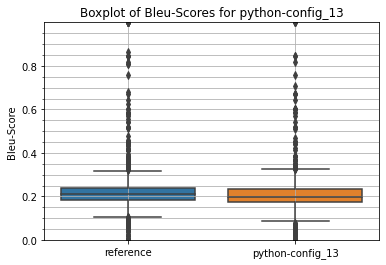

<Figure size 1008x504 with 0 Axes>

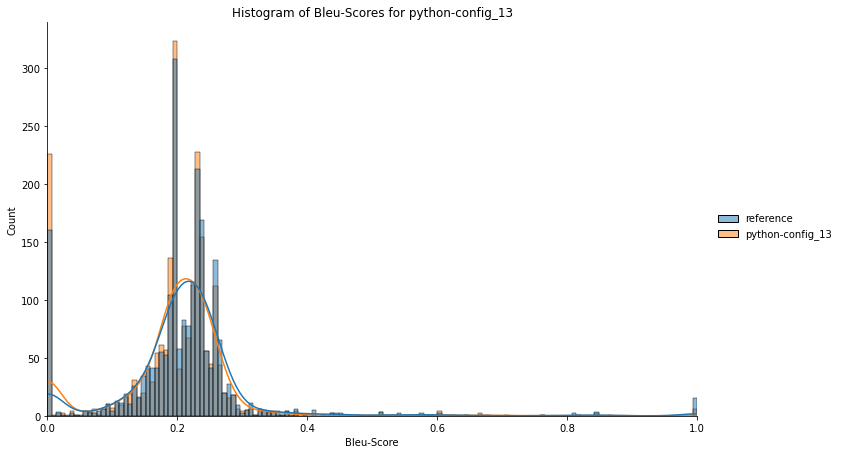

python config_14

Calculating bleus for python-config_14 (2167 entries)
2167 2167


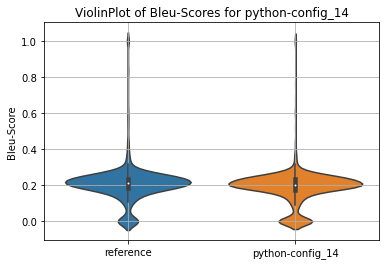

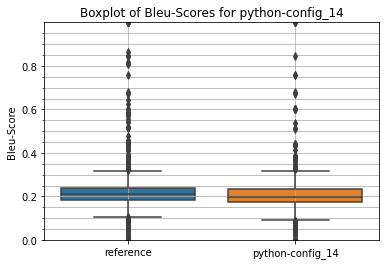

<Figure size 1008x504 with 0 Axes>

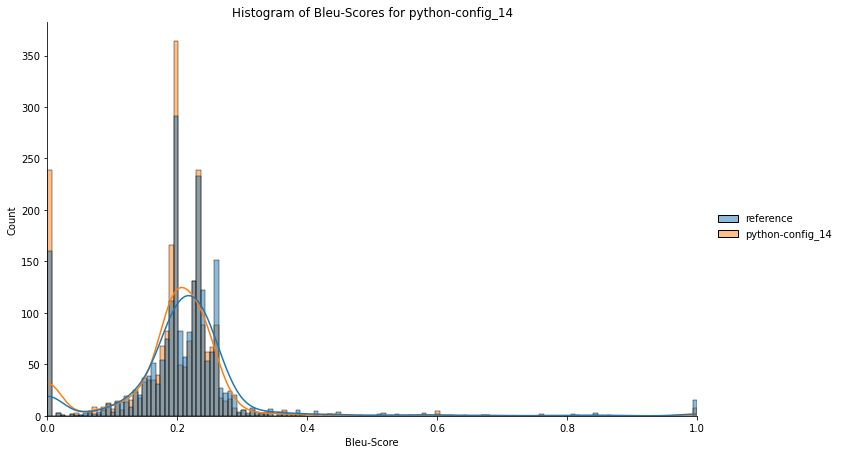

CPU times: user 5min 47s, sys: 13.3 s, total: 6min 1s
Wall time: 4min 11s


In [14]:
%%time

# For every entry in the config, calculate bleu and make comparison plots
for prefix in results.keys():
    # Calculate the reference bleus and store them
    bleus_reference_data = calculate_bleus(results,prefix,"reference")
    results[prefix]["reference"]["bleu_values"]=bleus_reference_data
    for (p,conf) in non_reference_configs:
        print(prefix,conf)
        print()
        bleus_data = calculate_bleus(results,prefix,conf)
        # Set the bleu values to only calculate them once
        results[prefix][conf]["bleu_values"]=bleus_data
        # Use the bleu-data to make some plots
        plot_bleu_violinplot(bleus_data,bleus_reference_data,f"{prefix}-{conf}")
        plot_bleu_boxplot(bleus_data,bleus_reference_data,f"{prefix}-{conf}")
        plot_bleu_histogram(bleus_data,bleus_reference_data,f"{prefix}-{conf}")
        # Delete the bleu data to free some memory and not collide on names
        del bleus_data
    del bleus_reference_data

## Samples

Before the samples can be inspected, the items need to be re-indexed. 
While all config_results are in the reference_results, there might is an issue with the data being shuffeld. 

To fix this, a reindexing is done.

In [15]:
%%time
#Reindexing Pseudocode

def lookup_index(sentence, comparison_dict):
    for (gold_key,gold_value) in comparison_dict.items():
        if sentence == gold_value:
            return gold_key
    return -1

# Pseudocode:
# For each config (that is not reference)
    # Create a lookup of reference_gold_index -> config_gold_index
    # Invert the lookup 
    # Make a new dictionary where
        # For every key of the config_gold
        # lookup the key of the reference_gold
        # And fill it with {reference_gold_key : config_gold_value}
        # Do the same with the non-gold results
        # Fill it with {reference_gold_key : config_result_value}
    # Set result[config_X]["gold_results"] to the newly created, matching index one 
    # same for non-gold-results

for (prefix,config) in non_reference_configs:
    keyMapping={}
    for (k,v) in results[prefix][config]["gold_results"].items():
        gk = lookup_index(v,results[prefix]["reference"]["gold_results"])
        keyMapping[k]=gk
    new_gold_results={}
    new_results={}
    for (config_key,gold_key) in keyMapping.items():
        if gold_key != -1:
            new_gold_results[gold_key]=results[prefix][config]["gold_results"][config_key]
            new_results[gold_key]=results[prefix][config]["results"][config_key]
    results[prefix][config]["gold_results"]=new_gold_results
    results[prefix][config]["results"]=new_results

CPU times: user 32.2 s, sys: 497 ms, total: 32.7 s
Wall time: 33.4 s


In [16]:
# Short Example that the reindexing worked and looks about right
sample_index = 250
print(results["java"]["reference"]["gold_results"][sample_index] )
print()
print(results["java"]["reference"]["results"][sample_index])
print(results["java"]["config_2"]["results"][sample_index])
del sample_index

Parses a CSV row containing name = value pairs .

Convert csv string to map .
Convert csv string to map .


## Probing and Sampling

These cells look into the entries and find outstanding / most prominent results given diverse criteria. 
As they are qualitative inspections, they are not being plotted but only printed.

(Previously *hall of shame*)

In [17]:
%%time
biggest_len_inc = 0
biggest_len_inc_pos = ()

biggest_len_dec = 0
biggest_len_dec_pos = ()

biggest_jaccard_dist = 0
biggest_jaccard_dist_pos = ()

smallest_jaccard_dist = 1 
smallest_jaccard_dist_pos = ()

for (prefix,config) in non_reference_configs:
    for index in list(results[prefix][config]["results"].keys()):
        gold = results[prefix]["reference"]["gold_results"][index]
        reference = results[prefix]["reference"]["results"][index]
        altered = results[prefix][config]["results"][index]
        
        if len(reference)-len(altered)>biggest_len_inc:
            biggest_len_inc = len(reference)-len(altered)
            biggest_len_inc_pos = (index,prefix,config)
        if len(altered)-len(reference)>biggest_len_dec:
            biggest_len_dec = len(altered)-len(reference)
            biggest_len_dec_pos = (index,prefix,config)
            
        jacc_dist = jaccard_wrapper(altered,reference)
        if jacc_dist > biggest_jaccard_dist and jacc_dist < 1:
            biggest_jaccard_dist = jacc_dist
            biggest_jaccard_dist_pos = (index,prefix,config)
        if jacc_dist < smallest_jaccard_dist and jacc_dist > 0:
            smallest_jaccard_dist = jacc_dist
            smallest_jaccard_dist_pos = (index,prefix,config)
            
# This method prints the i'ths entry of config X aswell as the gold and reference entry for it.
def print_config_item_with_reference(index,prefix,config):
    print("Gold:")
    print(results[prefix][config]["gold_results"][index])
    print("Reference:")
    print(results[prefix]["reference"]["results"][index])
    print(f"Altered ({prefix}:{config}@{index}):")
    print(results[prefix][config]["results"][index])

CPU times: user 34.6 s, sys: 528 ms, total: 35.1 s
Wall time: 36 s


In [18]:
print("Biggest jaccard Distance (that is not 1):\n")
print_config_item_with_reference(biggest_jaccard_dist_pos[0],biggest_jaccard_dist_pos[1],biggest_jaccard_dist_pos[2])

Biggest jaccard Distance (that is not 1):

Gold:
Eliminate dead code from except handler bodies .
Reference:
visit an exceptHandler node by returning a fresh instance of it
Altered (python:config_5@1183):
A decorator that makes sure that the function is run correctly .


In [19]:
print("Biggest decrease in length:\n")
print_config_item_with_reference(biggest_len_inc_pos[0],biggest_len_inc_pos[1],biggest_len_inc_pos[2])

Biggest decrease in length:

Gold:
If we are currently writing a bit - packed - run update the bit - packed - header and consider this run to be over
Reference:
Ends the next bit - packed - packed - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Altered (java:config_1@48):
End a new run - packed run .


In [20]:
print("Biggest increase in length:\n")
print_config_item_with_reference(biggest_len_dec_pos[0],biggest_len_dec_pos[1],biggest_len_dec_pos[2])

Biggest increase in length:

Gold:
Returns the non - skipped module class name .
Reference:
Parses the module class names .
Altered (java:config_11@5250):
Convert a list of module class names to java . util . util . util . java . util . util . util . util . util . util . java . util . util . util . util . util . util . java . util . util . util . util . util . util . java . util . util . util . util . util . util . util . util . util . util . util . util . java . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util . util


In [21]:
print("Smallest Jaccard Distance (that is not 0):\n")
print_config_item_with_reference(smallest_jaccard_dist_pos[0],smallest_jaccard_dist_pos[1],smallest_jaccard_dist_pos[2])

Smallest Jaccard Distance (that is not 0):

Gold:
Do we have all the axes types in the list?
Reference:
Checks if there are any axis types in the given dataset .
Altered (java:config_0@1185):
Checks if there are any axis types in the dataset .


**Fishy Example from a Kids Java-Learning Book.** 
Code is actually about learning switch-case statements and set a image to the corresponding fishes (e.g. empty fish glass, fish glass with 2 fishes etc.)

The code examples are put into the paper repository as a separate artefact.

In [22]:
fishyKey = -1
for (key,value) in results["java"]["reference"]["gold_results"].items():
    #print(value)
    if "makeAFishyDecision " in value:
        fishyKey = key

print("Fishy Results! \n")
print("Gold:")
print(results["java"]["reference"]["gold_results"][fishyKey])
print("Reference:")
print(results["java"]["reference"]["results"][fishyKey],"\n")
#for (prefix,config) in non_reference_configs:
for config in ["config_0","config_1","config_2","config_5","config_9"]:
    print(f"Altered(java:{config},{print_archetype_info(config)}):")
    print(results["java"][config]["results"][fishyKey])

Fishy Results! 

Gold:
recipe for makeAFishyDecision with the numberOfFish
Reference:
Make sure that the given number of non - empty words . 

Altered(java:config_0,if@1):
Make sure that the given number of fights in the given image .
Altered(java:config_1,if@5):
Make sure that the given number of non - empty words should be displayed .
Altered(java:config_2,if@10):
Make a simple decision .
Altered(java:config_5,lambda@10):
Make sure that the given number of non - empty words .
Altered(java:config_9,mixed names(pseudo)@1):
Make sure that the given object is a good way .


In [23]:
entries_to_look_at = 3
prefix_to_look_at = "java"
longest_gold = sorted(list(results[prefix_to_look_at]["reference"]["gold_results"].items()),reverse=True,key=lambda pair: len(pair[1]))[:entries_to_look_at]
#longest_gold
for l_gold in longest_gold:
    #for config in non_reference_configs:
    for config in ["config_1","config_7","config_14"]:
        print_config_item_with_reference(l_gold[0],prefix_to_look_at,config)
        print()

Gold:
Parses a sequence of terms as a comma seperated argument list . The operator in prolog can be used as an operator when it behaves as a functor of arity 2 or it can be used to separate a sequence of terms that are arguments to a functor or list . The sequence of functors must first be parsed as a term using the operator precedence of to form the term . This method takes such a term and flattens it back into a list of terms breaking it only on a sequence of commas . Terms that have been parsed as a bracketed expression will not be broken up .
Reference:
Get the argument list .
Altered (java:config_1@8024):
Get the argument list .

Gold:
Parses a sequence of terms as a comma seperated argument list . The operator in prolog can be used as an operator when it behaves as a functor of arity 2 or it can be used to separate a sequence of terms that are arguments to a functor or list . The sequence of functors must first be parsed as a term using the operator precedence of to form the term

In [24]:
shortest_gold = sorted(list(results[prefix_to_look_at]["reference"]["gold_results"].items()),reverse=True,key=lambda pair: len(pair[1]))[-3:]
#shortest_gold
for s_gold in shortest_gold:
    #for config in non_reference_configs:
    for config in ["config_1","config_7","config_14"]:
        print_config_item_with_reference(s_gold[0],prefix_to_look_at,config)
        print()

Gold:
JDK 1 . 7
Reference:
Get the parent logger .
Altered (java:config_1@2388):
Get the parent logger .

Gold:
JDK 1 . 7
Reference:
Get the parent logger .
Altered (java:config_7@2388):
Get the parent logger .

Gold:
JDK 1 . 7
Reference:
Get the parent logger .
Altered (java:config_14@2388):
Get the parent logger .

Gold:
type IN (
Reference:
Set the value of a parameter array .
Altered (java:config_1@3898):
Set the value of a parameter array .

Gold:
type IN (
Reference:
Set the value of a parameter array .
Altered (java:config_7@3898):
Set the value of a parameter array .

Gold:
type IN (
Reference:
Set the value of a parameter array .
Altered (java:config_14@3898):
Set string array .

Gold:
E = TEopt
Reference:
Returns the next node .
Altered (java:config_1@7489):
Returns the logback node .

Gold:
E = TEopt
Reference:
Returns the next node .
Altered (java:config_7@7489):
Returns the next node .

Gold:
E = TEopt
Reference:
Returns the next node .
Altered (java:config_14@7489):
Exami

For the shortest gold standard you can clearly see that the gold-standard is cut at the first @-Sign. 

Looking for certain key-words in the altered configs

We want to inspect 

- where is the keyword x the most times
- how often does keyword x appear in results for config x

In [25]:
def find_entry_with_most_frequent_keyword(keyword):
    most_keywords=0
    most_keywords_pos=()

    for (prefix,config) in non_reference_configs:
        for index in list(results[prefix][config]["results"].keys()):
            altered = results[prefix][config]["results"][index]

            keywords = altered.lower().count(keyword)
            if keywords>most_keywords:
                most_keywords = keywords
                most_keywords_pos = (index,prefix,config)
    return most_keywords_pos

In [26]:
most_adds = find_entry_with_most_frequent_keyword("add")
print(f"Most occurrences of 'add':\n")
print_config_item_with_reference(most_adds[0],most_adds[1],most_adds[2])
print()

most_gets = find_entry_with_most_frequent_keyword("get")
print(f"Most occurrences of 'get':\n")
print_config_item_with_reference(most_gets[0],most_gets[1],most_gets[2])
print()

most_configs = find_entry_with_most_frequent_keyword("config")
print(f"Most occurrences of 'config':\n")
print_config_item_with_reference(most_configs[0],most_configs[1],most_configs[2])
print()

Most occurrences of 'add':

Gold:
Add default filters to apply to each request .
Reference:
Adds additional filters .
Altered (java:config_0@1795):
Adds additional filters .

Most occurrences of 'get':

Gold:
getter for targetType - gets The actual target type annotation .
Reference:
getter for targetType - gets
Altered (java:config_0@4275):
getter for targetType - gets

Most occurrences of 'config':

Gold:
Set the redirect config .
Reference:
Creates a config configured with redirect configuration .
Altered (java:config_0@1789):
Creates a config configured with redirect configuration .



In [27]:
"""
looks for a certain keyword in the results.
If a config is specified, it only tries to look for that config.
Searches in all configs otherwise.
Returns the entries containing the keyword as a list of pairs (index,config)
"""
def find_entries_with_keyword(keyword,config=None,prefix=None):
    entries=[]

    if config and prefix:
        for index in list(results[prefix][config]["results"].keys()):
                altered = results[prefix][config]["results"][index]
                if keyword in altered.lower():
                    entries.append((index,prefix,config)) 
    else:    
        for (prefix,config) in non_reference_configs:
            for index in list(results[prefix][config]["results"].keys()):
                altered = results[prefix][config]["results"][index]
                if keyword in altered.lower():
                    entries.append((index,prefix,config))
    return entries

In [28]:
print(f"Altered-Entries with 'add':\t{len(find_entries_with_keyword('add'))}")
print(f"Altered-Entries with 'get':\t{len(find_entries_with_keyword('get'))}")
print(f"Altered-Entries with 'get':\t{len(find_entries_with_keyword('set'))}")

Altered-Entries with 'add':	9009
Altered-Entries with 'get':	27085
Altered-Entries with 'get':	16304


In [29]:
# The configs 6 7 and 8 are the "Add Neutral" Transformations
print(f"Entries with 'add' in 'java:reference':\t{len(find_entries_with_keyword('add','reference','java'))}")

print(f"Entries with 'add' in 'java:config_6':\t{len(find_entries_with_keyword('add','config_6','java'))}")
print(f"Entries with 'add' in 'java:config_7':\t{len(find_entries_with_keyword('add','config_7','java'))}")
print(f"Entries with 'add' in 'java:config_8':\t{len(find_entries_with_keyword('add','config_8','java'))}")
print()

keyword="mock"
for (prefix,config) in non_reference_configs:
    print(f"Entries with '{keyword}' in '{prefix}:{config}':\t{len(find_entries_with_keyword(keyword,config,prefix))}")
  

Entries with 'add' in 'java:reference':	513
Entries with 'add' in 'java:config_6':	508
Entries with 'add' in 'java:config_7':	511
Entries with 'add' in 'java:config_8':	509

Entries with 'mock' in 'java:config_0':	10
Entries with 'mock' in 'java:config_1':	10
Entries with 'mock' in 'java:config_2':	9
Entries with 'mock' in 'java:config_3':	13
Entries with 'mock' in 'java:config_4':	13
Entries with 'mock' in 'java:config_5':	13
Entries with 'mock' in 'java:config_6':	12
Entries with 'mock' in 'java:config_7':	11
Entries with 'mock' in 'java:config_8':	9
Entries with 'mock' in 'java:config_9':	12
Entries with 'mock' in 'java:config_10':	13
Entries with 'mock' in 'java:config_11':	12
Entries with 'mock' in 'java:config_12':	10
Entries with 'mock' in 'java:config_13':	13
Entries with 'mock' in 'java:config_14':	11
Entries with 'mock' in 'python:config_0':	0
Entries with 'mock' in 'python:config_1':	0
Entries with 'mock' in 'python:config_2':	0
Entries with 'mock' in 'python:config_3':	0
En

There seems to be no significant change in what are "getters","setters" and similar items. 
They appear mostly evenly distributed and staying that way.

**Differences in AddVar5 to AddVar10**

Next examples look into bleu differences and "why" addvar10 full random is doing better than addvar5.

In [30]:
%%time
# Config 13 and 14 are add_var(5,random) and add_var(10,random)
# Do this for Java only at the moment

add_var_diffs = []
prefix_to_look_at = "java"

for index in list(results[prefix_to_look_at]["config_13"]["results"].keys()):
    addvar5result=results[prefix_to_look_at]["config_13"]["results"][index]
    addvar10result=results[prefix_to_look_at]["config_14"]["results"][index]
    reference=results[prefix_to_look_at]["reference"]["results"][index]
    gold=results[prefix_to_look_at]["reference"]["gold_results"][index]
    
    addvar5bleu = bleu_wrapper(addvar5result,gold)
    addvar10bleu = bleu_wrapper(addvar10result,gold)
    diff = (addvar5bleu-addvar10bleu,index)
    add_var_diffs.append(diff)
    
add_var_diffs=sorted(add_var_diffs,key=lambda p:p[0])

for worsties in add_var_diffs[-5:]:
    print(f"Worsened bleu by {worsties[0]}")
    print("Gold:")
    print(f"\t{results[prefix_to_look_at]['reference']['gold_results'][worsties[1]]}")
    print("Reference:")
    print(f"\t{results[prefix_to_look_at]['reference']['results'][worsties[1]]}")
    print("AddVar+RenameParam(5):")
    print(f"\t{results[prefix_to_look_at]['config_13']['results'][worsties[1]]}")
    print("AddVar+RenameParam(10):")
    print(f"\t{results[prefix_to_look_at]['config_14']['results'][worsties[1]]}")
    print()

for besties in add_var_diffs[:5]:
    print(f"Bettered bleu by {besties[0]}")
    print("Gold:")
    print(f"\t{results[prefix_to_look_at]['reference']['gold_results'][besties[1]]}")
    print("Reference:")
    print(f"\t{results[prefix_to_look_at]['reference']['results'][besties[1]]}")
    print("AddVar+RenameParam(5):")
    print(f"\t{results[prefix_to_look_at]['config_13']['results'][besties[1]]}")
    print("AddVar+RenameParam(10):")
    print(f"\t{results[prefix_to_look_at]['config_14']['results'][besties[1]]}")
    print()

Worsened bleu by 0.6634657625239858
Gold:
	Find cell validate attributes .
Reference:
	Find validation attributes .
AddVar+RenameParam(5):
	Find cell validate attributes .
AddVar+RenameParam(10):
	Find cell validation attributes .

Worsened bleu by 0.6781770776860935
Gold:
	Loads properties from a file .
Reference:
	Load properties .
AddVar+RenameParam(5):
	Load properties from a file .
AddVar+RenameParam(10):
	Load properties .

Worsened bleu by 0.7366477271297842
Gold:
	Grows the buffer .
Reference:
	Grows a new buffer .
AddVar+RenameParam(5):
	Grows the buffer .
AddVar+RenameParam(10):
	Grows a new buffer .

Worsened bleu by 0.8047099718224973
Gold:
	Gets the value of the feld property .
Reference:
	Gets the value of the feld property .
AddVar+RenameParam(5):
	Gets the value of the feld property .
AddVar+RenameParam(10):
	Gets the feld value .

Worsened bleu by 0.8652563272491343
Gold:
	Gets the value of the feed property .
Reference:
	Gets the value of the feed property .
AddVar+Re

However these are not helpfull, they only show that the biggest bleu movements are in getters and setters, which is the same behaviour than in other non addvar-entries.

## Jaccard Distances

The following cells want to inspect the jaccard distances. 

For now, I looked mostly into jaccard(config,reference), but the same plots can be re-done for jaccard(config,gold) 

In [31]:
"""
This method requires for the xs and ys to be sorted! 
Without matching indizes it does not make any sense.
"""
def calculate_jaccard_distances(xs,ys,ngrams=1):
    agg = []
    indX = len(xs)
    indY = len(ys)
    if indX != indY:
        raise IndexError()
    else:
        running_index = 0
        while running_index < indX:
            agg.append(jaccard_wrapper(xs[running_index],ys[running_index],ngrams))
            running_index = running_index + 1
    return agg

<Figure size 1440x864 with 0 Axes>

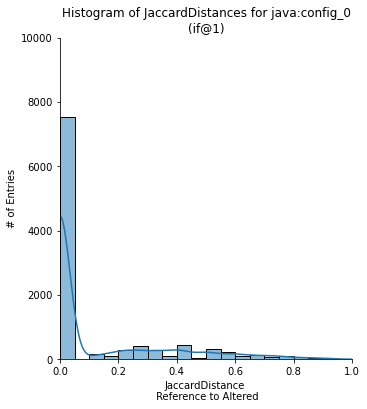

<Figure size 1440x864 with 0 Axes>

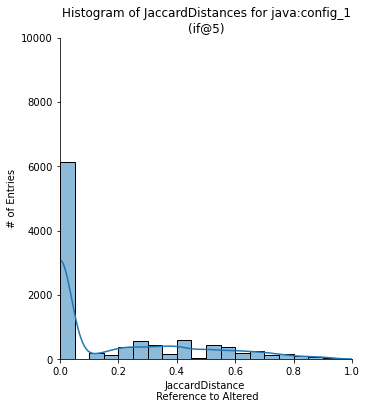

<Figure size 1440x864 with 0 Axes>

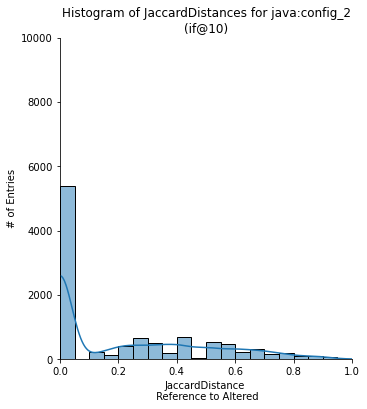

<Figure size 1440x864 with 0 Axes>

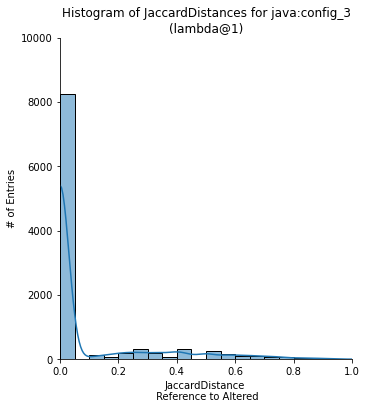

<Figure size 1440x864 with 0 Axes>

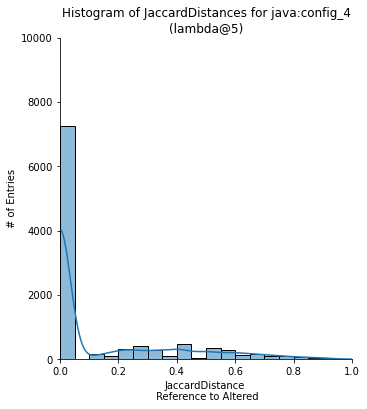

<Figure size 1440x864 with 0 Axes>

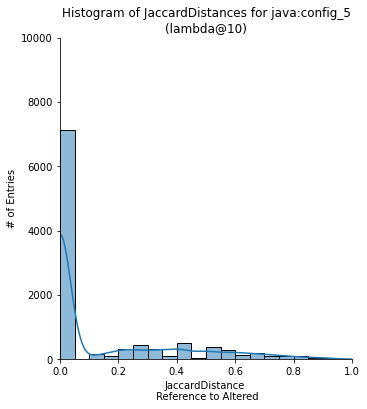

<Figure size 1440x864 with 0 Axes>

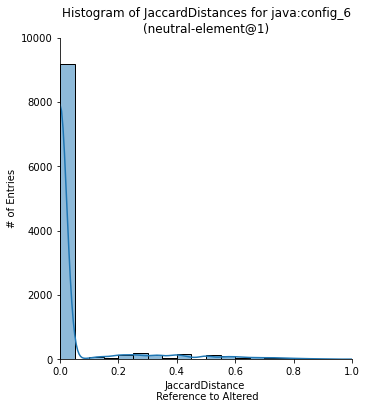

<Figure size 1440x864 with 0 Axes>

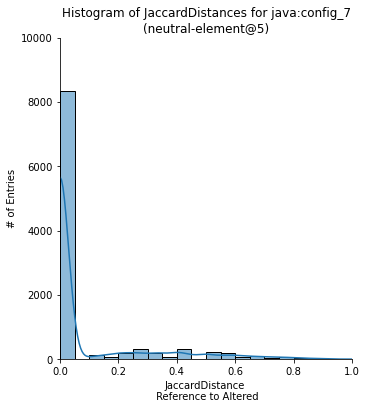

<Figure size 1440x864 with 0 Axes>

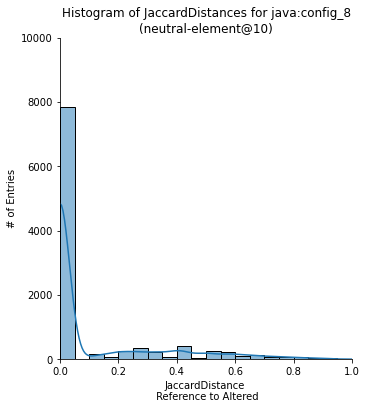

<Figure size 1440x864 with 0 Axes>

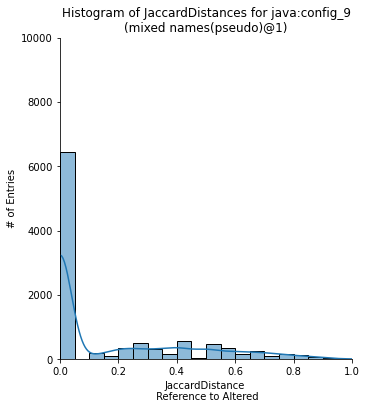

<Figure size 1440x864 with 0 Axes>

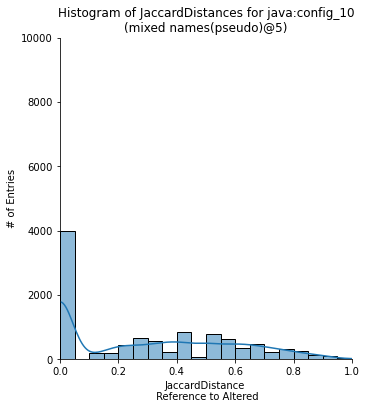

<Figure size 1440x864 with 0 Axes>

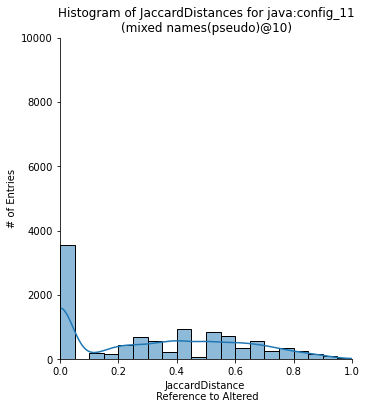

<Figure size 1440x864 with 0 Axes>

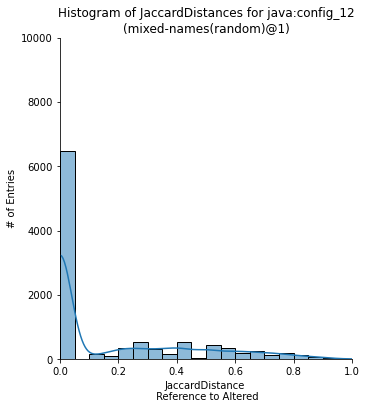

<Figure size 1440x864 with 0 Axes>

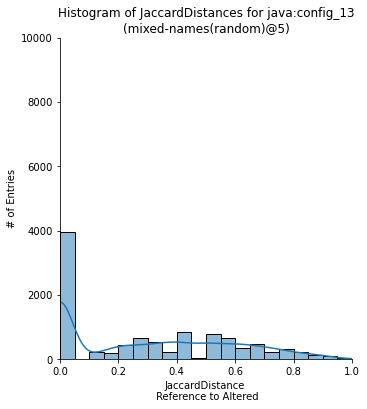

<Figure size 1440x864 with 0 Axes>

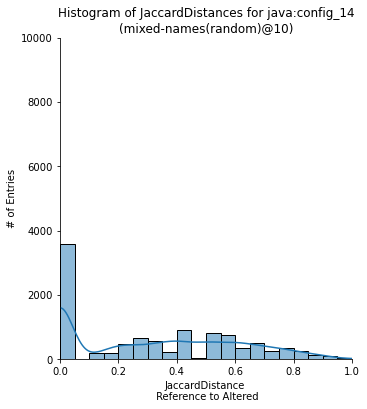

<Figure size 1440x864 with 0 Axes>

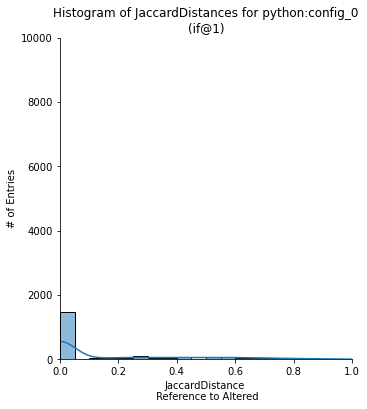

<Figure size 1440x864 with 0 Axes>

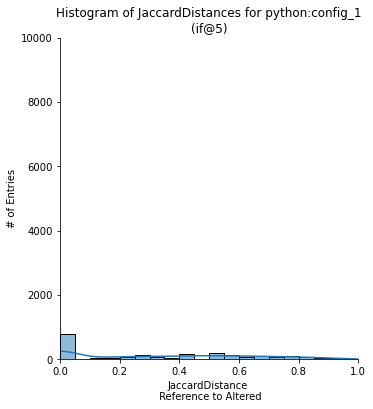

<Figure size 1440x864 with 0 Axes>

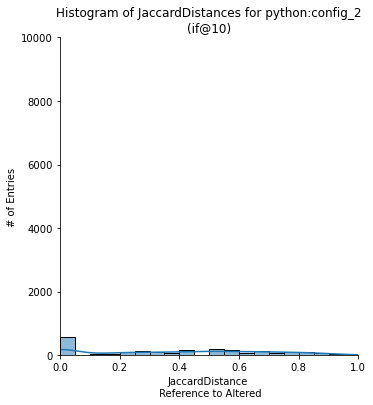

<Figure size 1440x864 with 0 Axes>

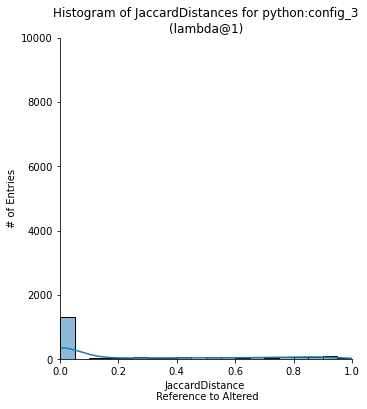

<Figure size 1440x864 with 0 Axes>

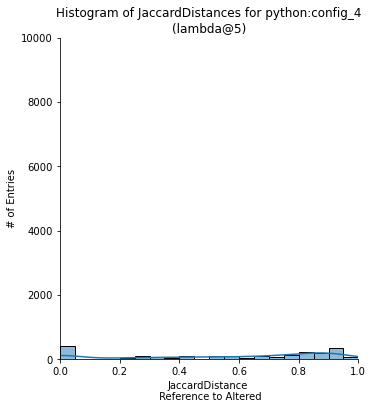

<Figure size 1440x864 with 0 Axes>

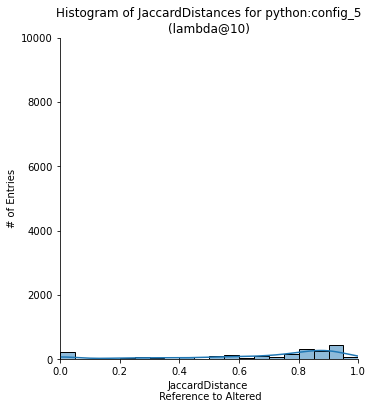

<Figure size 1440x864 with 0 Axes>

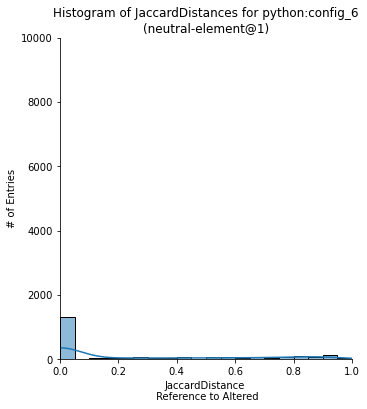

<Figure size 1440x864 with 0 Axes>

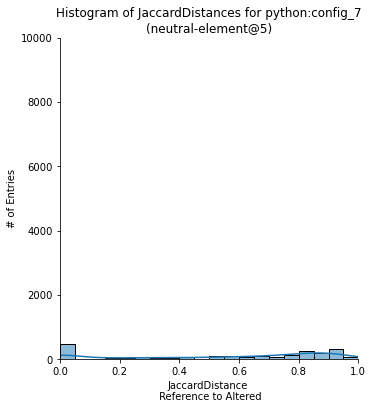

<Figure size 1440x864 with 0 Axes>

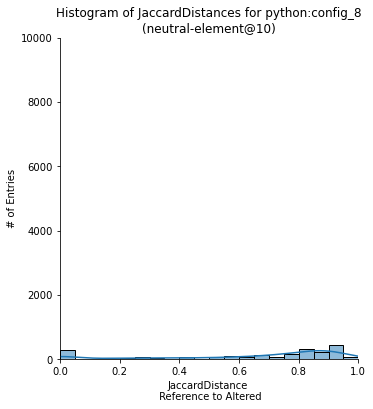

<Figure size 1440x864 with 0 Axes>

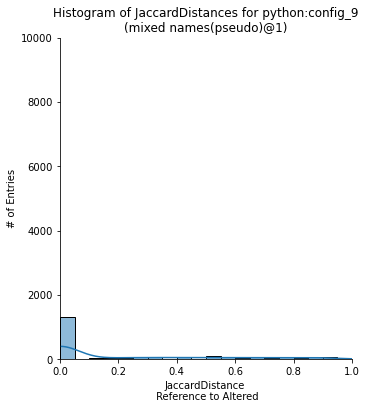

<Figure size 1440x864 with 0 Axes>

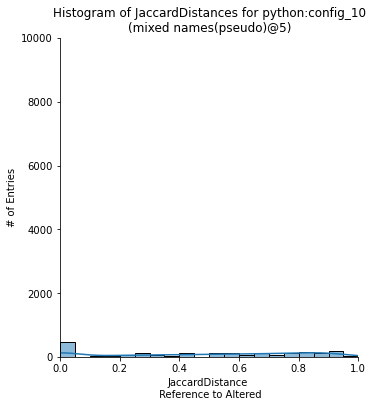

<Figure size 1440x864 with 0 Axes>

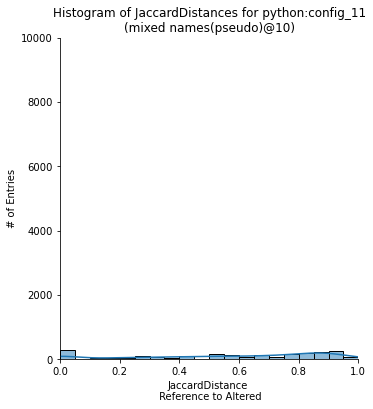

<Figure size 1440x864 with 0 Axes>

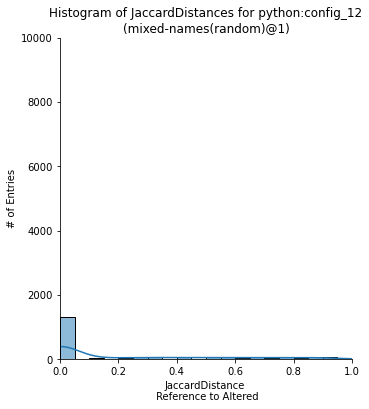

<Figure size 1440x864 with 0 Axes>

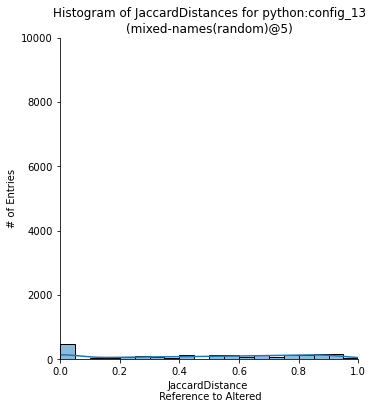

<Figure size 1440x864 with 0 Axes>

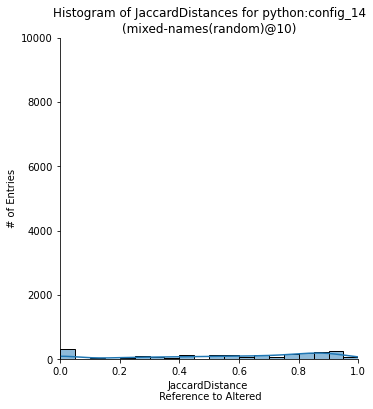

In [32]:
jaccs = {}
for (prefix,_) in non_reference_configs:
    jaccs[prefix] = {}
    
for (prefix,config) in non_reference_configs:
    distances = calculate_jaccard_distances(results[prefix]["reference"]["results"],results[prefix][config]["results"])
    
    jaccs[prefix][config]=distances
    plt.figure(figsize=(20,12))
    sns.displot(
        distances,
        kind="hist", kde=True,
        bins=20
    )
    plt.title(f"Histogram of JaccardDistances for {prefix}:{config}\n({print_archetype_info(config)})")
    plt.xlabel("JaccardDistance \n Reference to Altered")
    plt.ylabel("# of Entries")
    plt.xlim(0,1)
    plt.ylim(0,10000)
    
    plt.savefig(f'images/{prefix}_{config}_jaccard_histogram.png')
    plt.show()

<Figure size 1440x864 with 0 Axes>

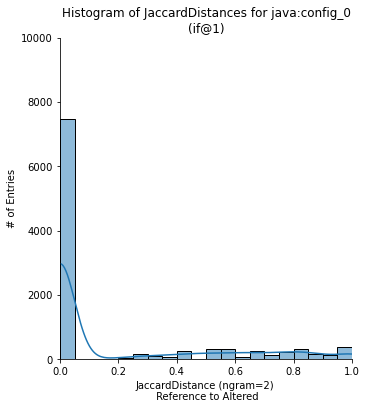

<Figure size 1440x864 with 0 Axes>

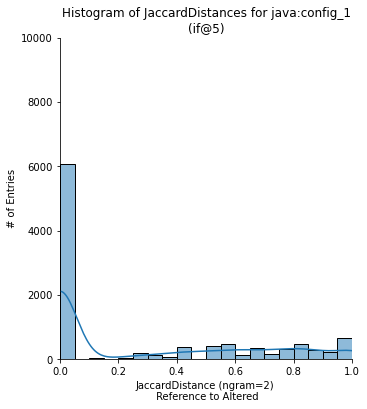

<Figure size 1440x864 with 0 Axes>

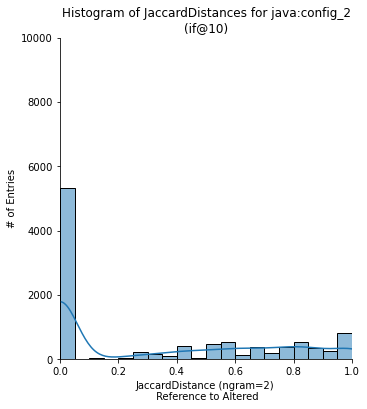

<Figure size 1440x864 with 0 Axes>

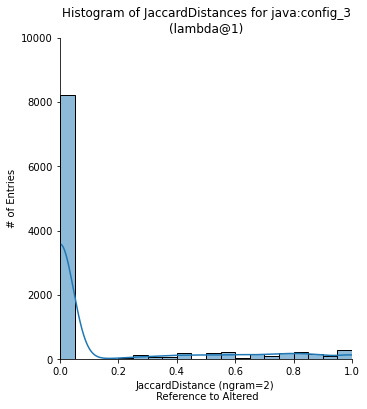

<Figure size 1440x864 with 0 Axes>

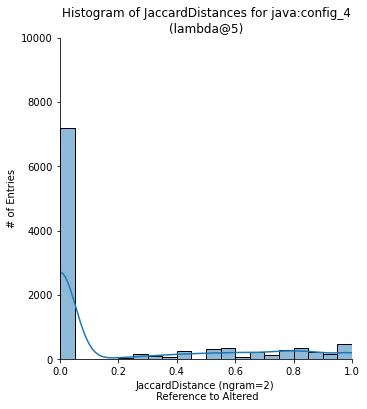

<Figure size 1440x864 with 0 Axes>

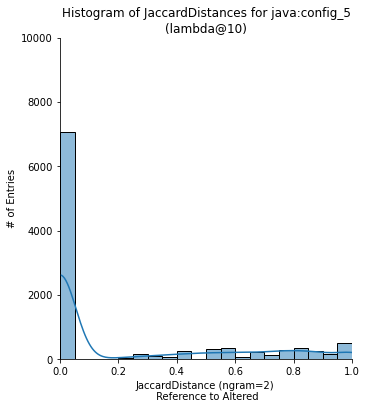

<Figure size 1440x864 with 0 Axes>

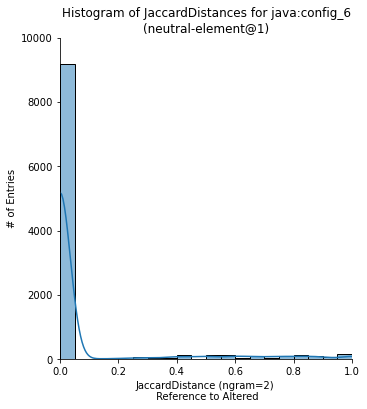

<Figure size 1440x864 with 0 Axes>

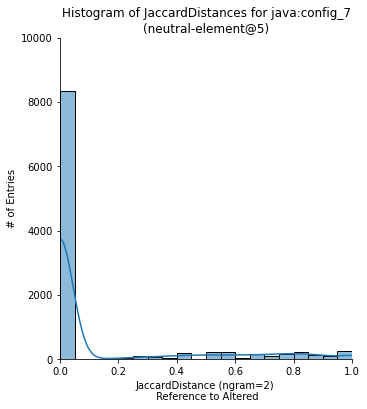

<Figure size 1440x864 with 0 Axes>

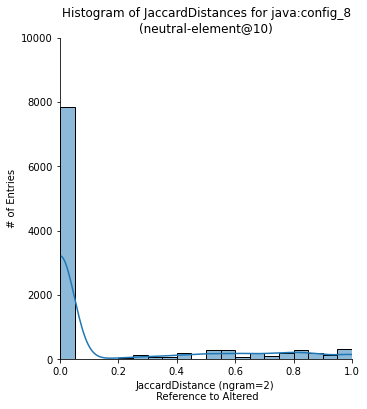

<Figure size 1440x864 with 0 Axes>

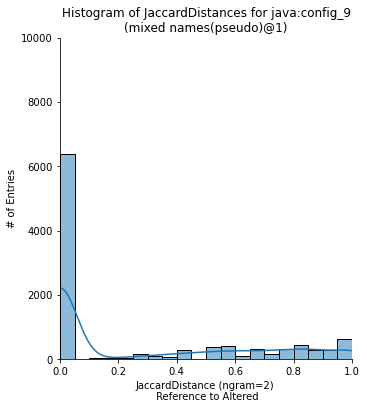

<Figure size 1440x864 with 0 Axes>

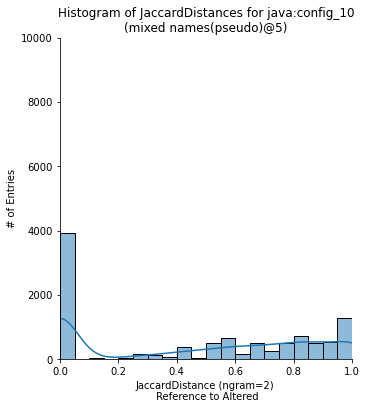

<Figure size 1440x864 with 0 Axes>

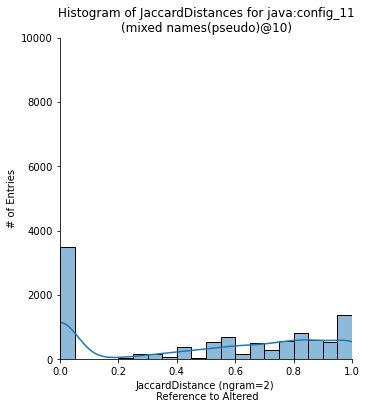

<Figure size 1440x864 with 0 Axes>

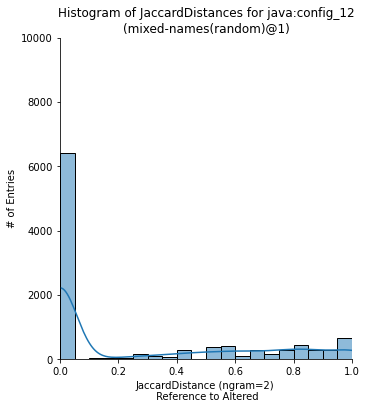

<Figure size 1440x864 with 0 Axes>

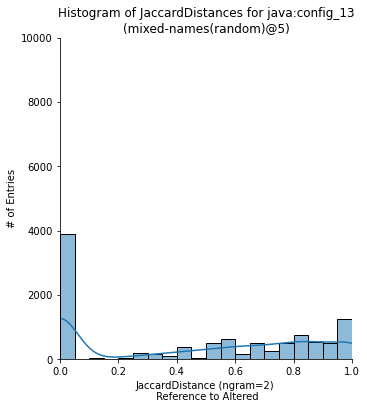

<Figure size 1440x864 with 0 Axes>

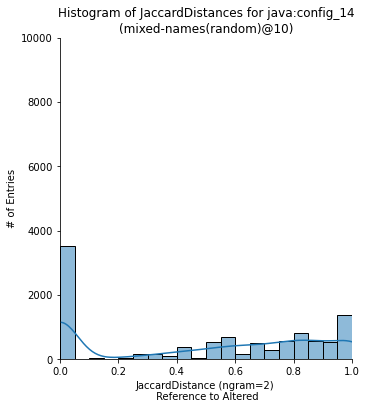

<Figure size 1440x864 with 0 Axes>

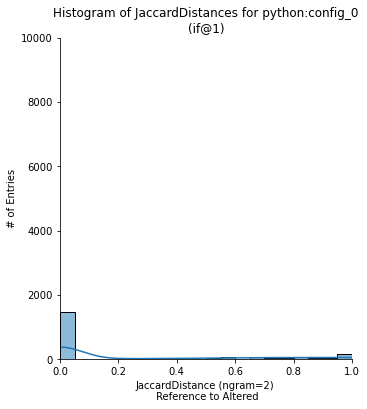

<Figure size 1440x864 with 0 Axes>

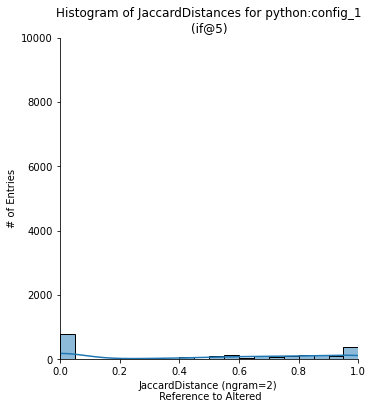

<Figure size 1440x864 with 0 Axes>

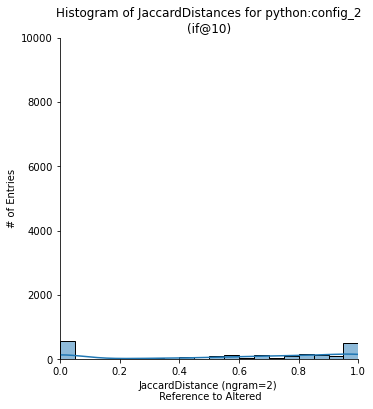

<Figure size 1440x864 with 0 Axes>

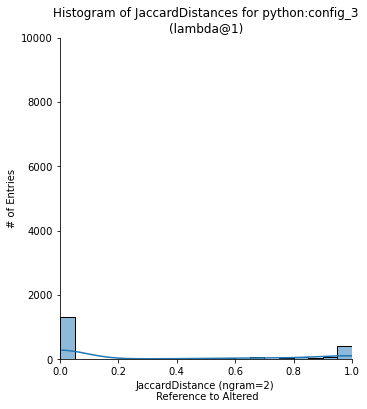

<Figure size 1440x864 with 0 Axes>

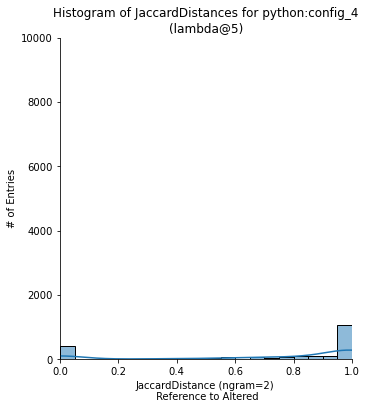

<Figure size 1440x864 with 0 Axes>

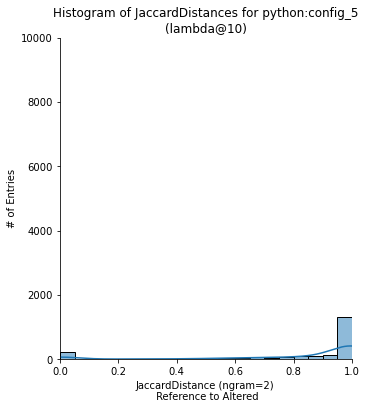

<Figure size 1440x864 with 0 Axes>

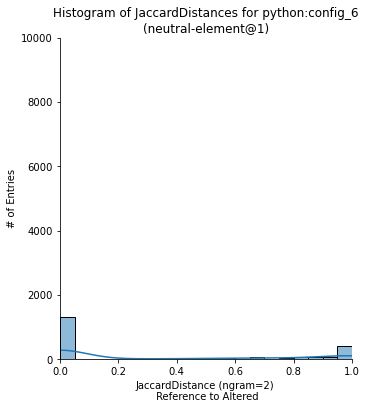

<Figure size 1440x864 with 0 Axes>

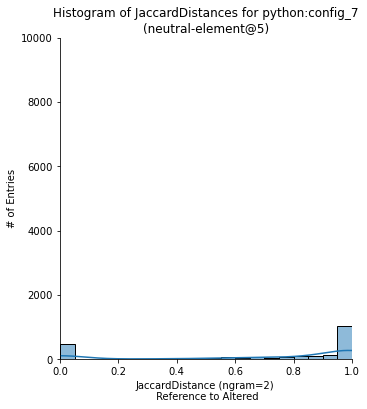

<Figure size 1440x864 with 0 Axes>

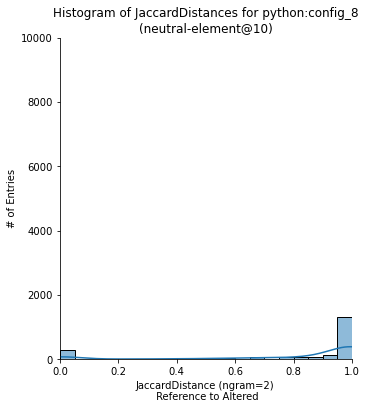

<Figure size 1440x864 with 0 Axes>

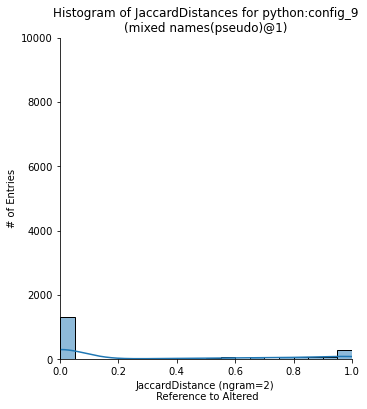

<Figure size 1440x864 with 0 Axes>

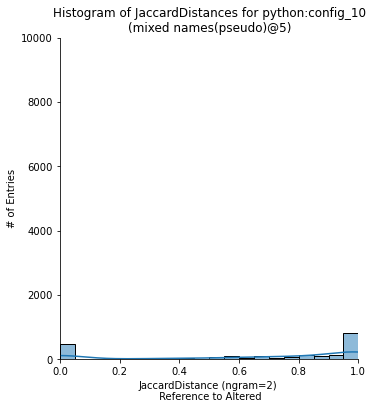

<Figure size 1440x864 with 0 Axes>

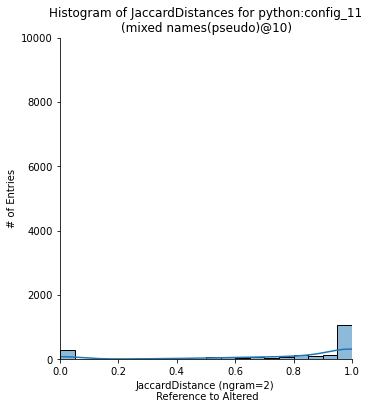

<Figure size 1440x864 with 0 Axes>

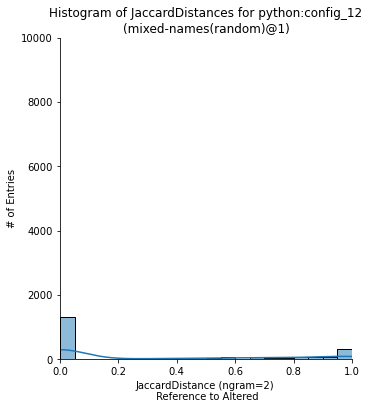

<Figure size 1440x864 with 0 Axes>

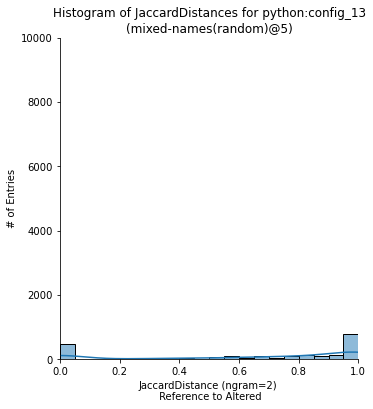

<Figure size 1440x864 with 0 Axes>

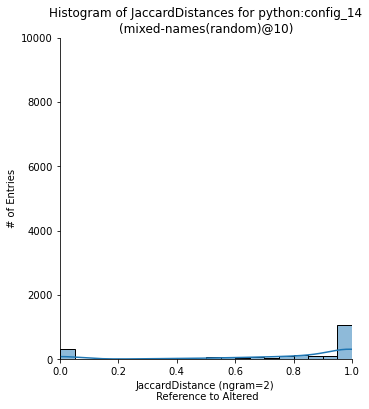

In [33]:
jaccs_n2 = {}
for (prefix,_) in non_reference_configs:
    jaccs_n2[prefix] = {}
    
for (prefix,config) in non_reference_configs:
    distances = calculate_jaccard_distances(results[prefix]["reference"]["results"],results[prefix][config]["results"],ngrams=2)
    
    jaccs_n2[prefix][config]=distances
    plt.figure(figsize=(20,12))
    sns.displot(
        distances,
        kind="hist", kde=True,
        bins=20
    )
    plt.title(f"Histogram of JaccardDistances for {prefix}:{config}\n({print_archetype_info(config)})")
    plt.xlabel("JaccardDistance (ngram=2) \n Reference to Altered")
    plt.ylabel("# of Entries")
    plt.xlim(0,1)
    plt.ylim(0,10000)
    
    plt.savefig(f'images/{prefix}_{config}_jaccard_ngram2_histogram.png')
    plt.show()

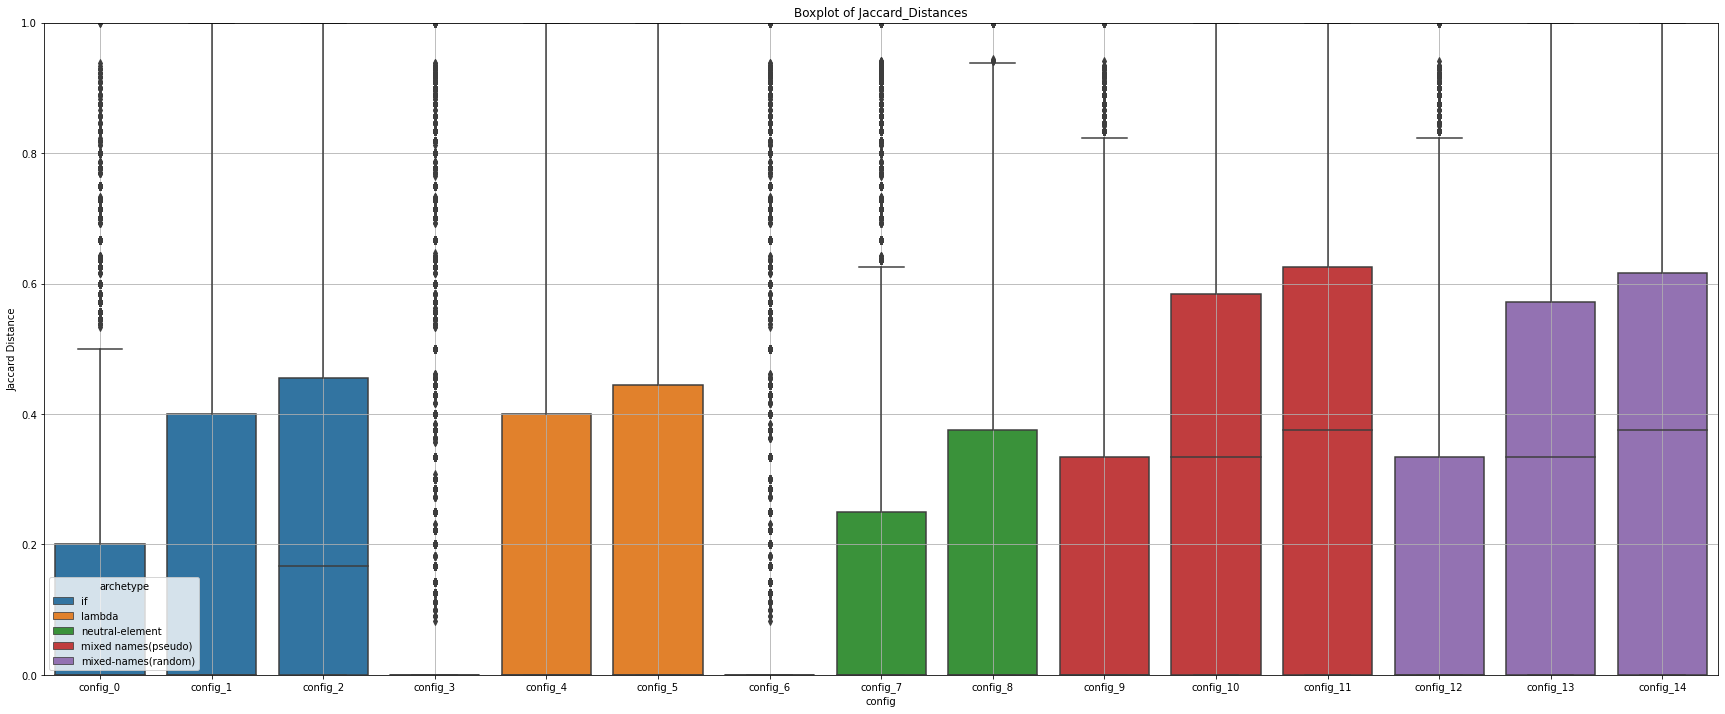

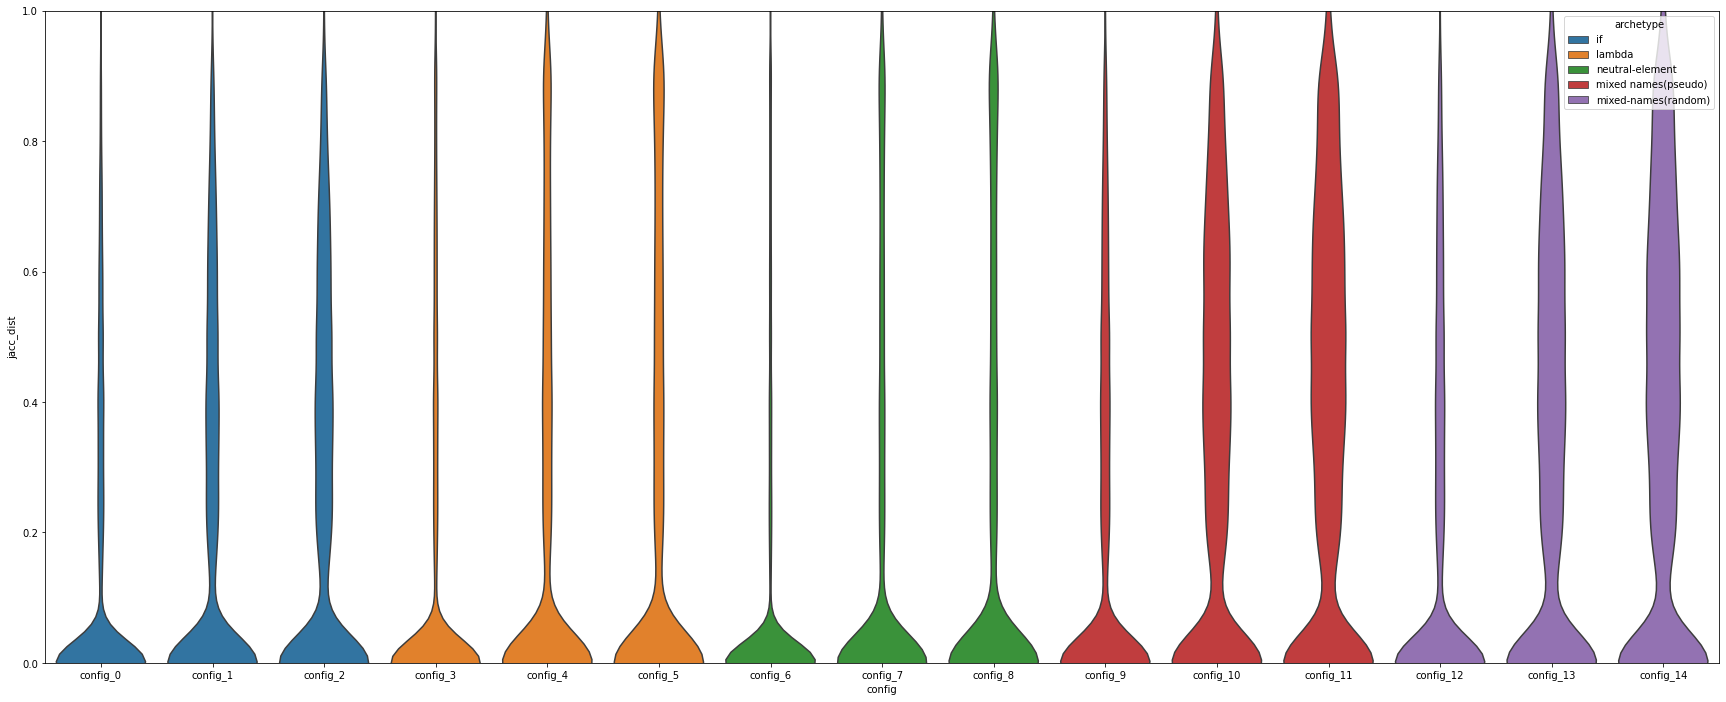

In [34]:
jacc_data = []
for prefix in jaccs.keys():
    for config in jaccs[prefix].keys():
        jacc_data.append((prefix,config,config_archetypes[config],jaccs[prefix][config]))

df = pd.DataFrame(jacc_data)
df.columns=["prefix","config","archetype","jacc_dist"]
df = df.explode('jacc_dist')
df['jacc_dist'] = df['jacc_dist'].astype('float')
df = df.dropna()

plt.figure(figsize=(30,12))

sns.boxplot(
    x="config",
    y="jacc_dist",
    hue="archetype",
    #width=4.5,
    dodge =False,
    data=df)

plt.grid()
plt.title(f"Boxplot of Jaccard_Distances")
plt.ylabel("Jaccard Distance")
plt.ylim(0,1)

plt.savefig(f'images/jaccard_distances_boxplot.png')
plt.show()

plt.figure(figsize=(30,12))
sns.violinplot(
    x="config",
    hue="archetype",
    y="jacc_dist",
    data=df,
#width=5.5,
  showmeans=False,
  showmedians=False,
    inner=None,
    dropnan=True,
    dropna=True,
    dodge =False
)
plt.ylim(0,1)

plt.savefig(f'images/jaccard_distances_violinplot.png')

plt.show()

del df

## Pandas

This is a different approach to gather all data in a pandas frame and then make 3 dimensional plots and other funny things.



In [35]:
%%time
# Driver for the time is the jaccard distance 

result_df_data = []

for (prefix,config) in non_reference_configs:
    arch = config_archetypes[config]
    ts = results[prefix][config]["properties"]["transformations"]
    index = 0
    while index < len(results[prefix][config]["results"]):
        ref = results[prefix]["reference"]["results"][index]
        res = results[prefix][config]["results"][index]
        gold = results[prefix]["reference"]["gold_results"][index]
        bleu = results[prefix][config]["bleu_values"][index]
        ref_bleu = results[prefix]["reference"]["bleu_values"][index]
        
        diff = res != ref
        perfect = gold == res
        
        # Distance Gold<>ConfigText
        jacc_1 = jaccard_wrapper(res,gold,ngram=1)
        jacc_2 = jaccard_wrapper(res,gold,ngram=2)
        # Distance Gold<>ReferenceText
        jacc_1_ref = jaccard_wrapper(ref,res,ngram=1)
        jacc_2_ref = jaccard_wrapper(ref,res,ngram=2)
        
        result_df_data.append(
            (prefix,config,arch,archetype_mt_mapping[arch],ts,index,
             bleu,ref_bleu,
             diff,perfect,
             jacc_1,jacc_2,
             jacc_1_ref,jacc_2_ref,
             gold,ref,res)
        )
        index = index + 1

result_df = pd.DataFrame(result_df_data)

result_df.columns=[
    "prefix","config","archetype","MT","transformations","index",
    "bleu","reference_bleu",
    "difference","perfect_match",
    "jaccard_n1","jaccard_n2","jaccard_n1_reference","jaccard_n2_reference",
    "gold_result","reference_result","config_result"
]

#result_df = result_df.dropna()

result_df.head()

CPU times: user 2min 29s, sys: 2.35 s, total: 2min 32s
Wall time: 2min 35s


prefix    config archetype     MT transformations  index      bleu  \
0   java  config_0        if  MT-IF               1      0  0.197025   
1   java  config_0        if  MT-IF               1      1  0.179152   
2   java  config_0        if  MT-IF               1      2  0.196924   
3   java  config_0        if  MT-IF               1      3  0.183043   
4   java  config_0        if  MT-IF               1      4  0.188274   

   reference_bleu  difference  perfect_match  jaccard_n1  jaccard_n2  \
0        0.197025       False          False    0.764706    0.944444   
1        0.179152        True          False    0.846154    0.916667   
2        0.234184        True          False    0.937500    1.000000   
3        0.183043       False          False    0.647059    0.904762   
4        0.188274       False          False    0.866667    0.937500   

   jaccard_n1_reference  jaccard_n2_reference  \
0              0.000000                   0.0   
1              0.200000                   0.6   
2              0.222222                   0.4   
3              0.000000                   0.0   
4              0.000000                   0.0   

                                         gold_result  \
0  Creates a Parquet Schema from an Arrow one and...   
1  the new slab is guaranteed to be at least mini...   
2  Will return the result of merging toMerge into...   
3  Copy from a FS input stream to an output strea...   
4  reads a Struct from the underlying protocol an...   

                                    reference_result  \
0  Creates a new SchemaMapping from the given Arq...   
1                                     Add new slab .   
2      Merge the global metadata of the given file .   
3  Copy bytes from the input stream to the specif...   
4                                    Read a struct .   

                                       config_result  
0  Creates a new SchemaMapping from the given Arq...  
1                                   Add a new slab .  
2    Merge the global metadata from the given file .  
3  Copy bytes from the input stream to the specif...  
4                                    Read a struct .

### Differences

Looking for Differences in results - similar to Jaccard Distance

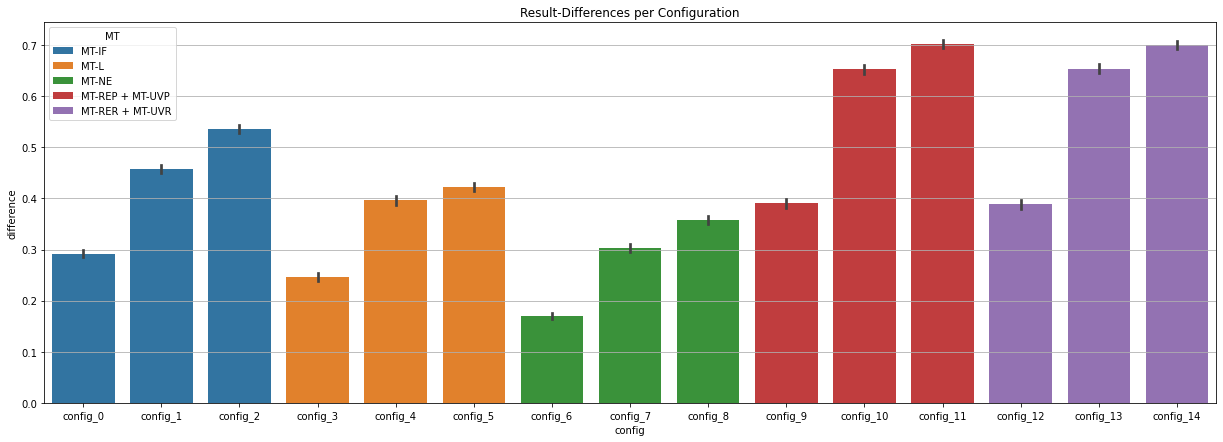

In [36]:
plt.figure(figsize=(21, 7))
plt.grid()

plt.title('Result-Differences per Configuration')


sns.barplot(
    x="config",y="difference",
    data=result_df,
    hue="MT",
    dodge =False
)


plt.savefig(f'images/number_of_diffs_by_config.png')
plt.show()

### RQ1 Results
These are some infos on the changed and affected results for the first order mts changes

In [37]:
languages = ["java","python"]

In [38]:
%%time
for lan in languages:
    totalPerO = result_df[(result_df["transformations"]=='1') & (result_df["prefix"]==lan)].count()[0]
    firstOdiff = result_df[(result_df["transformations"]=='1') & (result_df["difference"]) & (result_df["prefix"]==lan)].count()[0]
    fifthOdiff = result_df[(result_df["transformations"]=='5') & (result_df["difference"]) & (result_df["prefix"]==lan)].count()[0]
    tenthOdiff = result_df[(result_df["transformations"]=='10') & (result_df["difference"]) & (result_df["prefix"]==lan)].count()[0]
    
    print(lan)
    print("Total number of entries per Order:",totalPerO)
    print(f"Changes in first order {firstOdiff}({round(firstOdiff/totalPerO,3)}%)")
    print(f"Changes in fifth order {fifthOdiff}({round(fifthOdiff/totalPerO,3)}%)")
    print(f"Changes in tenth order {tenthOdiff}({round(tenthOdiff/totalPerO,3)}%)")

java
Total number of entries per Order: 52135
Changes in first order 14549(0.279%)
Changes in fifth order 22799(0.437%)
Changes in tenth order 25015(0.48%)
python
Total number of entries per Order: 10835
Changes in first order 4181(0.386%)
Changes in fifth order 8245(0.761%)
Changes in tenth order 9210(0.85%)
CPU times: user 215 ms, sys: 13.8 ms, total: 228 ms
Wall time: 234 ms


### RQ1 Results
These are some infos on the changed and affected results for the first order mts changes

In [39]:
plot_df = result_df.copy()
plot_df = plot_df[plot_df["transformations"]=='1']

plot_df["jacc1_diff"] = plot_df["jaccard_n1"]-plot_df["jaccard_n1_reference"]
plot_df["abs_jacc1_diff"] = abs(plot_df["jacc1_diff"])
plot_df["bleu_diff"] = plot_df["bleu"]-plot_df["reference_bleu"]
plot_df["abs_bleu_diff"]=abs(plot_df["bleu_diff"])

diffed_df = plot_df[plot_df["jaccard_n1_reference"]>0]

plot_df.head(3)

prefix    config archetype     MT transformations  index      bleu  \
0   java  config_0        if  MT-IF               1      0  0.197025   
1   java  config_0        if  MT-IF               1      1  0.179152   
2   java  config_0        if  MT-IF               1      2  0.196924   

   reference_bleu  difference  perfect_match  ...  jaccard_n2  \
0        0.197025       False          False  ...    0.944444   
1        0.179152        True          False  ...    0.916667   
2        0.234184        True          False  ...    1.000000   

   jaccard_n1_reference  jaccard_n2_reference  \
0              0.000000                   0.0   
1              0.200000                   0.6   
2              0.222222                   0.4   

                                         gold_result  \
0  Creates a Parquet Schema from an Arrow one and...   
1  the new slab is guaranteed to be at least mini...   
2  Will return the result of merging toMerge into...   

                                    reference_result  \
0  Creates a new SchemaMapping from the given Arq...   
1                                     Add new slab .   
2      Merge the global metadata of the given file .   

                                       config_result jacc1_diff  \
0  Creates a new SchemaMapping from the given Arq...   0.764706   
1                                   Add a new slab .   0.646154   
2    Merge the global metadata from the given file .   0.715278   

   abs_jacc1_diff  bleu_diff  abs_bleu_diff  
0        0.764706    0.00000        0.00000  
1        0.646154    0.00000        0.00000  
2        0.715278   -0.03726        0.03726  

[3 rows x 21 columns]

In [40]:
print("Total Changes (not langauge specific)")
post_1stMT_count = plot_df.count()[0]
count_jacc_samsies = plot_df[(plot_df["jaccard_n1_reference"]==0)].count()[0]
count_jacc_diffs = diffed_df.count()[0]
count_bleu_diffs = plot_df[(plot_df["abs_bleu_diff"]>0)].count()[0]

avg_bleu_diff = np.mean(plot_df[plot_df["abs_bleu_diff"]>0 ]["abs_bleu_diff"])

print("Entries for first order",post_1stMT_count)
print("Jaccard Changes:",count_jacc_diffs, f"({round(count_jacc_diffs/post_1stMT_count,3)} of entries)")
print(f"BLEU Changes: {count_bleu_diffs}({round(count_bleu_diffs/post_1stMT_count,3)} of entries)")
print("Average Bleu-Diff:",avg_bleu_diff)

avg_jacc_diff = np.mean(plot_df[(plot_df["abs_bleu_diff"]>0)]["abs_bleu_diff"])
median_jacc_diff = np.median(plot_df["jaccard_n1_reference"])
iqr_jacc_diff = stats.iqr(plot_df["jaccard_n1_reference"])

print("Average Jacc Diff:",avg_jacc_diff)
print("Median Jacc Diff:",median_jacc_diff)
print("IQR Jacc Diffs:",iqr_jacc_diff)
print()
del count_jacc_samsies,count_jacc_diffs,count_bleu_diffs,avg_bleu_diff,avg_jacc_diff, median_jacc_diff, iqr_jacc_diff

Total Changes (not langauge specific)
Entries for first order 62970
Jaccard Changes: 18389 (0.292 of entries)
BLEU Changes: 13131(0.209 of entries)
Average Bleu-Diff: 0.06847992235222544
Average Jacc Diff: 0.06847992235222544
Median Jacc Diff: 0.0
IQR Jacc Diffs: 0.2222222222222222



In [41]:
for lan in languages:
    print(lan)
    post_1stMT_count = plot_df[plot_df["prefix"]==lan].count()[0]
    count_jacc_samsies = plot_df[(plot_df["jaccard_n1_reference"]==0)  & (plot_df["prefix"]==lan)].count()[0]
    count_jacc_diffs = diffed_df[diffed_df["prefix"]==lan].count()[0]
    count_bleu_diffs = plot_df[(plot_df["abs_bleu_diff"]>0) & (plot_df["prefix"]==lan)].count()[0]

    avg_bleu_diff = np.mean(plot_df[plot_df["abs_bleu_diff"]>0 & (plot_df["prefix"]==lan)]["abs_bleu_diff"])

    print("Entries for first order",post_1stMT_count)
    print("Jaccard Changes:",count_jacc_diffs, f"({round(count_jacc_diffs/post_1stMT_count,3)} of entries)")
    print(f"BLEU Changes: {count_bleu_diffs}({round(count_bleu_diffs/post_1stMT_count,3)} of entries)")
    print("Average Bleu-Diff:",avg_bleu_diff)

    avg_jacc_diff = np.mean(plot_df[(plot_df["abs_bleu_diff"]>0) & (plot_df["prefix"]==lan) ]["abs_bleu_diff"])
    median_jacc_diff = np.median(plot_df[plot_df["prefix"]==lan]["jaccard_n1_reference"])
    iqr_jacc_diff = stats.iqr(plot_df[plot_df["prefix"]==lan]["jaccard_n1_reference"])

    print("Average Jacc Diff:",avg_jacc_diff)
    print("Median Jacc Diff:",median_jacc_diff)
    print("IQR Jacc Diffs:",iqr_jacc_diff)
    print()
    del count_jacc_samsies,count_jacc_diffs,count_bleu_diffs,avg_bleu_diff,avg_jacc_diff, median_jacc_diff, iqr_jacc_diff

java
Entries for first order 52135
Jaccard Changes: 14245 (0.273 of entries)
BLEU Changes: 10070(0.193 of entries)
Average Bleu-Diff: 0.06847992235222544
Average Jacc Diff: 0.06785573525947582
Median Jacc Diff: 0.0
IQR Jacc Diffs: 0.2

python
Entries for first order 10835
Jaccard Changes: 4144 (0.382 of entries)
BLEU Changes: 3061(0.283 of entries)
Average Bleu-Diff: 0.06847992235222544
Average Jacc Diff: 0.07053335718528285
Median Jacc Diff: 0.0
IQR Jacc Diffs: 0.42857142857142855



Histogram of changes 
(To show nice non-null changes)

<ipython-input-42-38a9fc4a13a2>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)
<ipython-input-42-38a9fc4a13a2>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)


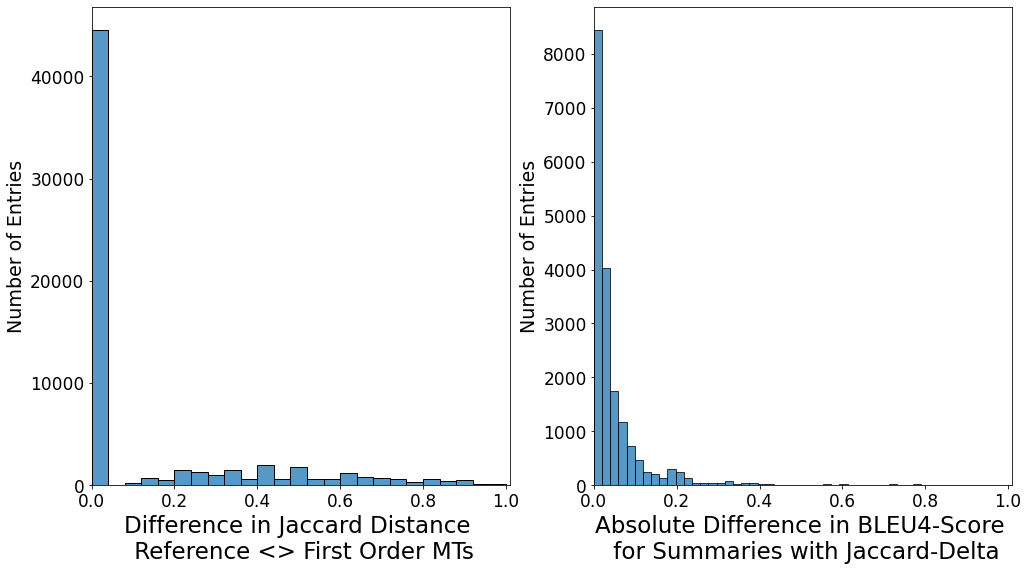

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16.5, 8.8))

sns.histplot(ax=axes[0],data=plot_df,
             x="jaccard_n1_reference",
             bins=25)
axes[0].set(xlim=(0,1.01))

axes[0].set_xlabel(f'Difference in Jaccard Distance \n Reference <> First Order MTs', fontsize=23)
axes[0].set_ylabel('Number of Entries', fontsize=19)

axes[0].set_xticks(np.arange(0,1.2,0.2))
axes[0].set_xticklabels([round(x,1) for x in np.arange(0,1.2,0.2)],fontsize=17)

axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)

sns.histplot(ax=axes[1],data=diffed_df,
             x="abs_bleu_diff",
             bins=50)

axes[1].set(xlim=(0,1.01))
axes[1].set_xlabel(f'Absolute Difference in BLEU4-Score \n for Summaries with Jaccard-Delta', fontsize=23)
axes[1].set_ylabel('Number of Entries', fontsize=19)

axes[1].set_xticks(np.arange(0,1.2,0.2))
axes[1].set_xticklabels([round(x,1) for x in np.arange(0,1.2,0.2)],fontsize=17)

axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)

plt.savefig(f'images/overview_plot_changes_of_firstorder_mts_small_combined.png')

plt.show()

<ipython-input-43-c116ac5c56d2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)
<ipython-input-43-c116ac5c56d2>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)


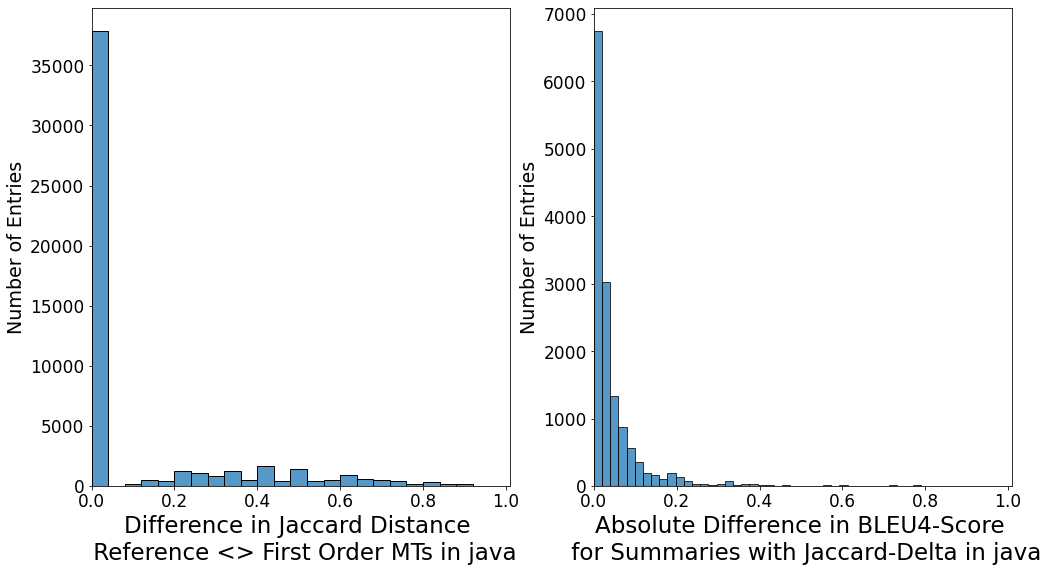

<ipython-input-43-c116ac5c56d2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)
<ipython-input-43-c116ac5c56d2>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)


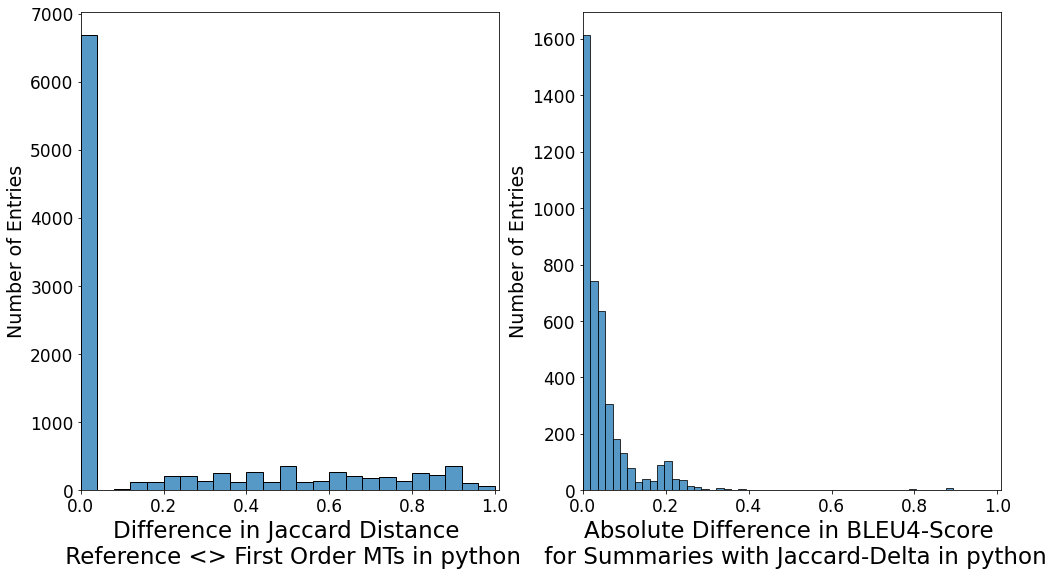

In [43]:
for lan in languages:
    fig, axes = plt.subplots(1, 2, figsize=(16.5, 8.8))

    sns.histplot(ax=axes[0],data=plot_df[plot_df["prefix"]==lan],
                 x="jaccard_n1_reference",
                 bins=25)
    axes[0].set(xlim=(0,1.01))

    axes[0].set_xlabel(f'Difference in Jaccard Distance \n Reference <> First Order MTs in {lan}', fontsize=23)
    axes[0].set_ylabel('Number of Entries', fontsize=19)

    axes[0].set_xticks(np.arange(0,1.2,0.2))
    axes[0].set_xticklabels([round(x,1) for x in np.arange(0,1.2,0.2)],fontsize=17)

    axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)

    sns.histplot(ax=axes[1],data= diffed_df[diffed_df["prefix"]==lan],
                 x="abs_bleu_diff",
                 bins=50)

    axes[1].set(xlim=(0,1.01))
    axes[1].set_xlabel(f'Absolute Difference in BLEU4-Score \n for Summaries with Jaccard-Delta in {lan}', fontsize=23)
    axes[1].set_ylabel('Number of Entries', fontsize=19)

    axes[1].set_xticks(np.arange(0,1.2,0.2))
    axes[1].set_xticklabels([round(x,1) for x in np.arange(0,1.2,0.2)],fontsize=17)

    axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)

    plt.savefig(f'images/overview_plot_changes_of_firstorder_mts_small_{lan}.png')

    plt.show()

#del plot_df

<ipython-input-44-c116ac5c56d2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)
<ipython-input-44-c116ac5c56d2>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)


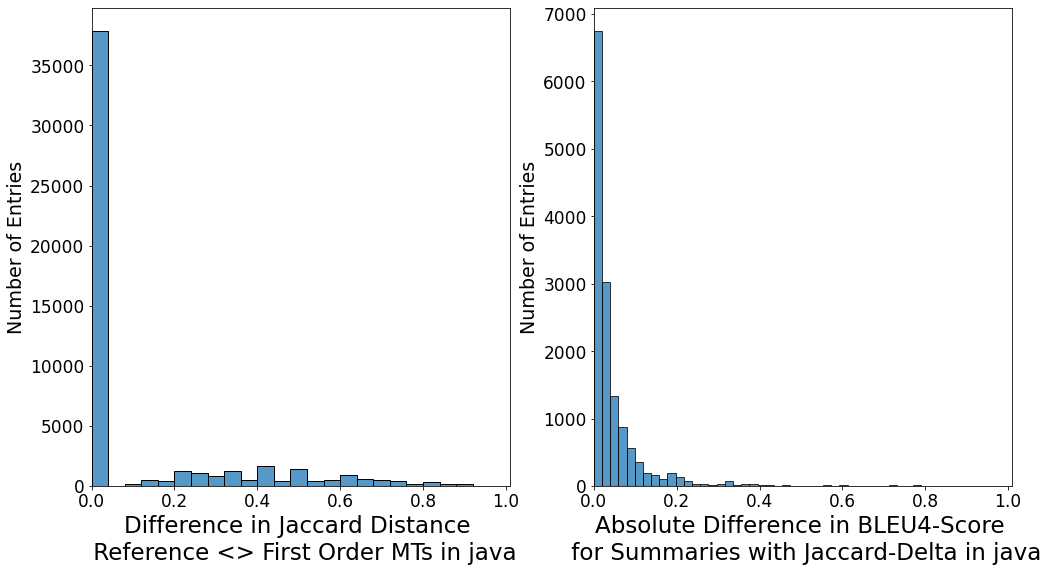

<ipython-input-44-c116ac5c56d2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)
<ipython-input-44-c116ac5c56d2>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)


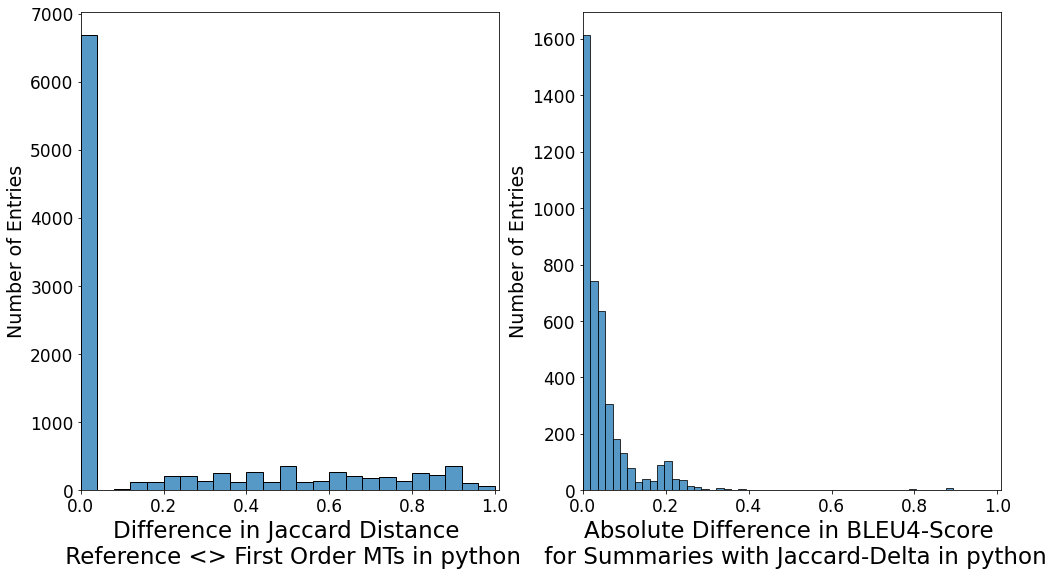

In [44]:
for lan in languages:
    fig, axes = plt.subplots(1, 2, figsize=(16.5, 8.8))

    sns.histplot(ax=axes[0],data=plot_df[plot_df["prefix"]==lan],
                 x="jaccard_n1_reference",
                 bins=25)
    axes[0].set(xlim=(0,1.01))

    axes[0].set_xlabel(f'Difference in Jaccard Distance \n Reference <> First Order MTs in {lan}', fontsize=23)
    axes[0].set_ylabel('Number of Entries', fontsize=19)

    axes[0].set_xticks(np.arange(0,1.2,0.2))
    axes[0].set_xticklabels([round(x,1) for x in np.arange(0,1.2,0.2)],fontsize=17)

    axes[0].set_yticklabels([int(a) for a in axes[0].get_yticks()],fontsize=17)

    sns.histplot(ax=axes[1],data= diffed_df[diffed_df["prefix"]==lan],
                 x="abs_bleu_diff",
                 bins=50)

    axes[1].set(xlim=(0,1.01))
    axes[1].set_xlabel(f'Absolute Difference in BLEU4-Score \n for Summaries with Jaccard-Delta in {lan}', fontsize=23)
    axes[1].set_ylabel('Number of Entries', fontsize=19)

    axes[1].set_xticks(np.arange(0,1.2,0.2))
    axes[1].set_xticklabels([round(x,1) for x in np.arange(0,1.2,0.2)],fontsize=17)

    axes[1].set_yticklabels([int(a) for a in axes[1].get_yticks()],fontsize=17)

    plt.savefig(f'images/overview_plot_changes_of_firstorder_mts_small_{lan}.png')

    plt.show()

#del plot_df

### RQ2 Results
For RQ2 we first needed to have simple counts and percentages of the mere numbers.

In [45]:
totalPerO = result_df[(result_df["transformations"]=='1')].count()[0]
firstOdiff = result_df[(result_df["transformations"]=='1') & (result_df["difference"])].count()[0]
fifthOdiff = result_df[(result_df["transformations"]=='5') & (result_df["difference"])].count()[0]
tenthOdiff = result_df[(result_df["transformations"]=='10') & (result_df["difference"])].count()[0]

print("Total Differences:")
print("Total number of entries per Order:",totalPerO)
print(f"Changes in first order {firstOdiff}({round(firstOdiff/totalPerO,3)} of entries)")
print(f"Changes in fifth order {fifthOdiff}({round(fifthOdiff/totalPerO,3)} of entries)")
print(f"Changes in tenth order {tenthOdiff}({round(tenthOdiff/totalPerO,3)}%)")

Total Differences:
Total number of entries per Order: 62970
Changes in first order 18730(0.297 of entries)
Changes in fifth order 31044(0.493 of entries)
Changes in tenth order 34225(0.544%)


In [46]:
%%time
for lan in languages:
    totalPerO = result_df[(result_df["transformations"]=='1') & (result_df["prefix"]==lan)].count()[0]
    firstOdiff = result_df[(result_df["transformations"]=='1') & (result_df["difference"]) & (result_df["prefix"]==lan)].count()[0]
    fifthOdiff = result_df[(result_df["transformations"]=='5') & (result_df["difference"]) & (result_df["prefix"]==lan)].count()[0]
    tenthOdiff = result_df[(result_df["transformations"]=='10') & (result_df["difference"]) & (result_df["prefix"]==lan)].count()[0]
    
    print(lan)
    print("Total number of entries per Order:",totalPerO)
    print(f"Changes in first order {firstOdiff}({round(firstOdiff/totalPerO,3)}%)")
    print(f"Changes in fifth order {fifthOdiff}({round(fifthOdiff/totalPerO,3)}%)")
    print(f"Changes in tenth order {tenthOdiff}({round(tenthOdiff/totalPerO,3)}%)")

java
Total number of entries per Order: 52135
Changes in first order 14549(0.279%)
Changes in fifth order 22799(0.437%)
Changes in tenth order 25015(0.48%)
python
Total number of entries per Order: 10835
Changes in first order 4181(0.386%)
Changes in fifth order 8245(0.761%)
Changes in tenth order 9210(0.85%)
CPU times: user 209 ms, sys: 12.2 ms, total: 222 ms
Wall time: 224 ms


In [47]:
bleu_data_df_transposed

1         2         3                    4   \
prefix               java      java      java                 java   
config           config_0  config_1  config_2            reference   
archetype              if        if        if  mixed-names(random)   
transformations         1         5        10                    0   
bleu               17.651    17.409    17.493                 18.0   

                                  5                    6   \
prefix                          java                 java   
config                     config_12            config_13   
archetype        mixed-names(random)  mixed-names(random)   
transformations                    1                    5   
bleu                          17.295               16.828   

                                  7                8                9   \
prefix                          java             java             java   
config                     config_14        reference         config_7   
archetype        mixed-names(random)  neutral-element  neutral-element   
transformations                   10                0                5   
bleu                          16.727             18.0           17.695   

                              10  ...               30               31  \
prefix                      java  ...           python           python   
config                  config_6  ...         config_6         config_8   
archetype        neutral-element  ...  neutral-element  neutral-element   
transformations                1  ...                1               10   
bleu                      17.715  ...           16.586           13.677   

                        32        33        34        35                   36  \
prefix              python    python    python    python               python   
config           reference  config_3  config_4  config_5            reference   
archetype           lambda    lambda    lambda    lambda  mixed names(pseudo)   
transformations          0         1         5        10                    0   
bleu                  17.0    16.505     14.91    13.842                 17.0   

                                  37                   38                   39  
prefix                        python               python               python  
config                      config_9            config_11            config_10  
archetype        mixed names(pseudo)  mixed names(pseudo)  mixed names(pseudo)  
transformations                    1                   10                    5  
bleu                          16.524               13.976               15.034  

[5 rows x 39 columns]

In [48]:
for a in plot_df["MT"].unique():
    print(a)

MT-IF
MT-L
MT-NE
MT-REP + MT-UVP
MT-RER + MT-UVR


In [49]:
bleu_data_df

prefix     config            archetype  transformations    bleu
0     java  reference                   if                0  18.000
1     java   config_0                   if                1  17.651
2     java   config_1                   if                5  17.409
3     java   config_2                   if               10  17.493
4     java  reference  mixed-names(random)                0  18.000
5     java  config_12  mixed-names(random)                1  17.295
6     java  config_13  mixed-names(random)                5  16.828
7     java  config_14  mixed-names(random)               10  16.727
8     java  reference      neutral-element                0  18.000
9     java   config_7      neutral-element                5  17.695
10    java   config_6      neutral-element                1  17.715
11    java   config_8      neutral-element               10  17.532
12    java  reference               lambda                0  18.000
13    java   config_3               lambda                1  17.542
14    java   config_4               lambda                5  17.293
15    java   config_5               lambda               10  17.286
16    java  reference  mixed names(pseudo)                0  18.000
17    java   config_9  mixed names(pseudo)                1  17.250
18    java  config_11  mixed names(pseudo)               10  16.808
19    java  config_10  mixed names(pseudo)                5  16.885
20  python  reference                   if                0  17.000
21  python   config_0                   if                1  17.182
22  python   config_1                   if                5  16.730
23  python   config_2                   if               10  16.360
24  python  reference  mixed-names(random)                0  17.000
25  python  config_12  mixed-names(random)                1  16.491
26  python  config_13  mixed-names(random)                5  15.156
27  python  config_14  mixed-names(random)               10  14.122
28  python  reference      neutral-element                0  17.000
29  python   config_7      neutral-element                5  14.693
30  python   config_6      neutral-element                1  16.586
31  python   config_8      neutral-element               10  13.677
32  python  reference               lambda                0  17.000
33  python   config_3               lambda                1  16.505
34  python   config_4               lambda                5  14.910
35  python   config_5               lambda               10  13.842
36  python  reference  mixed names(pseudo)                0  17.000
37  python   config_9  mixed names(pseudo)                1  16.524
38  python  config_11  mixed names(pseudo)               10  13.976
39  python  config_10  mixed names(pseudo)                5  15.034

In [50]:
rq2_data = {}
rq2_data["LAN"] = ["JAVA","PY","JAVA+PY"]

java_entries = result_df[(result_df["transformations"]=='1') & (result_df["prefix"]=="java")].count()[0]
python_entries = result_df[(result_df["transformations"]=='1') & (result_df["prefix"]=="python")].count()[0]
total_entries = java_entries + python_entries

java_reference_bleu =  bleu_data_df[
            (bleu_data_df["prefix"]=="java") & 
            (bleu_data_df["transformations"]==0) & 
            (bleu_data_df["archetype"] == "if")]["bleu"].iloc()[0]
#print("Reference")
#print("\t java:",java_reference_bleu)
python_reference_bleu =  bleu_data_df[
            (bleu_data_df["prefix"]=="python") & 
            (bleu_data_df["transformations"]==0) & 
            (bleu_data_df["archetype"] == "if")]["bleu"].iloc()[0]
#print("\t python:",python_reference_bleu)
weighted_reference_bleu = (java_reference_bleu * java_entries + python_reference_bleu * python_entries) / total_entries
weighted_reference_bleu = round(weighted_reference_bleu,3)
#print("\t total:",weighted_reference_bleu)


reference_datapoint = [java_reference_bleu,python_reference_bleu,weighted_reference_bleu]
rq2_data["BASE"] = reference_datapoint

for t in result_df["transformations"].unique():
    for mt in result_df["MT"].unique():
        at = mt_archetype_mapping[mt]
        #print(at+"@"+str(t))
        java_bleu = bleu_data_df[
            (bleu_data_df["prefix"]=="java") & 
            (bleu_data_df["transformations"]==int(t)) & 
            (bleu_data_df["archetype"] == mt_archetype_mapping[mt])]["bleu"].iloc()[0]
        #print("\t java:",java_bleu)
        python_bleu = bleu_data_df[
            (bleu_data_df["prefix"]=="python") & 
            (bleu_data_df["transformations"]==int(t)) & 
            (bleu_data_df["archetype"] == mt_archetype_mapping[mt])]["bleu"].iloc()[0]
        #print("\t python:",python_bleu)
        
        weighted_bleu = (java_bleu * java_entries + python_bleu * python_entries) / total_entries
        weighted_bleu = round(weighted_bleu,3)
        #print("\t total",weighted_bleu)
        datapoint = [java_bleu,python_bleu,weighted_bleu]
        rq2_data[f"{mt}@{str(t)}"] = datapoint
        #rq2_datapoints.append(datapoint)
rq2_df = pd.DataFrame(rq2_data)
del rq2_data,datapoint,reference_datapoint
rq2_df

LAN    BASE  MT-IF@1  MT-L@1  MT-NE@1  MT-REP + MT-UVP@1  \
0     JAVA  18.000   17.651  17.542   17.715             17.250   
1       PY  17.000   17.182  16.505   16.586             16.524   
2  JAVA+PY  17.828   17.570  17.364   17.521             17.125   

   MT-RER + MT-UVR@1  MT-IF@5  MT-L@5  MT-NE@5  MT-REP + MT-UVP@5  \
0             17.295   17.409  17.293   17.695             16.885   
1             16.491   16.730  14.910   14.693             15.034   
2             17.157   17.292  16.883   17.178             16.567   

   MT-RER + MT-UVR@5  MT-IF@10  MT-L@10  MT-NE@10  MT-REP + MT-UVP@10  \
0             16.828    17.493   17.286    17.532              16.808   
1             15.156    16.360   13.842    13.677              13.976   
2             16.540    17.298   16.693    16.869              16.321   

   MT-RER + MT-UVR@10  
0              16.727  
1              14.122  
2              16.279

In [51]:
with open("./exports/per_mt_per_t_bleu_scores.tex","w") as f: 
    f.write(
        rq2_df.to_latex(
            caption="BLEU4-Scores for increasing order of metamorphic transformations \n (applied n-times per datapoint)"
            ,label="tab:bleus"
            ,position="th"
            #,column_format={rrrrrrr}
        )          
)

## Shapiro Tests

In [52]:
from scipy import stats

jaccs = result_df[result_df["config"]=="config_1"]["reference_bleu"].to_numpy()
shapiro_test = stats.shapiro(jaccs)
print(f"reference bleu score",shapiro_test)

reference bleu score ShapiroResult(statistic=0.720960259437561, pvalue=0.0)


/Users/lapplis/opt/anaconda3/envs/Lampion-Codebert-Evaluation/lib/python3.8/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [53]:
for (prefix,config) in non_reference_configs:
    df_mask=(result_df['config']==config) & (result_df['prefix']==prefix)
    
    jaccs1 = result_df[df_mask]["jaccard_n1"].to_numpy()
    jaccs2 = result_df[df_mask]["jaccard_n2"].to_numpy()

    shapiro_test1 = stats.shapiro(jaccs1)
    shapiro_test2 = stats.shapiro(jaccs2)
    print(f"jacc1_dist",f"{prefix}:{config}",shapiro_test1)
    print(f"jacc2_dist",f"{prefix}:{config}",shapiro_test2)

jacc1_dist java:config_0 ShapiroResult(statistic=0.9109224081039429, pvalue=0.0)
jacc2_dist java:config_0 ShapiroResult(statistic=0.6281588077545166, pvalue=0.0)
jacc1_dist java:config_1 ShapiroResult(statistic=0.9157065749168396, pvalue=0.0)
jacc2_dist java:config_1 ShapiroResult(statistic=0.6318790912628174, pvalue=0.0)
jacc1_dist java:config_2 ShapiroResult(statistic=0.9168863296508789, pvalue=0.0)
jacc2_dist java:config_2 ShapiroResult(statistic=0.6354965567588806, pvalue=0.0)
jacc1_dist java:config_3 ShapiroResult(statistic=0.9085031747817993, pvalue=0.0)
jacc2_dist java:config_3 ShapiroResult(statistic=0.6231896877288818, pvalue=0.0)
jacc1_dist java:config_4 ShapiroResult(statistic=0.9167062044143677, pvalue=0.0)
jacc2_dist java:config_4 ShapiroResult(statistic=0.6332424879074097, pvalue=0.0)
jacc1_dist java:config_5 ShapiroResult(statistic=0.9166527390480042, pvalue=0.0)
jacc2_dist java:config_5 ShapiroResult(statistic=0.6320744752883911, pvalue=0.0)
jacc1_dist java:config_6 Sha

In [54]:
agg_df_data = []
for (prefix,config) in non_reference_configs:
    df_mask=(result_df['config']==config) & (result_df['prefix']==prefix)
    
    bleu_data = result_df[df_mask]["bleu"].to_numpy()
    jacc_1_data = result_df[df_mask]["jaccard_n1"].to_numpy()
    jacc_2_data = result_df[df_mask]["jaccard_n2"].to_numpy()
    
    arch = config_archetypes[config]
    ts = results[prefix][config]["properties"]["transformations"]
    
    shapiro_test = stats.shapiro(bleu_data)
    
    bleu_median = np.median(bleu_data)
    bleu_mean = np.mean(bleu_data)
    bleu_iqr = stats.iqr(bleu_data)
    
    jacc1_median = np.median(jacc_1_data)
    jacc1_mean = np.mean(jacc_1_data)
    jacc1_iqr = stats.iqr(jacc_1_data)    
    
    jacc2_median = np.median(jacc_2_data)
    jacc2_mean = np.mean(jacc_2_data)
    jacc2_iqr = stats.iqr(jacc_2_data)
    
    config_entry = (prefix,config,arch,ts,
                    shapiro_test,
                    bleu_median,bleu_mean,bleu_iqr,
                    jacc1_median,jacc1_mean,jacc1_iqr,
                    jacc2_median,jacc2_mean,jacc2_iqr)
    
    agg_df_data.append(config_entry)
    #print(f"delta-bleus {config}",median,mean)
    
agg_df = pd.DataFrame(agg_df_data) 
del agg_df_data
agg_df.columns=[
    "prefix","config","archetype","transformations",
    "bleu_shapiro_test",
    "bleu_median","bleu_mean","bleu_iqr",
    "jacc1_median","jacc1_mean","jacc1_iqr",
    "jacc2_median","jacc2_mean","jacc2_iqr",
    
]
agg_df.head()

prefix    config archetype transformations          bleu_shapiro_test  \
0   java  config_0        if               1  (0.7281326055526733, 0.0)   
1   java  config_1        if               5  (0.7324510812759399, 0.0)   
2   java  config_2        if              10  (0.7290527820587158, 0.0)   
3   java  config_3    lambda               1  (0.7251980304718018, 0.0)   
4   java  config_4    lambda               5  (0.7397276163101196, 0.0)   

   bleu_median  bleu_mean  bleu_iqr  jacc1_median  jacc1_mean  jacc1_iqr  \
0     0.210614   0.213687  0.062221      0.777778    0.740019   0.202899   
1     0.211113   0.212102  0.063249      0.777778    0.741779   0.202899   
2     0.212619   0.212854  0.063124      0.777778    0.740647   0.202899   
3     0.212241   0.213805  0.063400      0.777778    0.740973   0.200877   
4     0.212241   0.211660  0.061342      0.777778    0.743530   0.202899   

   jacc2_median  jacc2_mean  jacc2_iqr  
0      0.976190    0.912058   0.111111  
1      1.000000    0.914379   0.111111  
2      0.980000    0.913793   0.111111  
3      0.986111    0.913442   0.111111  
4      1.000000    0.916274   0.111111

In [55]:
# These are not so readable plots, I keep them commented out
"""
for lan in languages:
    plt.figure(figsize=(12, 10))

    plt.title(f"Delta-TScore IQR for non-zero delta-tscores in {lan}")

    pivoted_data = agg_df[agg_df["prefix"]==lan].pivot(index='transformations', columns='archetype', values='bleu_iqr')
    pivoted_data = pivoted_data.sort_values("transformations",key=lambda col:col.astype(int),ascending=True)
    sns.heatmap(pivoted_data, annot=True, fmt="g",cmap='viridis')


    plt.savefig(f'images/heatmap_nonzero_shapiro_pvalues_{lan}.png')

    plt.show()
"""


'\nfor lan in languages:\n    plt.figure(figsize=(12, 10))\n\n    plt.title(f"Delta-TScore IQR for non-zero delta-tscores in {lan}")\n\n    pivoted_data = agg_df[agg_df["prefix"]==lan].pivot(index=\'transformations\', columns=\'archetype\', values=\'bleu_iqr\')\n    pivoted_data = pivoted_data.sort_values("transformations",key=lambda col:col.astype(int),ascending=True)\n    sns.heatmap(pivoted_data, annot=True, fmt="g",cmap=\'viridis\')\n\n\n    plt.savefig(f\'images/heatmap_nonzero_shapiro_pvalues_{lan}.png\')\n\n    plt.show()\n'

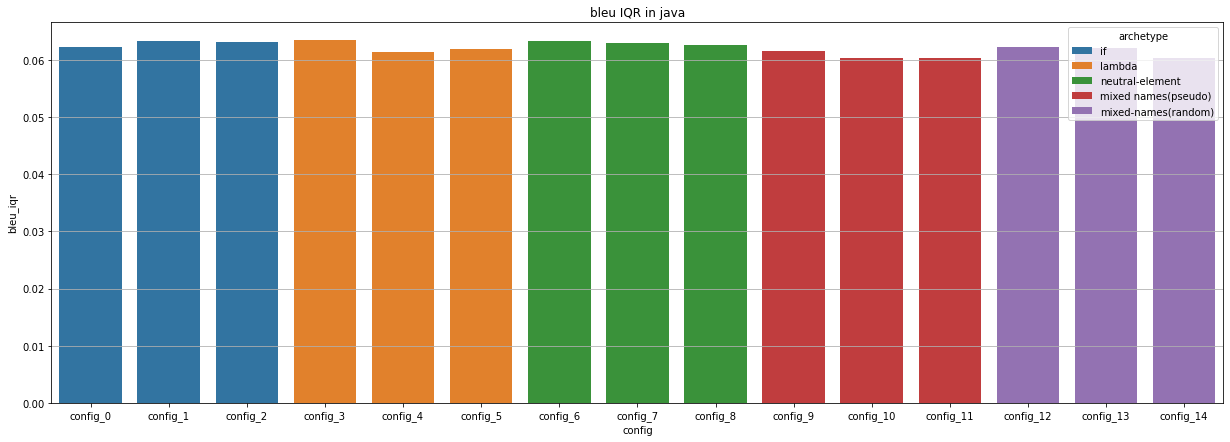

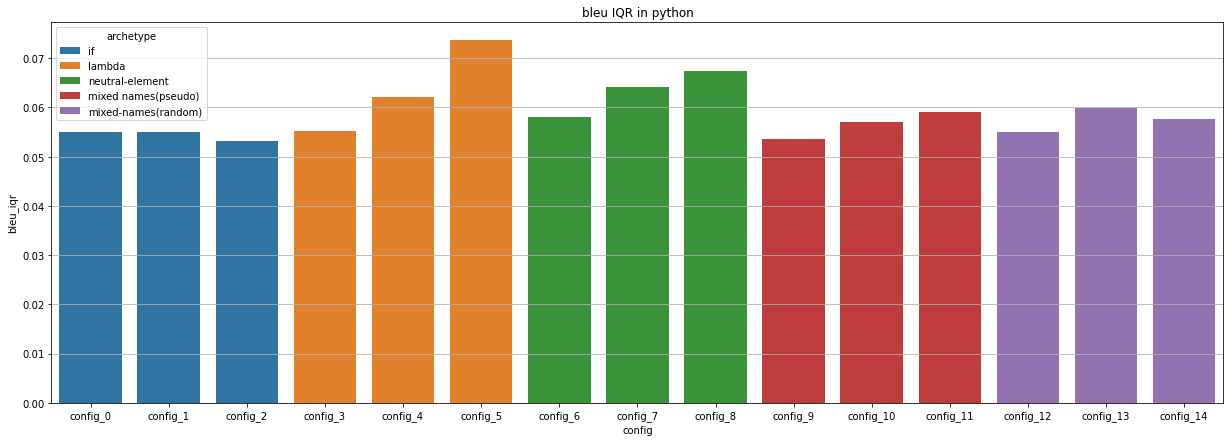

In [56]:
for lan in languages:
    plt.figure(figsize=(21, 7))
    plt.grid()

    plt.title(f'bleu IQR in {lan}')


    sns.barplot(
        x="config",y="bleu_iqr",
        data=agg_df[agg_df["prefix"]==lan],
        hue="archetype",
        dodge =False
    )

    plt.savefig(f'images/barplot_deltatscore_iqrs_{lan}.png')

    plt.show()

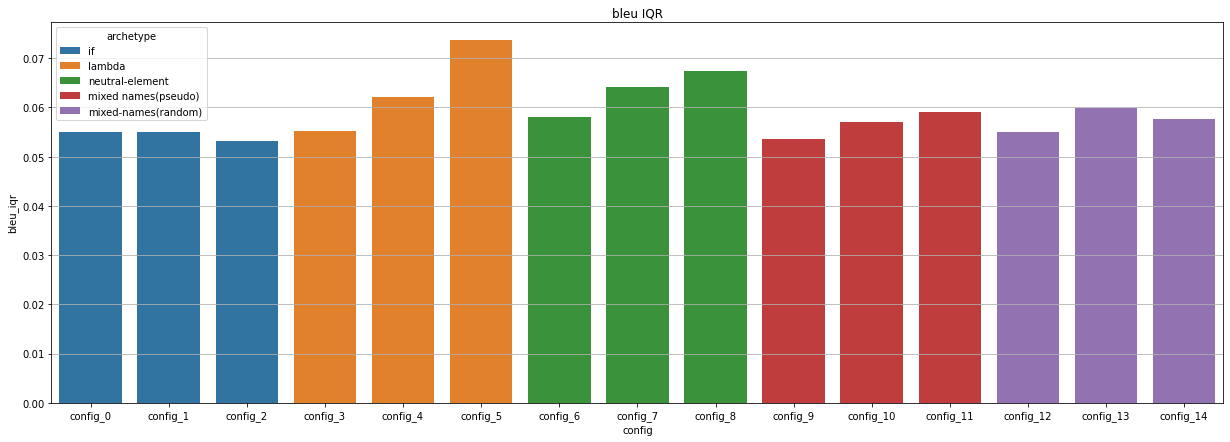

In [57]:
# TODO: Try these together as a scatterplot ? 
plt.figure(figsize=(21, 7))
plt.grid()

plt.title(f'bleu IQR')


sns.barplot(
    x="config",y="bleu_iqr",
    data=agg_df[agg_df["prefix"]==lan],
    hue="archetype",
    dodge =False
)

plt.savefig(f'images/barplot_deltatscore_iqrs.png')

plt.show()

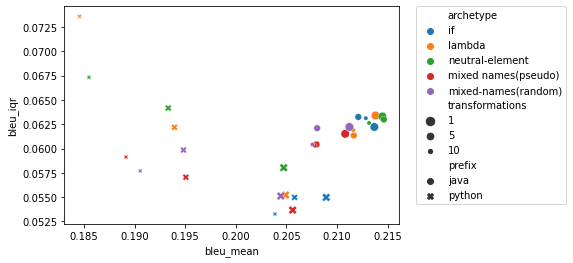

In [58]:
# TODO: This is a draft
# TODO: Transformation Size is the wrong way round (lol)
sns.scatterplot(
    x="bleu_mean",y="bleu_iqr",style="prefix", size="transformations",
    data=agg_df,
    hue="archetype"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Non - Setter / Getter Split 

As we looked in the data, there seems to be a lot of items just for setters and getters that even in the gold standard have a text like "set the XY".
This is rather noisy, and we want to split the data into "Setter","Getter","Other" and have a look at each group.

In [59]:
get_indizes=[]
set_indizes=[]
low_word_indizes=[]
other_indizes=[]

def is_in_indizes(index,prefix,lookup):
    for (pre,i) in lookup:
        if pre == prefix and i == index:
                return True
    return False

for lan in languages:
    for index in list(results[lan]["reference"]["results"].keys()):
            gold = results[lan]["reference"]["gold_results"][index]     
            words = len(gold.split())

            if "get" in gold.lower() and words < 10:
                get_indizes.append((lan,index)) 
            elif "set" in gold.lower() and not "setting" in gold.lower() and words < 10:
                set_indizes.append((lan,index))
            elif words < 5:
                low_word_indizes.append((lan,index))
    print(f"==={lan}===")
    print("gets:",len(get_indizes))
    print("sets:",len(set_indizes))
    print("low_words:",len(low_word_indizes))


    other_indizes = other_indizes + [ (lan,i) for i in list(results[lan]["reference"]["results"].keys())
                      if not is_in_indizes(i,lan,get_indizes + set_indizes + low_word_indizes) ]

    print("remaining indizes:",len(other_indizes))

    # Comment this in for sampling the remaining indizes
    #for i in other_indizes[:50]:
    #    print(results["reference"]["gold_results"][i])

===java===
gets: 530
sets: 479
low_words: 755
remaining indizes: 8663
===python===
gets: 600
sets: 541
low_words: 900
remaining indizes: 10553


In [60]:
ref_get_bleus = {}
ref_getter_bleu = {}
ref_set_bleus = {}
ref_setter_bleu = {}
ref_low_word_bleus = {}
ref_lowwords_bleu = {}
ref_cleaned_bleus = {}
ref_remaining_bleu = {}

for lan in languages:
    print(f"==={lan}===")
    ref_get_bleus[lan] = [results[prefix]["reference"]["bleu_values"][index] for (prefix,index) in get_indizes if prefix == lan]
    ref_getter_bleu[lan] = np.mean(ref_get_bleus[lan])
    print("get:",ref_getter_bleu[lan])

    ref_set_bleus[lan] = [results[prefix]["reference"]["bleu_values"][index] for (prefix,index) in set_indizes if prefix == lan]
    ref_setter_bleu[lan] = np.mean(ref_set_bleus[lan])
    print("set:",ref_setter_bleu[lan])

    ref_low_word_bleus[lan] = [results[prefix]["reference"]["bleu_values"][index] for (prefix,index) in low_word_indizes if prefix == lan]
    ref_lowwords_bleu[lan] = np.mean(ref_low_word_bleus[lan])
    print("low words:",ref_lowwords_bleu[lan])

    ref_cleaned_bleus[lan] = [results[prefix]["reference"]["bleu_values"][index] for (prefix,index) in other_indizes if prefix == lan]
    ref_remaining_bleu[lan] = np.mean(ref_cleaned_bleus[lan])
    print("remaining indizes:",ref_remaining_bleu[lan])
    print()

===java===
get: 0.30747169148858017
set: 0.3020982039590146
low words: 0.17087550311217847
remaining indizes: 0.20805733837029822

===python===
get: 0.21311845852388883
set: 0.2224238090545557
low words: 0.162081467593618
remaining indizes: 0.2126969368728833



In [61]:
split_bleus_data = []

# For every archetype, add as the 0 transformation point the reference
for lan in languages:
    for archetype in set(config_archetypes.values()):
        datapoint = (lan,"reference",archetype,0,
                     results[prefix]["reference"]["bleu"]/100,
                     ref_getter_bleu[lan],ref_setter_bleu[lan],ref_lowwords_bleu[lan],ref_remaining_bleu[lan])
        split_bleus_data.append(datapoint)

# For all configs, make a datapoint with the separated bleus
for (lan,config) in non_reference_configs:

    archetype = config_archetypes[config]
    transformations = results[lan][config]["properties"]["transformations"]
    
    getter_bleus = [results[prefix][config]["bleu_values"][index] for (prefix,index) in get_indizes if prefix == lan]
    getter_agg_bleu = np.mean(getter_bleus)

    setter_bleus = [results[prefix][config]["bleu_values"][index] for (prefix,index) in set_indizes if prefix == lan]
    setter_agg_bleu = np.mean(setter_bleus)

    low_word_bleus = [results[prefix][config]["bleu_values"][index] for (prefix,index) in low_word_indizes if prefix == lan]
    lowwords_agg_bleu = np.mean(low_word_bleus)

    other_bleus = [results[prefix][config]["bleu_values"][index] for (prefix,index) in other_indizes if prefix == lan]
    other_agg_bleu = np.mean(other_bleus)
    
    datapoint = (lan,config,archetype,transformations,
                 results[lan][config]["bleu"]/100,
                 getter_agg_bleu,setter_agg_bleu,lowwords_agg_bleu,other_agg_bleu)
    split_bleus_data.append(datapoint)

# Make a dataframe from the values 
split_bleus_df = pd.DataFrame(split_bleus_data)
split_bleus_df.columns = [
    "prefix",
    "config","archetype","transformations",
    "bleu",
    "getter_bleu","setter_bleu","low_word_bleu","remaining_bleu"
]
split_bleus_df["transformations"] = split_bleus_df["transformations"].astype("int")
split_bleus_df = split_bleus_df.sort_values(["archetype","transformations"])
split_bleus_df.head()

prefix     config archetype  transformations      bleu  getter_bleu  \
0     java  reference        if                0  0.172854     0.307472   
5   python  reference        if                0  0.172854     0.213118   
10    java   config_0        if                1  0.176507     0.299806   
25  python   config_0        if                1  0.171819     0.220532   
11    java   config_1        if                5  0.174091     0.286983   

    setter_bleu  low_word_bleu  remaining_bleu  
0      0.302098       0.170876        0.208057  
5      0.222424       0.162081        0.212697  
10     0.292616       0.168208        0.208018  
25     0.229157       0.165268        0.211191  
11     0.279862       0.168076        0.207611

In [62]:
split_bleus_data_type_b = []

# For every archetype, add as the 0 transformation point the reference
for lan in languages:
    for archetype in set(config_archetypes.values()):
        split_bleus_data_type_b.append(
            (lan,"reference",archetype,0,"getter_bleu",ref_getter_bleu[lan])
        )
        split_bleus_data_type_b.append(
            (lan,"reference",archetype,0,"setter_bleu",ref_setter_bleu[lan])
        )
        split_bleus_data_type_b.append(
            (lan,"reference",archetype,0,"low_word_bleu",ref_lowwords_bleu[lan])
        )
        split_bleus_data_type_b.append(
            (lan,"reference",archetype,0,"remaining_bleu",ref_remaining_bleu[lan])
        )
        split_bleus_data_type_b.append(
            (lan,"reference",archetype,0,"bleu",results[lan]["reference"]["bleu"]/100)
        )

# For all configs, make a datapoint with the separated bleus
for (prefix,config) in non_reference_configs:

    archetype = config_archetypes[config]
    transformations = results[prefix][config]["properties"]["transformations"]
    
    getter_bleus = [results[prefix][config]["bleu_values"][index] for (lan,index) in get_indizes if lan == prefix]
    getter_agg_bleu = np.mean(getter_bleus)
    split_bleus_data_type_b.append(
        (prefix,config,archetype,transformations,"getter_bleu",getter_agg_bleu)
    )
    
    setter_bleus = [results[prefix][config]["bleu_values"][index] for (lan,index) in set_indizes if lan == prefix]
    setter_agg_bleu = np.mean(setter_bleus)
    split_bleus_data_type_b.append(
        (prefix,config,archetype,transformations,"setter_bleu",setter_agg_bleu)
    )

    low_word_bleus = [results[prefix][config]["bleu_values"][index] for (lan,index) in low_word_indizes if lan == prefix]
    lowwords_agg_bleu = np.mean(low_word_bleus)
    split_bleus_data_type_b.append(
        (prefix,config,archetype,transformations,"low_word_bleu",lowwords_agg_bleu)
    )
    other_bleus = [results[prefix][config]["bleu_values"][index] for (lan,index) in other_indizes if lan == prefix]
    other_agg_bleu = np.mean(other_bleus)
    split_bleus_data_type_b.append(
        (prefix,config,archetype,transformations,"remaining_bleu",other_agg_bleu)
    )

    split_bleus_data_type_b.append(
        (prefix,config,archetype,transformations,"bleu",results[prefix][config]["bleu"]/100 )
    )

# Make a dataframe from the values 
split_bleus_df_type_b = pd.DataFrame(split_bleus_data_type_b)
split_bleus_df_type_b.columns = [
    "prefix","config","archetype","transformations","type","value"
]
split_bleus_df_type_b["transformations"] = split_bleus_df_type_b["transformations"].astype("int")
split_bleus_df_type_b = split_bleus_df_type_b.sort_values(["archetype","type","transformations"])
split_bleus_df_type_b.head(10)

prefix     config archetype  transformations         type     value
4      java  reference        if                0         bleu  0.177286
29   python  reference        if                0         bleu  0.172854
54     java   config_0        if                1         bleu  0.176507
129  python   config_0        if                1         bleu  0.171819
59     java   config_1        if                5         bleu  0.174091
134  python   config_1        if                5         bleu  0.167304
64     java   config_2        if               10         bleu  0.174926
139  python   config_2        if               10         bleu  0.163599
0      java  reference        if                0  getter_bleu  0.307472
25   python  reference        if                0  getter_bleu  0.213118

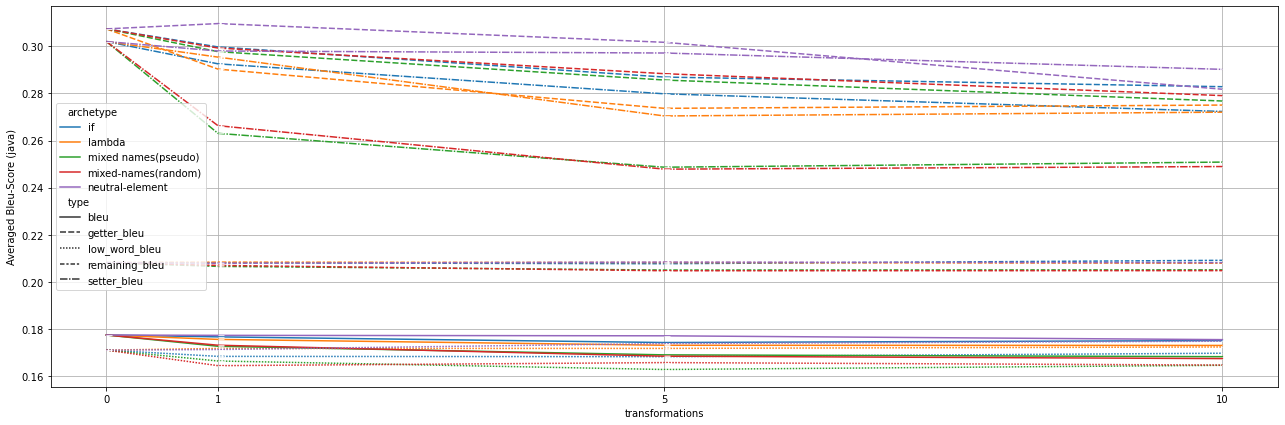

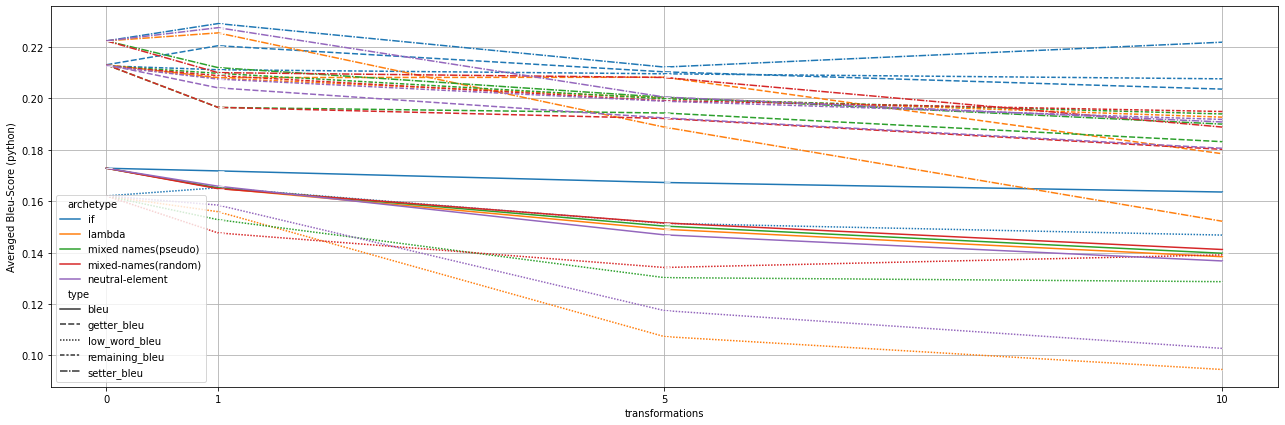

In [63]:
for lan in languages:
    plt.figure(figsize=(22, 7))
    plt.grid()

    sns.lineplot(
        data=split_bleus_df_type_b[split_bleus_df_type_b["prefix"]==lan],
        x="transformations",
        y="value",
        hue="archetype",
        style="type",
        marker=True)

    plt.xticks([0,1,5,10])
    plt.ylabel(f"Averaged Bleu-Score ({lan})")

    plt.savefig(f'images/bleu_score_per_category_per_archetype_{lan}.png')
    plt.show()

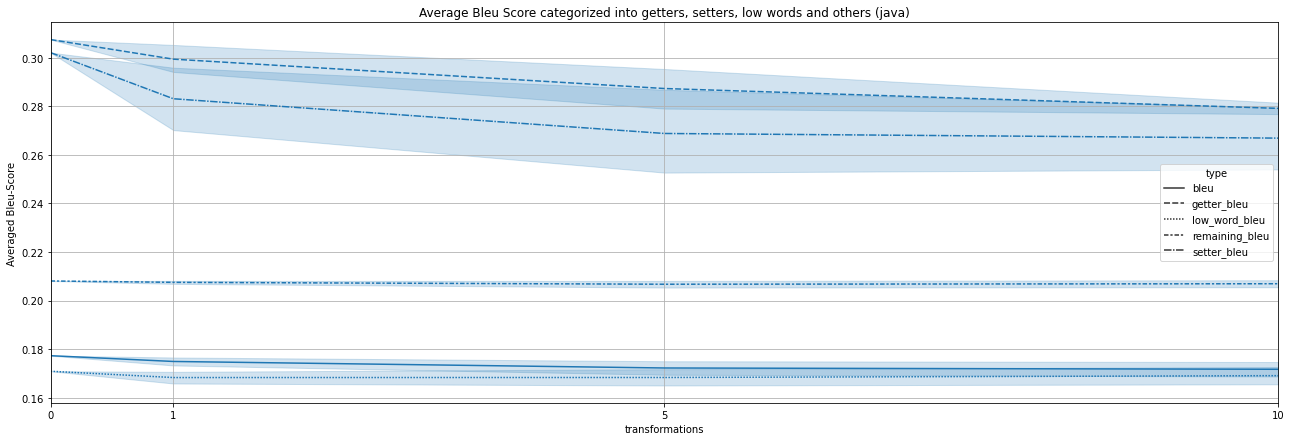

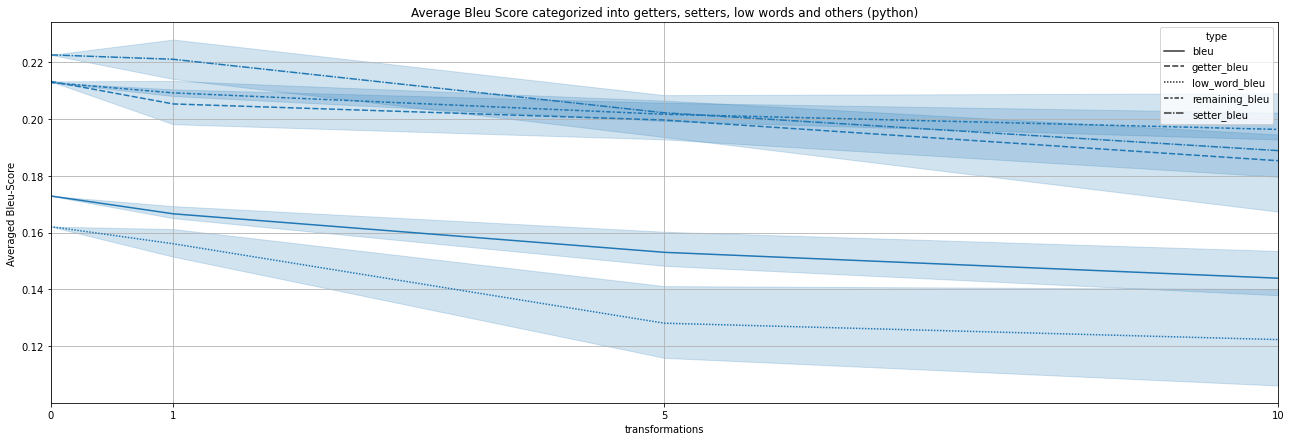

In [64]:
for lan in languages:
    plt.figure(figsize=(22, 7))
    plt.grid()

    plt.xticks([0,1,5,10])
    plt.ylabel("Averaged Bleu-Score")

    sns.lineplot(
        data=split_bleus_df_type_b[split_bleus_df_type_b["prefix"]==lan],
        x="transformations",
        y="value",
        style="type")
    plt.title(f"Average Bleu Score categorized into getters, setters, low words and others ({lan})")
    plt.xlim(0,10)

    plt.savefig(f'images/bleu_score_per_category_{lan}.png')

    plt.show()

Word count in gold 

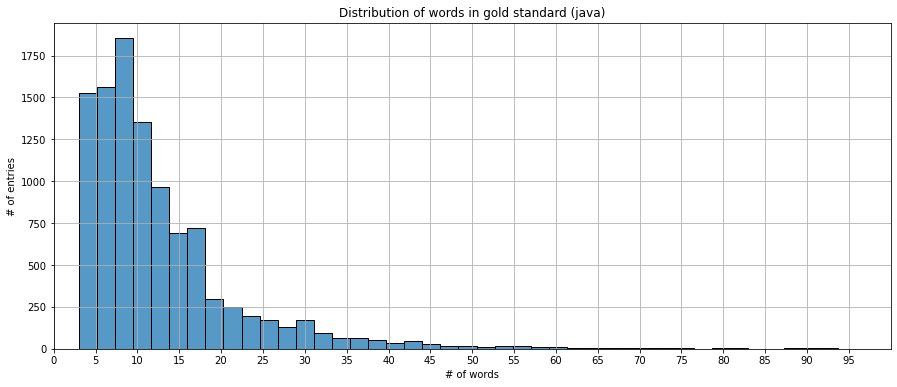

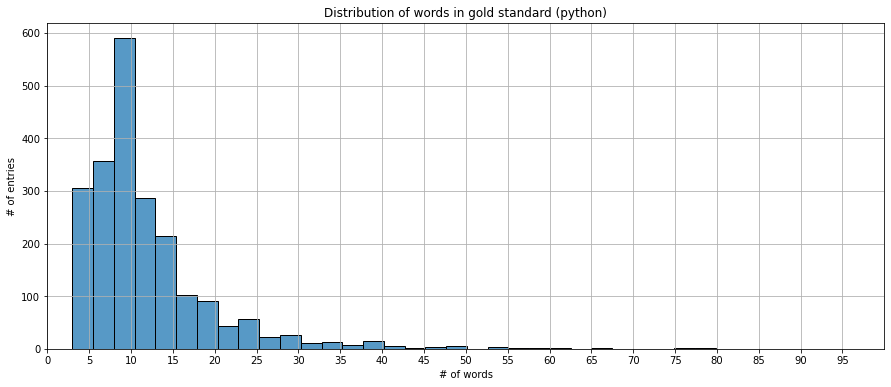

In [65]:
for lan in languages:
    data = []
    for index in results[lan]["reference"]["gold_results"].keys():
        words = len(results[lan]["reference"]["gold_results"][index].split())
        data.append(words)


    plt.figure(figsize=(15, 6))
    plt.grid()    
    sns.histplot(data,bins=50)

    plt.title(f"Distribution of words in gold standard ({lan})")
    plt.xlabel("# of words")
    plt.ylabel("# of entries")
    plt.xlim(0,100)

    plt.xticks(np.arange(0,100,5))

    plt.savefig(f'images/word_distribution_goldstandard_{lan}.png')

    plt.show()

    del words,data

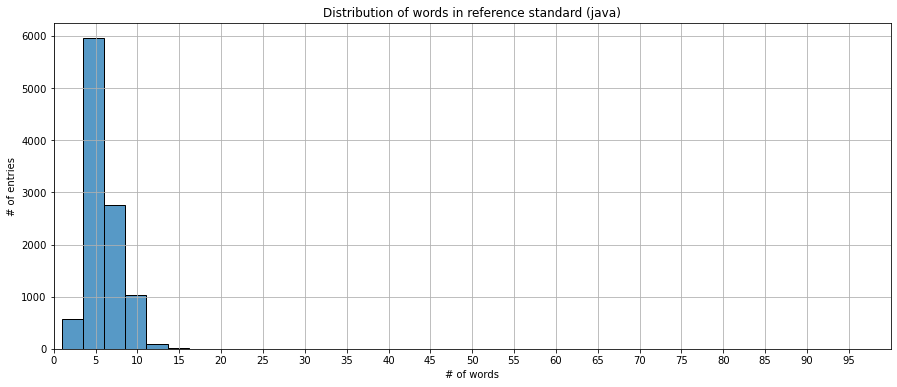

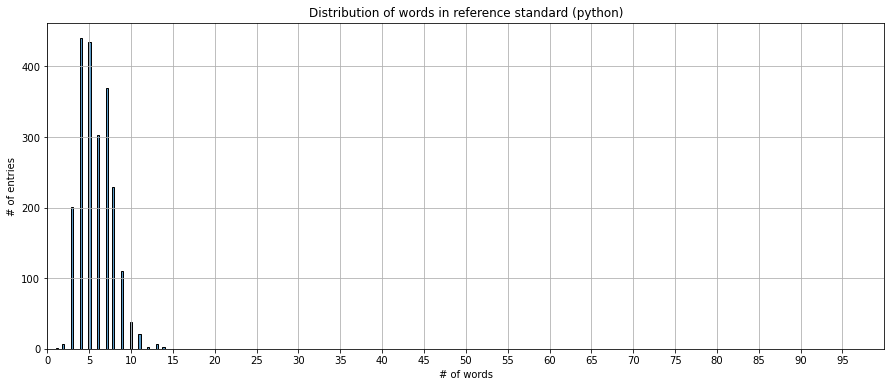

In [66]:
for lan in languages:
    data = []
    for index in results[lan]["reference"]["results"].keys():
        words = len(results[lan]["reference"]["results"][index].split())
        data.append(words)


    plt.figure(figsize=(15, 6))
    plt.grid()    
    sns.histplot(data,bins=50)

    plt.title(f"Distribution of words in reference standard ({lan})")
    plt.xlabel("# of words")
    plt.ylabel("# of entries")
    plt.xlim(0,100)

    plt.xticks(np.arange(0,100,5))

    plt.savefig(f'./exports/word_distribution_reference_{lan}.png')

    plt.show()

    del words,data

# Statistical Tests

The statistical Tests have been moved to [R](../R/scripts.R). 
They took a long time and were not comprehensible, so we moved them towards our comfort zone. 


# Export 

This can be used to print a pdf (or html). Comment it in if you want to do so. 

--to=pdf takes quite a while, --to=html is pretty fast. 



In [67]:
%%time
# Last time I ran this (May 2022), it took ~35 Minutes for Export 
do_export = False
# Last time it ran, it took 48 minutes on a Macbook

if do_export:
    # export to csv for R usage
    method_dict = {}
    for lan in languages:
        method_dict[lan] = {}
        for (p,i) in get_indizes:
            if p == lan:
                method_dict[lan][i]="Getter"
        for (p,i) in set_indizes:
            if p == lan:
                method_dict[lan][i]="Setter"
        for (p,i) in low_word_indizes:
            if p == lan:
                method_dict[lan][i]="Low_Words"
        for (p,i) in other_indizes:
            if p == lan:
                method_dict[lan][i]="Normal"

    csv_export_data  = []
    
    for lan in languages:
        for index in results[lan]["reference"]["results"].keys():
            ref_data = results[lan]["reference"]["results"][index]
            gold_data = results[lan]["reference"]["gold_results"][index]
            ref_bleu =  results[lan]["reference"]["bleu_values"][index]
            ref_length = len(ref_data)
            ref_word_length = len(ref_data.split())
            ref_jacc1_to_ref = 0 

            ref_jacc_1_to_gold = jaccard_wrapper(ref_data,gold_data)
            ref_perfect = gold_data == ref_data
            
            gold_length = len(gold_data)
            gold_word_length = len(gold_data.split())

            method_type = method_dict[lan][index]

            ref_datapoint = (lan,
                "reference","none","none","0", method_type,index,
                ref_bleu, ref_jacc1_to_ref,ref_jacc_1_to_gold,
                ref_length,ref_word_length,
                gold_length,gold_word_length,
                False,ref_perfect 
            )
            csv_export_data.append(ref_datapoint)

            for (prefix,config) in non_reference_configs:
                if prefix == lan:
                    conf_data = results[prefix][config]["results"][index]
                    arch = config_archetypes[config]
                    mt = archetype_mt_mapping[arch]
                    ts = results[prefix][config]["properties"]["transformations"]

                    bleu =  results[prefix][config]["bleu_values"][index]
                    length = len(conf_data)
                    word_length = len(conf_data.split())

                    diff = conf_data != ref_data
                    perfect = conf_data == gold_data

                    result_df_line = result_df[(result_df["prefix"]==prefix) & (result_df["config"]==config)  &  (result_df["index"]==index)]

                    jacc_1_to_ref = result_df_line["jaccard_n1_reference"].iloc(0)[0]
                    jacc_1_to_gold = result_df_line["jaccard_n1"].iloc(0)[0]

                    conf_datapoint = (
                        lan,
                        config,arch,mt,ts, method_type,index,
                        bleu,jacc_1_to_gold,jacc_1_to_ref,
                        length,word_length, 
                        gold_length,gold_word_length,
                        diff, perfect
                    )
                    csv_export_data.append(conf_datapoint)

    csv_export_df = pd.DataFrame(csv_export_data)
    csv_export_df.columns = [
        "prefix",
        "config","archetype","MT","transformations","method_type","entry",
        "bleu_score",
        "jaccard_distance_to_gold","jaccard_distance_to_reference",
        "length_in_characters", "length_in_words",
        "gold_length_in_characters", "gold_length_in_words",
        "different_to_ref", "perfect_match_with_gold"
    ]
    csv_export_df.to_csv("./exports/bleus.csv")
    # csv_export_df[(csv_export_df["prefix"]=="python") & (csv_export_df["method_type"] != "Normal")]
    csv_export_df.head(5)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [68]:
# del csv_export_df
# !jupyter nbconvert --to=pdf --output-dir=./exports Evaluation.ipynb

Word count in gold 

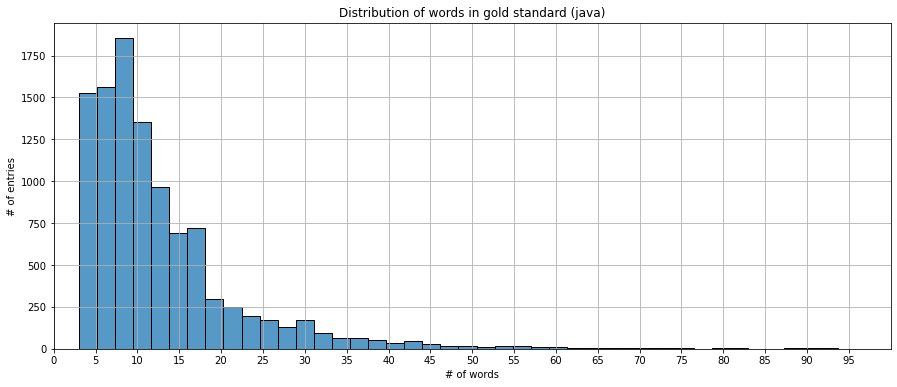

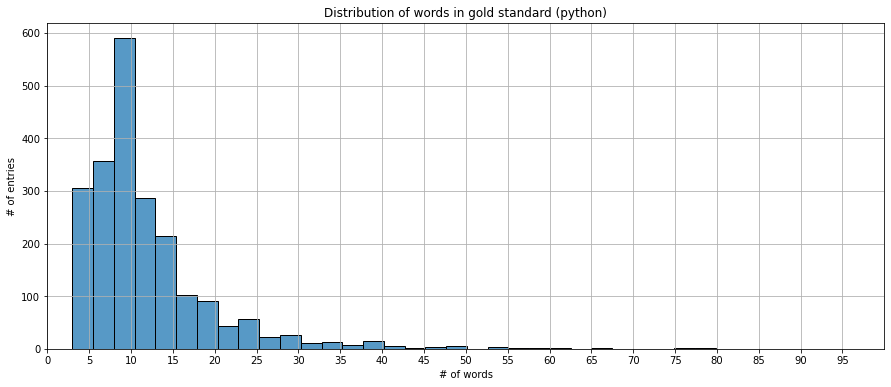

In [69]:
for lan in languages:
    data = []
    for index in results[lan]["reference"]["gold_results"].keys():
        words = len(results[lan]["reference"]["gold_results"][index].split())
        data.append(words)


    plt.figure(figsize=(15, 6))
    plt.grid()    
    sns.histplot(data,bins=50)

    plt.title(f"Distribution of words in gold standard ({lan})")
    plt.xlabel("# of words")
    plt.ylabel("# of entries")
    plt.xlim(0,100)

    plt.xticks(np.arange(0,100,5))

    plt.savefig(f'images/word_distribution_goldstandard_{lan}.png')

    plt.show()

    del words,data

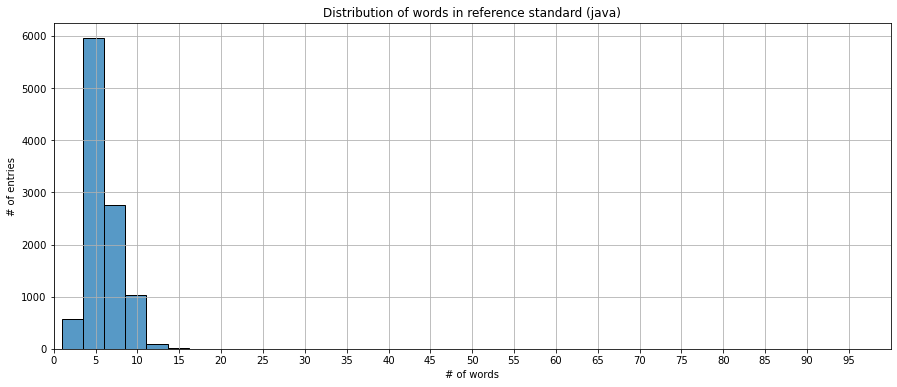

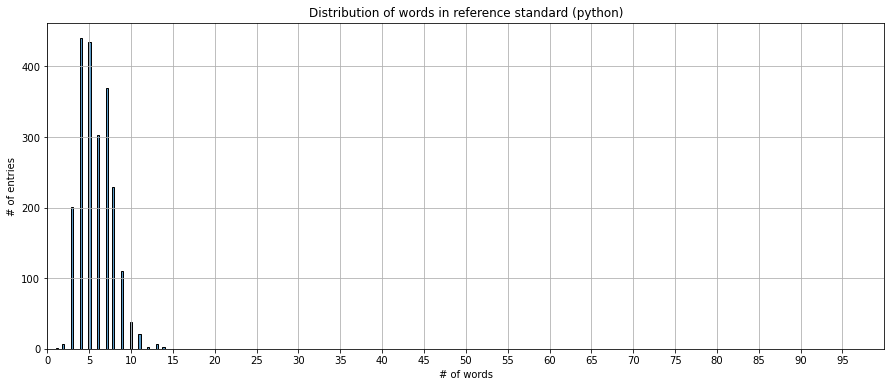

In [70]:
for lan in languages:
    data = []
    for index in results[lan]["reference"]["results"].keys():
        words = len(results[lan]["reference"]["results"][index].split())
        data.append(words)


    plt.figure(figsize=(15, 6))
    plt.grid()    
    sns.histplot(data,bins=50)

    plt.title(f"Distribution of words in reference standard ({lan})")
    plt.xlabel("# of words")
    plt.ylabel("# of entries")
    plt.xlim(0,100)

    plt.xticks(np.arange(0,100,5))

    plt.savefig(f'./exports/word_distribution_reference_{lan}.png')

    plt.show()

    del words,data

# Statistical Tests

The statistical Tests have been moved to [R](../R/scripts.R). 
They took a long time and were not comprehensible, so we moved them towards our comfort zone. 


# Export 

This can be used to print a pdf (or html). Comment it in if you want to do so. 

--to=pdf takes quite a while, --to=html is pretty fast. 



In [77]:

# Last time I ran this (May 2022), it took ~35 Minutes for Export 
do_export = True

In [89]:

if do_export:
    # export to csv for R usage
    method_dict = {}
    for lan in languages:
        method_dict[lan] = {}
        for (p,i) in get_indizes:
            if p == lan:
                method_dict[lan][i]="Getter"
        for (p,i) in set_indizes:
            if p == lan:
                method_dict[lan][i]="Setter"
        for (p,i) in low_word_indizes:
            if p == lan:
                method_dict[lan][i]="Low_Words"
        for (p,i) in other_indizes:
            if p == lan:
                method_dict[lan][i]="Normal"

#print(method_dict["java"])
print(method_dict["java"][8488])

Setter


In [ ]:
%%time

if do_export:
    csv_export_data  = []
    
    for lan in languages:
        for index in results[lan]["reference"]["results"].keys():
            ref_data = results[lan]["reference"]["results"][index]
            gold_data = results[lan]["reference"]["gold_results"][index]
            ref_bleu =  results[lan]["reference"]["bleu_values"][index]
            ref_length = len(ref_data)
            ref_word_length = len(ref_data.split())
            ref_jacc1_to_ref = 0 

            ref_jacc_1_to_gold = jaccard_wrapper(ref_data,gold_data)
            ref_perfect = gold_data == ref_data
            
            gold_length = len(gold_data)
            gold_word_length = len(gold_data.split())

            method_type = method_dict[lan][index]
            #print(f"Method Type @{lan}:{index} is {method_type}")

            ref_datapoint = (lan,
                "reference","none","none","0", method_type,index,
                ref_bleu, ref_jacc1_to_ref,ref_jacc_1_to_gold,
                ref_length,ref_word_length,
                gold_length,gold_word_length,
                False,ref_perfect 
            )
            csv_export_data.append(ref_datapoint)

            for (prefix,config) in non_reference_configs:
                if prefix == lan:
                    conf_data = results[prefix][config]["results"][index]
                    arch = config_archetypes[config]
                    mt = archetype_mt_mapping[arch]
                    ts = results[prefix][config]["properties"]["transformations"]

                    bleu =  results[prefix][config]["bleu_values"][index]
                    length = len(conf_data)
                    word_length = len(conf_data.split())

                    diff = conf_data != ref_data
                    perfect = conf_data == gold_data

                    result_df_line = result_df[(result_df["prefix"]==prefix) & (result_df["config"]==config)  &  (result_df["index"]==index)]

                    jacc_1_to_ref = result_df_line["jaccard_n1_reference"].iloc(0)[0]
                    jacc_1_to_gold = result_df_line["jaccard_n1"].iloc(0)[0]

                    conf_datapoint = (
                        lan,
                        config,arch,mt,ts, method_type,index,
                        bleu,jacc_1_to_gold,jacc_1_to_ref,
                        length,word_length, 
                        gold_length,gold_word_length,
                        diff, perfect
                    )
                    csv_export_data.append(conf_datapoint)
            del method_type,index,
                ref_bleu, ref_jacc1_to_ref,ref_jacc_1_to_gold,
                ref_length,ref_word_length,
                gold_length,gold_word_length,
                False,ref_perfect 
    csv_export_df = pd.DataFrame(csv_export_data)
    csv_export_df.columns = [
        "prefix",
        "config","archetype","MT","transformations","method_type","entry",
        "bleu_score",
        "jaccard_distance_to_gold","jaccard_distance_to_reference",
        "length_in_characters", "length_in_words",
        "gold_length_in_characters", "gold_length_in_words",
        "different_to_ref", "perfect_match_with_gold"
    ]
    csv_export_df.to_csv("./exports/bleus.csv")
    # csv_export_df[(csv_export_df["prefix"]=="python") & (csv_export_df["method_type"] != "Normal")]
    csv_export_df.head(5)

In [90]:
# del csv_export_df
# !jupyter nbconvert --to=pdf --output-dir=./exports Evaluation.ipynb

Method Type @java:0 is Normal
Method Type @java:1 is Normal
Method Type @java:2 is Normal
Method Type @java:3 is Normal
Method Type @java:4 is Normal
Method Type @java:5 is Normal
Method Type @java:6 is Normal
Method Type @java:7 is Normal
Method Type @java:8 is Normal
Method Type @java:9 is Normal
Method Type @java:10 is Normal
Method Type @java:11 is Normal
Method Type @java:12 is Normal
Method Type @java:13 is Normal
Method Type @java:14 is Normal
Method Type @java:15 is Normal
Method Type @java:16 is Normal
Method Type @java:17 is Low_Words
Method Type @java:18 is Normal
Method Type @java:19 is Normal
Method Type @java:20 is Getter
Method Type @java:21 is Normal
Method Type @java:22 is Normal
Method Type @java:23 is Normal
Method Type @java:24 is Normal
Method Type @java:25 is Normal
Method Type @java:26 is Normal
Method Type @java:27 is Normal
Method Type @java:28 is Low_Words
Method Type @java:29 is Normal
Method Type @java:30 is Normal
Method Type @java:31 is Normal
Method Type 

Method Type @java:259 is Normal
Method Type @java:260 is Normal
Method Type @java:261 is Normal
Method Type @java:262 is Normal
Method Type @java:263 is Low_Words
Method Type @java:264 is Normal
Method Type @java:265 is Normal
Method Type @java:266 is Normal
Method Type @java:267 is Normal
Method Type @java:268 is Normal
Method Type @java:269 is Normal
Method Type @java:270 is Normal
Method Type @java:271 is Normal
Method Type @java:272 is Normal
Method Type @java:273 is Normal
Method Type @java:274 is Normal
Method Type @java:275 is Normal
Method Type @java:276 is Normal
Method Type @java:277 is Normal
Method Type @java:278 is Normal
Method Type @java:279 is Normal
Method Type @java:280 is Normal
Method Type @java:281 is Normal
Method Type @java:282 is Normal
Method Type @java:283 is Normal
Method Type @java:284 is Normal
Method Type @java:285 is Normal
Method Type @java:286 is Normal
Method Type @java:287 is Normal
Method Type @java:288 is Normal
Method Type @java:289 is Normal
Metho

KeyboardInterrupt: 

In [73]:
# del csv_export_df
# !jupyter nbconvert --to=pdf --output-dir=./exports Evaluation.ipynb